ANALYSE EXPLORATOIRE DES DONNÉES (EDA)

1️⃣ INFORMATIONS GÉNÉRALES
--------------------------------------------------------------------------------
Taille du dataset: 58,167 lignes × 41 colonnes
Mémoire utilisée: 20.97 MB

Types de données:
float64    37
int64       3
object      1
Name: count, dtype: int64

2️⃣ VALEURS MANQUANTES
--------------------------------------------------------------------------------
✅ Aucune valeur manquante!

Valeurs infinies: 0

3️⃣ ANALYSE DE LA VARIABLE CIBLE
--------------------------------------------------------------------------------
Distribution:
  Pas de feu (0): 54,591 (93.85%)
  Feu (1):        3,576 (6.15%)
  Ratio déséquilibre: 15.3:1

4️⃣ COMPARAISON DES VARIABLES CLIMATIQUES PAR CLASSE
--------------------------------------------------------------------------------

Moyennes par classe:
tmin_hot_dry              | Sans feu:   26.17 | Avec feu:   23.21 | Diff:   -2.95 ( -11.3%)
tmax_hot_dry              | Sans feu:   41.12 | Avec feu:   37.37

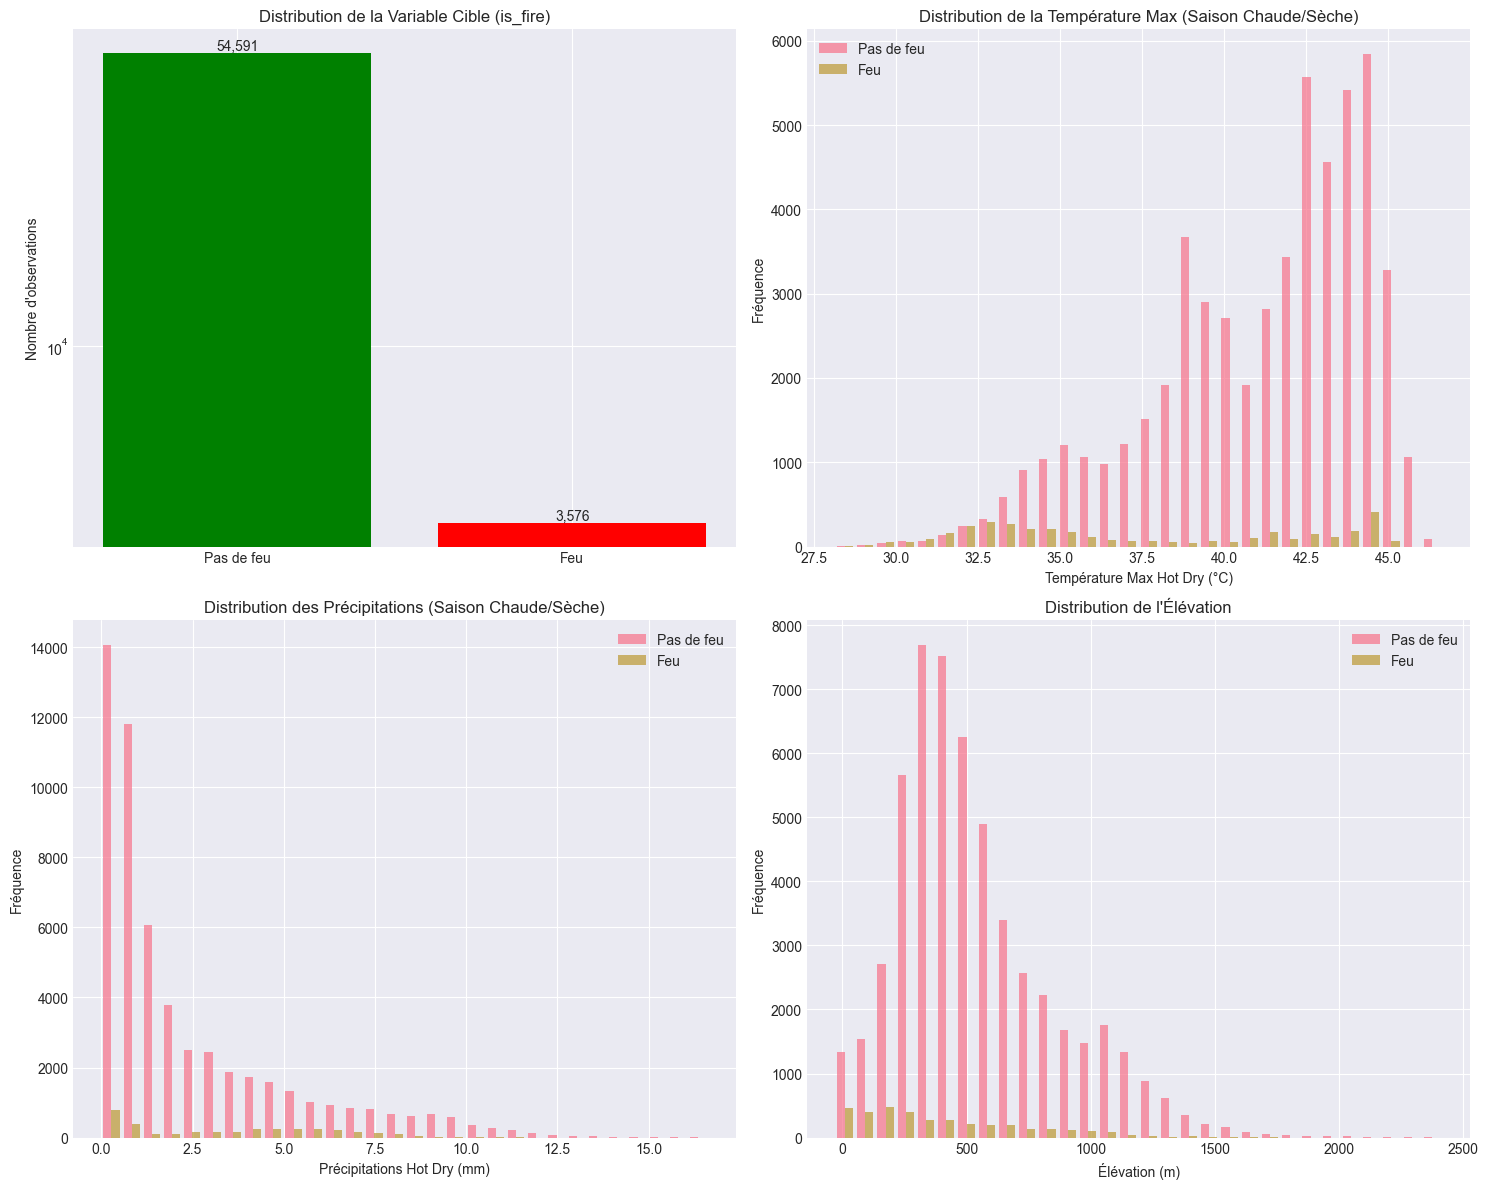

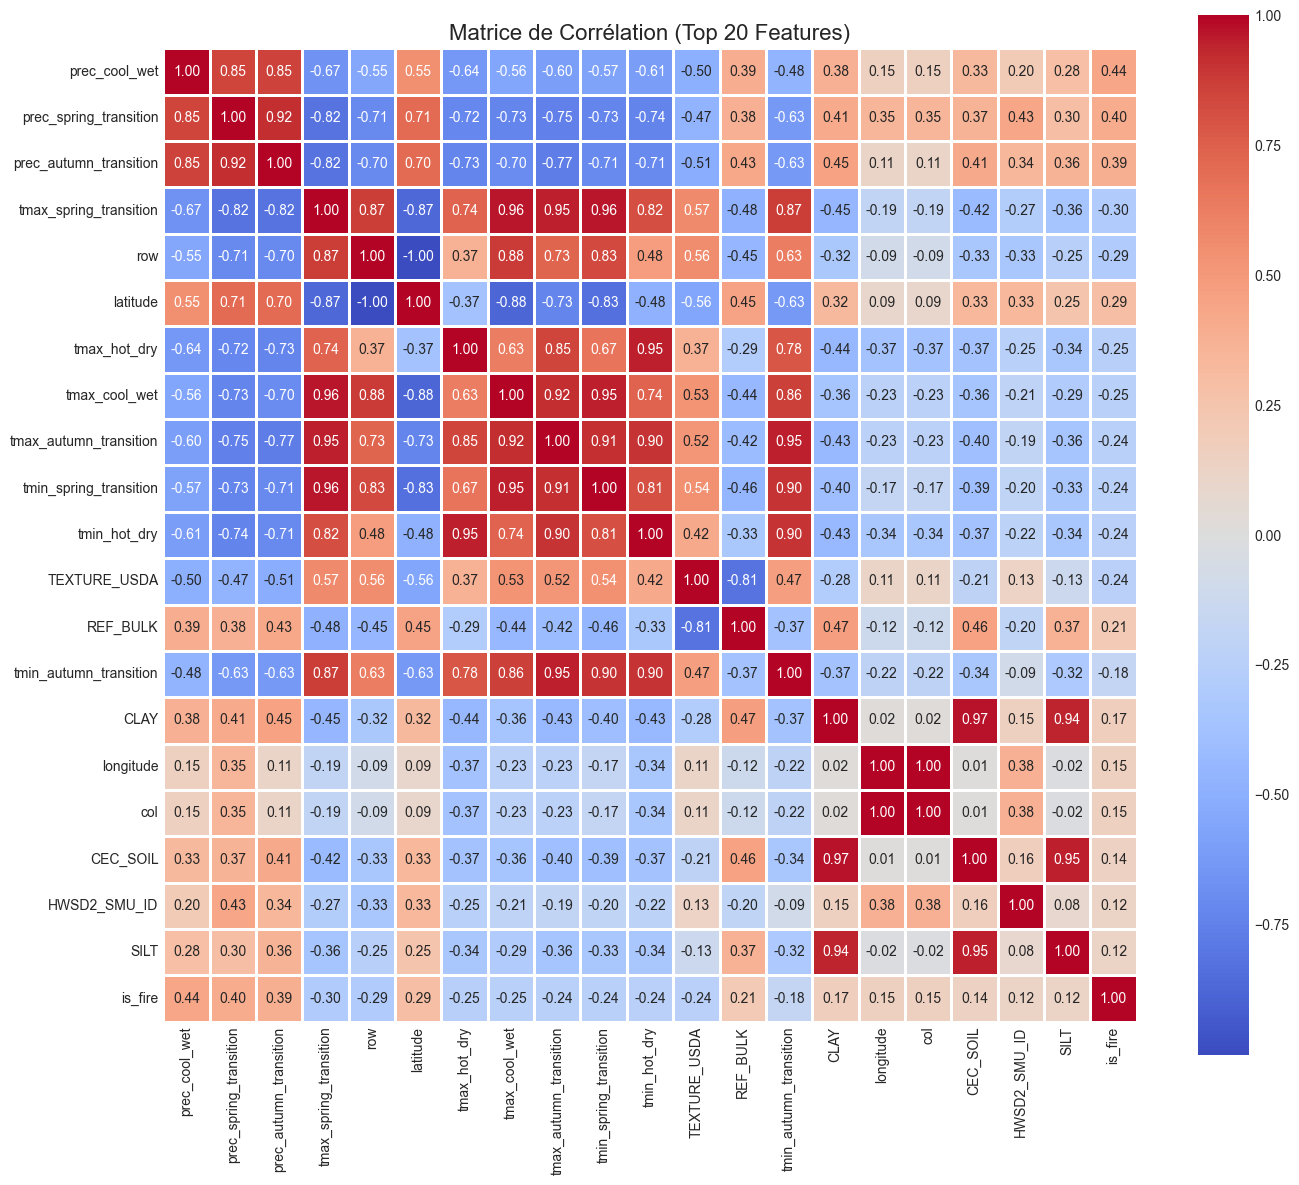

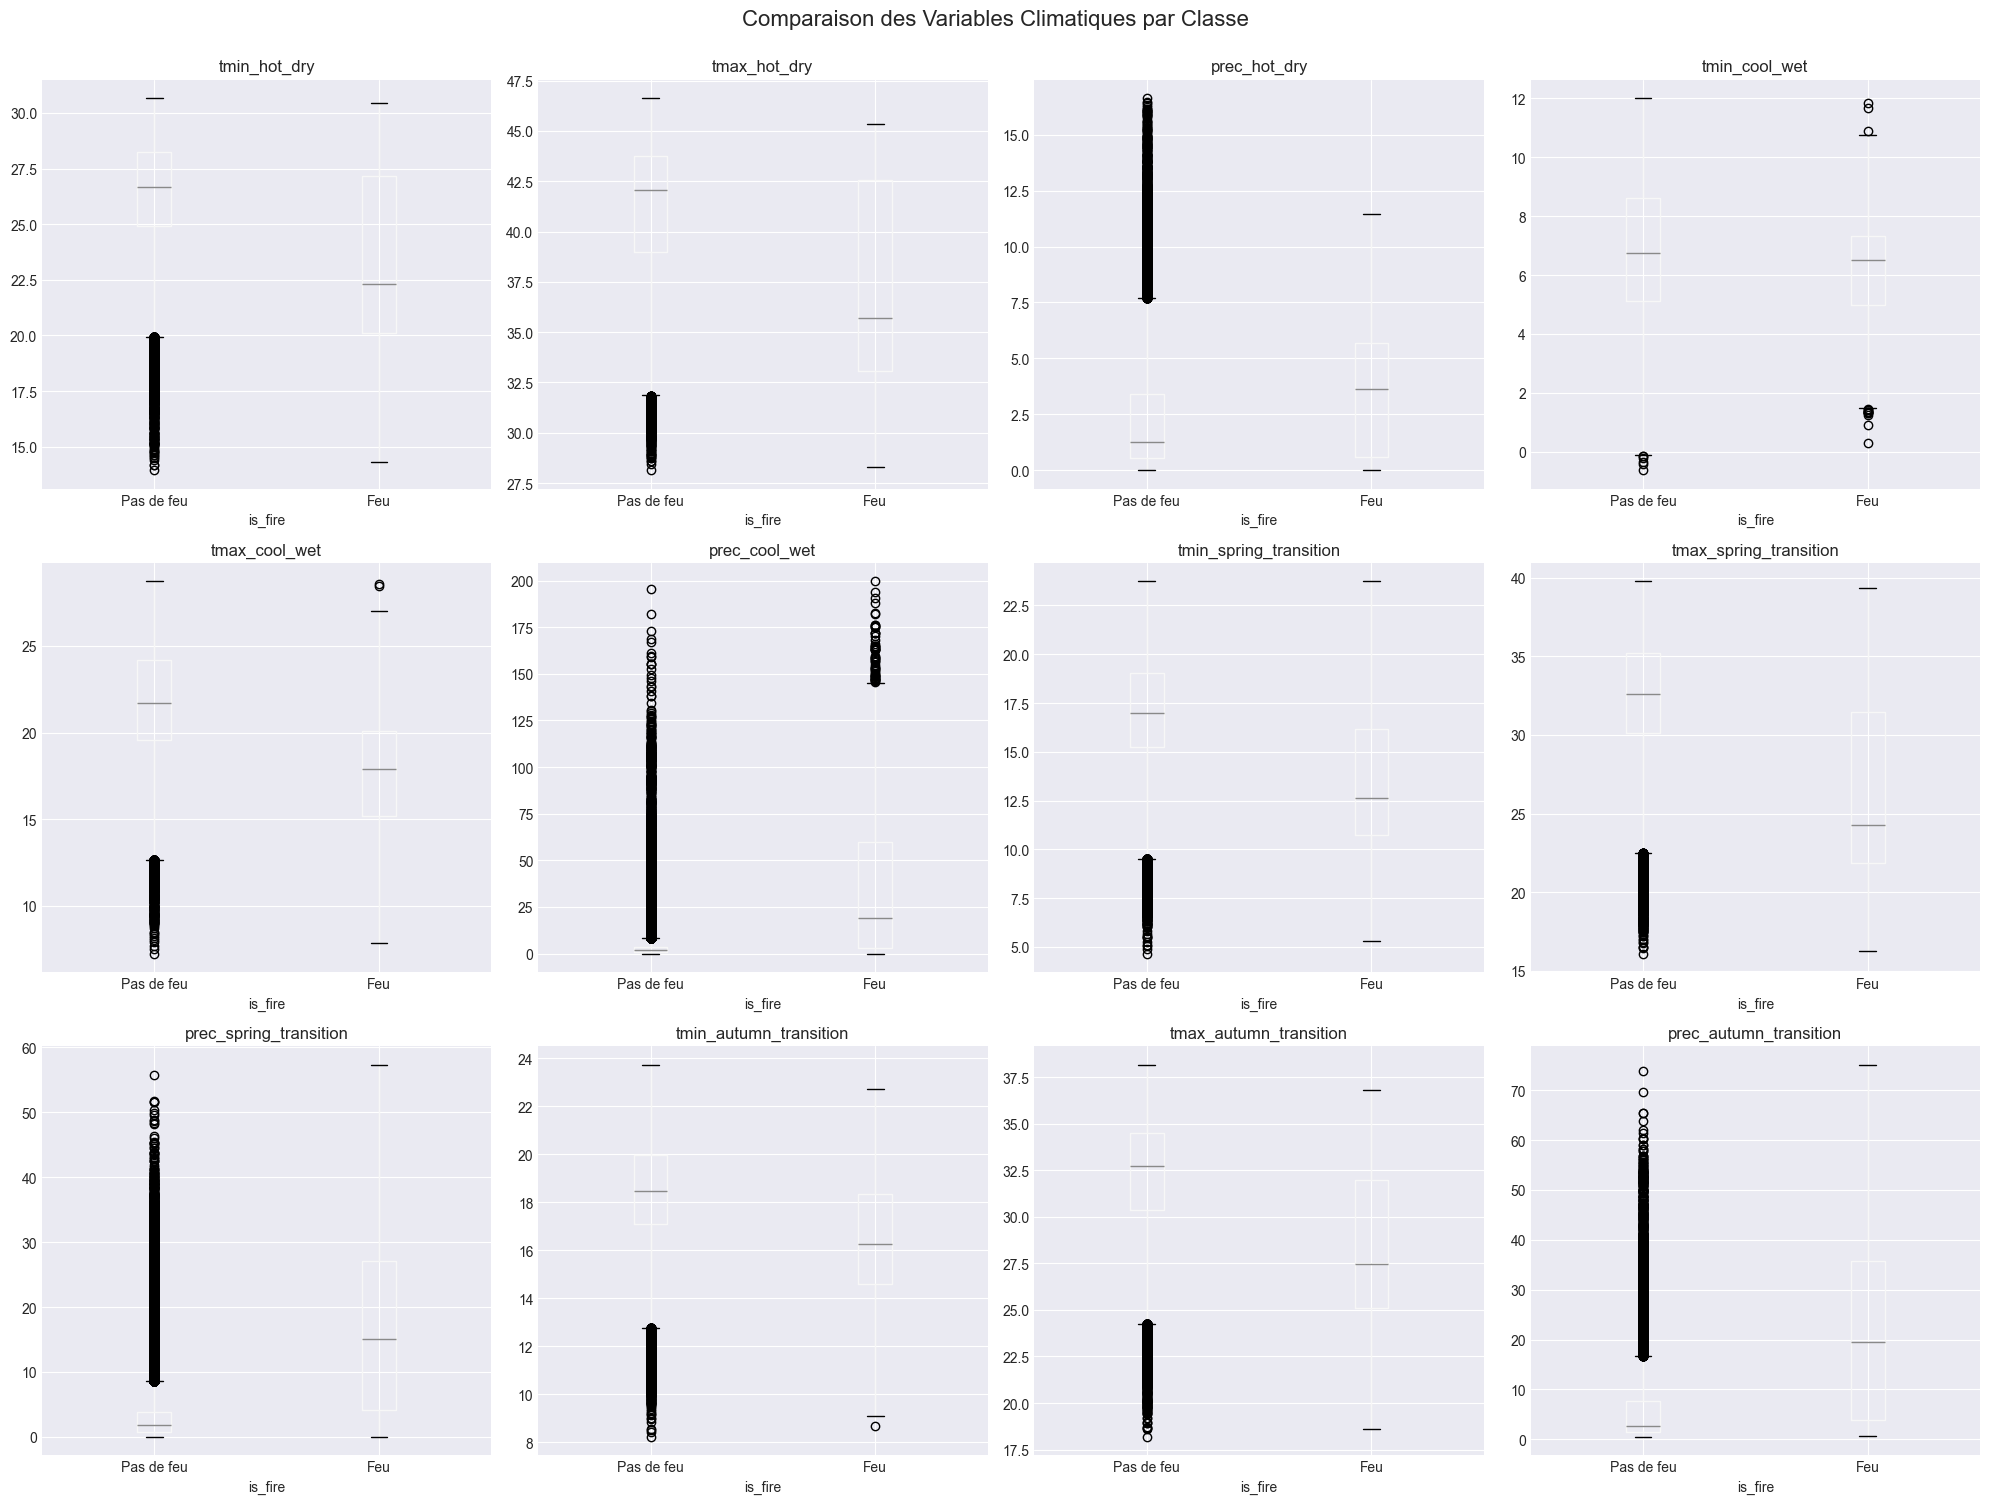

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Charger les données
df = pd.read_csv('data.csv')

print("="*80)
print("ANALYSE EXPLORATOIRE DES DONNÉES (EDA)")
print("="*80)

# ============================================================================
# 1. INFORMATIONS GÉNÉRALES
# ============================================================================
print("\n1️⃣ INFORMATIONS GÉNÉRALES")
print("-" * 80)
print(f"Taille du dataset: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"Mémoire utilisée: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Distribution des types de données
print(f"\nTypes de données:")
print(df.dtypes.value_counts())

# ============================================================================
# 2. VALEURS MANQUANTES ET ABERRANTES
# ============================================================================
print("\n2️⃣ VALEURS MANQUANTES")
print("-" * 80)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ Aucune valeur manquante!")
else:
    print(missing[missing > 0])

# Vérification des valeurs infinies
inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
print(f"\nValeurs infinies: {inf_count}")

# ============================================================================
# 3. ANALYSE DE LA VARIABLE CIBLE (is_fire)
# ============================================================================
print("\n3️⃣ ANALYSE DE LA VARIABLE CIBLE")
print("-" * 80)
fire_counts = df['is_fire'].value_counts()
fire_ratio = df['is_fire'].mean()

print(f"Distribution:")
print(f"  Pas de feu (0): {fire_counts[0]:,} ({(1-fire_ratio)*100:.2f}%)")
print(f"  Feu (1):        {fire_counts[1]:,} ({fire_ratio*100:.2f}%)")
print(f"  Ratio déséquilibre: {fire_counts[0]/fire_counts[1]:.1f}:1")

# ============================================================================
# 4. STATISTIQUES DESCRIPTIVES PAR CLASSE
# ============================================================================
print("\n4️⃣ COMPARAISON DES VARIABLES CLIMATIQUES PAR CLASSE")
print("-" * 80)

climate_features = ['tmin_hot_dry', 'tmax_hot_dry', 'prec_hot_dry',
                   'tmin_cool_wet', 'tmax_cool_wet', 'prec_cool_wet',
                   'tmin_spring_transition', 'tmax_spring_transition', 'prec_spring_transition',
                   'tmin_autumn_transition', 'tmax_autumn_transition', 'prec_autumn_transition']

print("\nMoyennes par classe:")
for feature in climate_features:
    mean_no_fire = df[df['is_fire'] == 0][feature].mean()
    mean_fire = df[df['is_fire'] == 1][feature].mean()
    diff = mean_fire - mean_no_fire
    diff_pct = (diff / mean_no_fire) * 100 if mean_no_fire != 0 else 0
    
    print(f"{feature:25s} | Sans feu: {mean_no_fire:7.2f} | "
          f"Avec feu: {mean_fire:7.2f} | Diff: {diff:+7.2f} ({diff_pct:+6.1f}%)")

# ============================================================================
# 5. ANALYSE DES ATTRIBUTS DU SOL
# ============================================================================
print("\n5️⃣ ANALYSE DES ATTRIBUTS DU SOL")
print("-" * 80)

soil_features = ['SAND', 'SILT', 'CLAY', 'ORG_CARBON', 'PH_WATER', 
                'BULK', 'elevation', 'COARSE', 'TOTAL_N', 'CN_RATIO',
                'CEC_SOIL', 'CEC_CLAY', 'TEB', 'BSAT']

print("\nMoyennes par classe (Sol):")
for feature in soil_features:
    if feature in df.columns:
        mean_no_fire = df[df['is_fire'] == 0][feature].mean()
        mean_fire = df[df['is_fire'] == 1][feature].mean()
        diff = mean_fire - mean_no_fire
        diff_pct = (diff / mean_no_fire) * 100 if mean_no_fire != 0 else 0
        
        print(f"{feature:15s} | Sans feu: {mean_no_fire:7.2f} | "
              f"Avec feu: {mean_fire:7.2f} | Diff: {diff:+7.2f} ({diff_pct:+6.1f}%)")

# ============================================================================
# 6. CORRÉLATIONS AVEC is_fire
# ============================================================================
print("\n6️⃣ CORRÉLATIONS AVEC is_fire")
print("-" * 80)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'is_fire' in numeric_cols:
    numeric_cols.remove('is_fire')

correlations = df[numeric_cols + ['is_fire']].corr()['is_fire'].drop('is_fire')
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("\nTop 15 corrélations (valeur absolue):")
for i, (feature, corr) in enumerate(correlations_sorted.head(15).items(), 1):
    actual_corr = correlations[feature]
    print(f"{i:2d}. {feature:25s}: {actual_corr:+.4f}")

# ============================================================================
# 7. DÉTECTION D'OUTLIERS (IQR METHOD)
# ============================================================================
print("\n7️⃣ DÉTECTION D'OUTLIERS")
print("-" * 80)

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

print("\nNombre d'outliers par variable (méthode IQR):")
outlier_counts = {}
for col in climate_features + soil_features:
    if col in df.columns:
        outliers = count_outliers(df[col])
        outlier_counts[col] = outliers
        if outliers > 0:
            pct = (outliers / len(df)) * 100
            print(f"{col:25s}: {outliers:6,} ({pct:.2f}%)")

# ============================================================================
# 8. ANALYSE DES VARIABLES CATÉGORIELLES
# ============================================================================
print("\n8️⃣ VARIABLES CATÉGORIELLES")
print("-" * 80)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts().head(10))

# ============================================================================
# 9. VISUALISATIONS
# ============================================================================
print("\n9️⃣ GÉNÉRATION DES VISUALISATIONS...")
print("-" * 80)

# Figure 1: Distribution de is_fire
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1.1 Distribution cible
axes[0, 0].bar(['Pas de feu', 'Feu'], fire_counts.values, color=['green', 'red'])
axes[0, 0].set_ylabel('Nombre d\'observations')
axes[0, 0].set_title('Distribution de la Variable Cible (is_fire)')
axes[0, 0].set_yscale('log')
for i, v in enumerate(fire_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# 1.2 Température max hot_dry
axes[0, 1].hist([df[df['is_fire']==0]['tmax_hot_dry'], 
                 df[df['is_fire']==1]['tmax_hot_dry']], 
                bins=30, label=['Pas de feu', 'Feu'], alpha=0.7)
axes[0, 1].set_xlabel('Température Max Hot Dry (°C)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution de la Température Max (Saison Chaude/Sèche)')
axes[0, 1].legend()

# 1.3 Précipitations hot_dry
axes[1, 0].hist([df[df['is_fire']==0]['prec_hot_dry'], 
                 df[df['is_fire']==1]['prec_hot_dry']], 
                bins=30, label=['Pas de feu', 'Feu'], alpha=0.7)
axes[1, 0].set_xlabel('Précipitations Hot Dry (mm)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des Précipitations (Saison Chaude/Sèche)')
axes[1, 0].legend()

# 1.4 Élévation
axes[1, 1].hist([df[df['is_fire']==0]['elevation'], 
                 df[df['is_fire']==1]['elevation']], 
                bins=30, label=['Pas de feu', 'Feu'], alpha=0.7)
axes[1, 1].set_xlabel('Élévation (m)')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution de l\'Élévation')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: eda_distributions.png")

# Figure 2: Matrice de corrélation (top features)
top_features = correlations_sorted.head(20).index.tolist() + ['is_fire']
corr_matrix = df[top_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Matrice de Corrélation (Top 20 Features)', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: correlation_matrix.png")

# Figure 3: Boxplots des features climatiques
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, feature in enumerate(climate_features):
    df.boxplot(column=feature, by='is_fire', ax=axes[idx])
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel('is_fire')
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['Pas de feu', 'Feu'])

plt.suptitle('Comparaison des Variables Climatiques par Classe', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('climate_boxplots.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: climate_boxplots.png")

print("\n" + "="*80)
print("✅ ANALYSE EXPLORATOIRE TERMINÉE!")
print("="*80)
print("\nFichiers générés:")
print("  1. eda_distributions.png")
print("  2. correlation_matrix.png")
print("  3. climate_boxplots.png")

FEATURE ENGINEERING ET ÉQUILIBRAGE DE DATASET

📁 ÉTAPE 1: CHARGEMENT DES DONNÉES
--------------------------------------------------------------------------------
✅ Dataset chargé: 58,167 lignes × 41 colonnes

🗑️  ÉTAPE 2: SUPPRESSION DES COLONNES NON PERTINENTES
--------------------------------------------------------------------------------
Colonnes à supprimer: ['longitude', 'latitude', 'row', 'col', 'HWSD2_SMU_ID']
✅ 5 colonnes supprimées
   Nouvelles dimensions: 35 colonnes

📊 ÉTAPE 3: ÉLIMINATION DES VARIABLES À FAIBLE VARIANCE
--------------------------------------------------------------------------------
Variables à faible variance (< 0.01):
  - REF_BULK: variance = 0.007677
✅ 1 variables à faible variance supprimées
   Nouvelles dimensions: 34 colonnes

🔗 ÉTAPE 4: ÉLIMINATION DES VARIABLES FORTEMENT CORRÉLÉES
--------------------------------------------------------------------------------
Seuil de corrélation: 0.9

Paires fortement corrélées (>0.9):
  - SAND ↔ BULK: 0.905
  - 

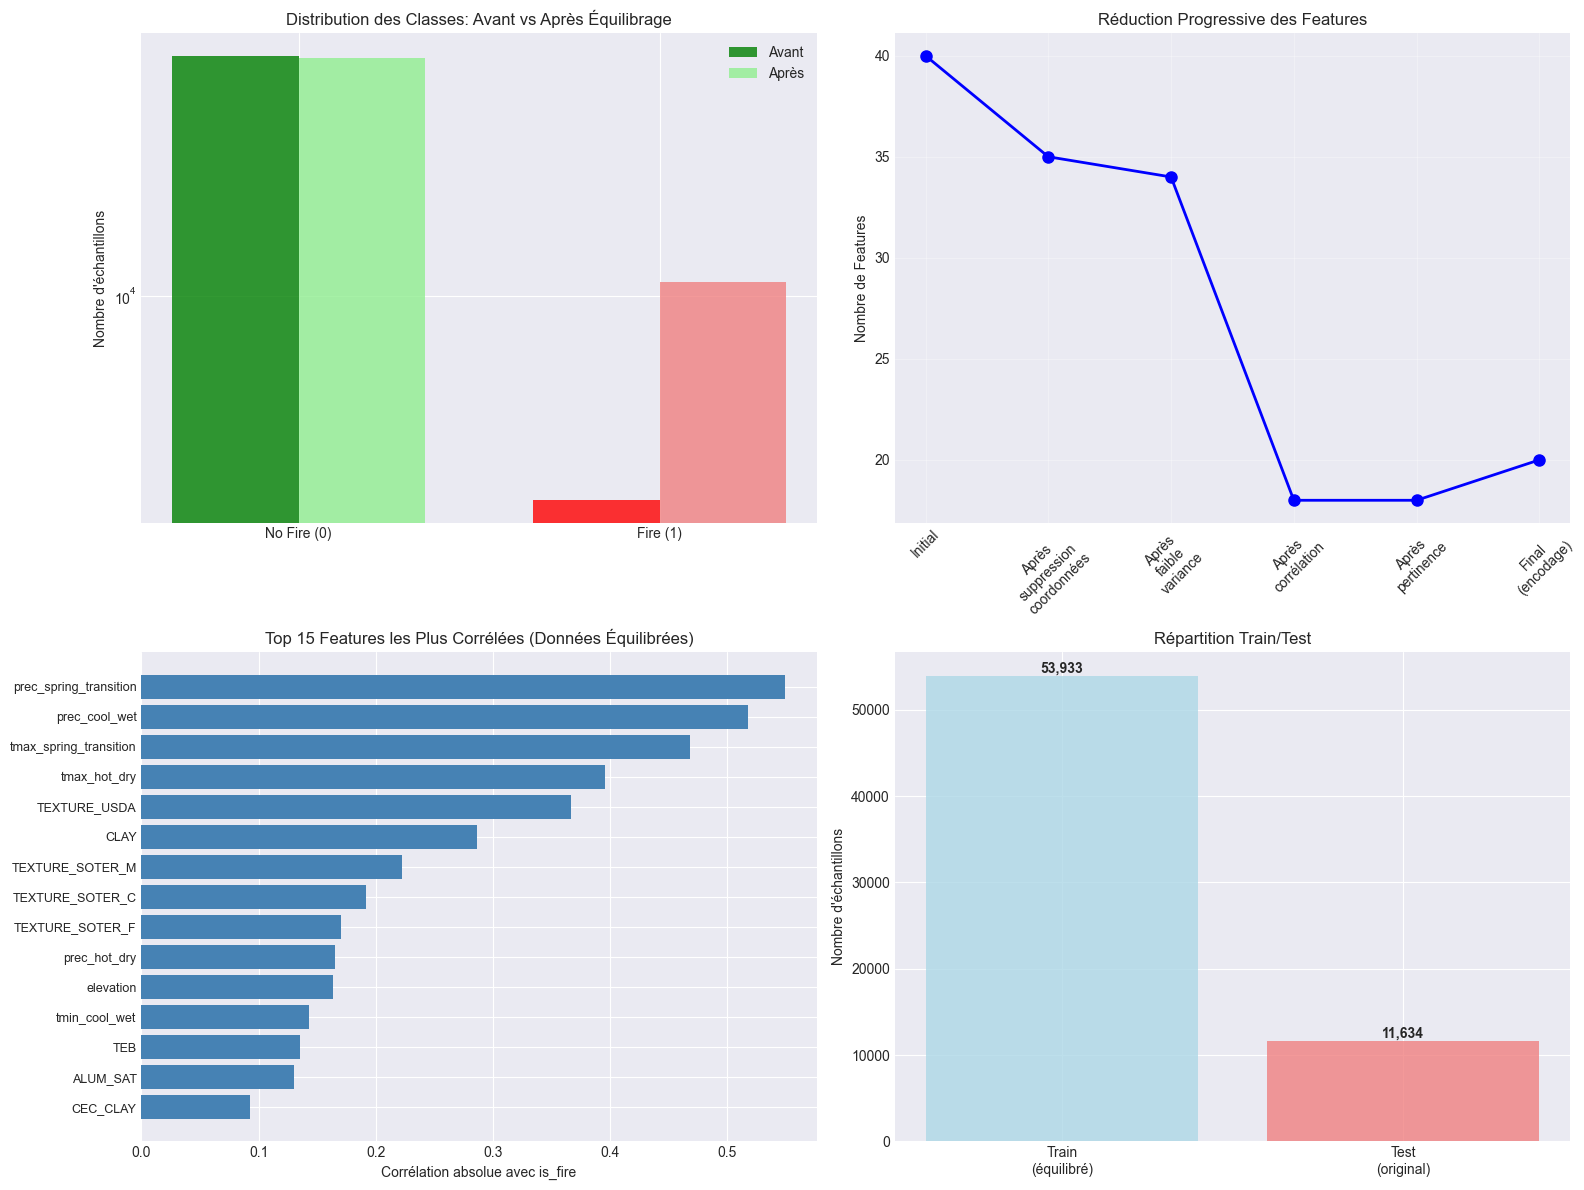

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("FEATURE ENGINEERING ET ÉQUILIBRAGE DE DATASET")
print("="*80)

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================
print("\n📁 ÉTAPE 1: CHARGEMENT DES DONNÉES")
print("-" * 80)
df = pd.read_csv('data.csv')
print(f"✅ Dataset chargé: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")

initial_shape = df.shape
X = df.drop('is_fire', axis=1)
y = df['is_fire']

# ============================================================================
# 2. SUPPRESSION DES COLONNES SPÉCIFIÉES
# ============================================================================
print("\n🗑️  ÉTAPE 2: SUPPRESSION DES COLONNES NON PERTINENTES")
print("-" * 80)
cols_to_drop = ['longitude', 'latitude', 'row', 'col', 'HWSD2_SMU_ID']
existing_cols = [col for col in cols_to_drop if col in X.columns]

print(f"Colonnes à supprimer: {existing_cols}")
X = X.drop(existing_cols, axis=1)
print(f"✅ {len(existing_cols)} colonnes supprimées")
print(f"   Nouvelles dimensions: {X.shape[1]} colonnes")

# ============================================================================
# 3. ÉLIMINATION DES VARIABLES À FAIBLE VARIANCE
# ============================================================================
print("\n📊 ÉTAPE 3: ÉLIMINATION DES VARIABLES À FAIBLE VARIANCE")
print("-" * 80)

# Séparer numériques et catégorielles
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Calculer la variance pour les colonnes numériques
variances = X[numeric_cols].var()
low_variance_threshold = 0.01
low_variance_cols = variances[variances < low_variance_threshold].index.tolist()

print(f"Variables à faible variance (< {low_variance_threshold}):")
for col in low_variance_cols:
    print(f"  - {col}: variance = {variances[col]:.6f}")

if low_variance_cols:
    X = X.drop(low_variance_cols, axis=1)
    numeric_cols = [col for col in numeric_cols if col not in low_variance_cols]
    print(f"✅ {len(low_variance_cols)} variables à faible variance supprimées")
else:
    print("✅ Aucune variable à faible variance détectée")

print(f"   Nouvelles dimensions: {X.shape[1]} colonnes")

# ============================================================================
# 4. ÉLIMINATION DES VARIABLES FORTEMENT CORRÉLÉES
# ============================================================================
print("\n🔗 ÉTAPE 4: ÉLIMINATION DES VARIABLES FORTEMENT CORRÉLÉES")
print("-" * 80)

# Calculer la matrice de corrélation
corr_matrix = X[numeric_cols].corr().abs()

# Seuil de corrélation
corr_threshold = 0.90
print(f"Seuil de corrélation: {corr_threshold}")

# Identifier les paires fortement corrélées
highly_correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > corr_threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            highly_correlated_pairs.append((col1, col2, corr_matrix.iloc[i, j]))

print(f"\nPaires fortement corrélées (>{corr_threshold}):")
for col1, col2, corr_val in highly_correlated_pairs:
    print(f"  - {col1} ↔ {col2}: {corr_val:.3f}")

# Décider quelles colonnes supprimer
# On garde celle avec la meilleure corrélation avec la cible
cols_to_remove = set()
df_temp = pd.concat([X[numeric_cols], y], axis=1)
target_corr = df_temp.corr()['is_fire'].abs()

for col1, col2, _ in highly_correlated_pairs:
    if col1 not in cols_to_remove and col2 not in cols_to_remove:
        # Garder celle avec meilleure corrélation avec la cible
        if target_corr[col1] >= target_corr[col2]:
            cols_to_remove.add(col2)
        else:
            cols_to_remove.add(col1)

if cols_to_remove:
    print(f"\nColonnes à supprimer:")
    for col in cols_to_remove:
        print(f"  - {col}")
    X = X.drop(list(cols_to_remove), axis=1)
    numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    print(f"✅ {len(cols_to_remove)} variables fortement corrélées supprimées")
else:
    print("✅ Aucune paire de variables fortement corrélées détectée")

print(f"   Nouvelles dimensions: {X.shape[1]} colonnes")

# ============================================================================
# 5. ÉLIMINATION DES VARIABLES NON PERTINENTES
# ============================================================================
print("\n🎯 ÉTAPE 5: ÉLIMINATION DES VARIABLES NON PERTINENTES")
print("-" * 80)

# Calculer corrélation avec la cible
df_temp = pd.concat([X[numeric_cols], y], axis=1)
target_correlations = df_temp.corr()['is_fire'].drop('is_fire').abs()

# Seuil de pertinence
relevance_threshold = 0.01
print(f"Seuil de pertinence: {relevance_threshold}")

irrelevant_cols = target_correlations[target_correlations < relevance_threshold].index.tolist()

print(f"\nVariables non pertinentes (corrélation < {relevance_threshold}):")
for col in irrelevant_cols:
    print(f"  - {col}: |corr| = {target_correlations[col]:.4f}")

if irrelevant_cols:
    X = X.drop(irrelevant_cols, axis=1)
    numeric_cols = [col for col in numeric_cols if col not in irrelevant_cols]
    print(f"✅ {len(irrelevant_cols)} variables non pertinentes supprimées")
else:
    print("✅ Aucune variable non pertinente détectée")

print(f"   Nouvelles dimensions: {X.shape[1]} colonnes")

# ============================================================================
# 6. ENCODAGE DES VARIABLES CATÉGORIELLES
# ============================================================================
print("\n🔤 ÉTAPE 6: ENCODAGE DES VARIABLES CATÉGORIELLES")
print("-" * 80)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Variables catégorielles: {categorical_cols}")

if categorical_cols:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"✅ {len(categorical_cols)} variables encodées avec one-hot encoding")
    print(f"   Nouvelles dimensions: {X_encoded.shape[1]} colonnes")
else:
    X_encoded = X
    print("✅ Aucune variable catégorielle à encoder")

# ============================================================================
# 7. RÉSUMÉ DES FEATURES CONSERVÉES
# ============================================================================
print("\n📋 RÉSUMÉ DES FEATURES")
print("-" * 80)
print(f"Features initiales: {initial_shape[1] - 1}")
print(f"Features finales: {X_encoded.shape[1]}")
print(f"Réduction: {initial_shape[1] - 1 - X_encoded.shape[1]} features supprimées")
print(f"Taux de réduction: {((initial_shape[1] - 1 - X_encoded.shape[1]) / (initial_shape[1] - 1) * 100):.1f}%")

print("\n📝 Features conservées:")
for i, col in enumerate(X_encoded.columns, 1):
    print(f"  {i:2d}. {col}")

# ============================================================================
# 8. DIVISION TRAIN/TEST (AVANT ÉQUILIBRAGE)
# ============================================================================
print("\n✂️  ÉTAPE 8: DIVISION TRAIN/TEST")
print("-" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Ensemble d'entraînement: {X_train.shape[0]:,} lignes")
print(f"Ensemble de test: {X_test.shape[0]:,} lignes")
print(f"\nDistribution AVANT équilibrage (Train):")
print(f"  Classe 0 (No Fire): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"  Classe 1 (Fire):    {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")
print(f"  Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

# ============================================================================
# 9. ÉQUILIBRAGE HYBRIDE (SMOTE + TOMEK LINKS)
# ============================================================================
print("\n⚖️  ÉTAPE 9: ÉQUILIBRAGE HYBRIDE (SMOTE + TOMEK LINKS)")
print("-" * 80)

# Configuration: SMOTE pour ratio 1:4, puis Tomek Links
print("Configuration:")
print("  - SMOTE: ratio cible = 0.25 (1:4)")
print("  - Tomek Links: nettoyage des frontières")

# Appliquer SMOTE avec ratio 1:4
smote = SMOTE(sampling_strategy=0.25, random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"\nAprès SMOTE:")
print(f"  Classe 0 (No Fire): {(y_resampled == 0).sum():,} ({(y_resampled == 0).mean()*100:.2f}%)")
print(f"  Classe 1 (Fire):    {(y_resampled == 1).sum():,} ({(y_resampled == 1).mean()*100:.2f}%)")
print(f"  Ratio: {(y_resampled == 0).sum() / (y_resampled == 1).sum():.1f}:1")

# Appliquer Tomek Links pour nettoyer les frontières
tomek = TomekLinks(sampling_strategy='majority')
X_balanced, y_balanced = tomek.fit_resample(X_resampled, y_resampled)

print(f"\nAprès Tomek Links:")
print(f"  Classe 0 (No Fire): {(y_balanced == 0).sum():,} ({(y_balanced == 0).mean()*100:.2f}%)")
print(f"  Classe 1 (Fire):    {(y_balanced == 1).sum():,} ({(y_balanced == 1).mean()*100:.2f}%)")
print(f"  Ratio: {(y_balanced == 0).sum() / (y_balanced == 1).sum():.1f}:1")

# ============================================================================
# ÉQUILIBRAGE DES DONNÉES DE TEST (MÊME RATIO QUE TRAIN)
# ============================================================================
print("\n⚖️  ÉQUILIBRAGE DES DONNÉES DE TEST")
print("-" * 80)

print("Distribution AVANT équilibrage (Test):")
print(f"  Classe 0 (No Fire): {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print(f"  Classe 1 (Fire):    {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")
print(f"  Ratio: {(y_test == 0).sum() / (y_test == 1).sum():.1f}:1")

# Appliquer SMOTE avec ratio 1:4
smote_test = SMOTE(sampling_strategy=0.25, random_state=42, k_neighbors=5)
X_test_resampled, y_test_resampled = smote_test.fit_resample(X_test, y_test)

print(f"\nAprès SMOTE:")
print(f"  Classe 0 (No Fire): {(y_test_resampled == 0).sum():,} ({(y_test_resampled == 0).mean()*100:.2f}%)")
print(f"  Classe 1 (Fire):    {(y_test_resampled == 1).sum():,} ({(y_test_resampled == 1).mean()*100:.2f}%)")
print(f"  Ratio: {(y_test_resampled == 0).sum() / (y_test_resampled == 1).sum():.1f}:1")

# Appliquer Tomek Links
tomek_test = TomekLinks(sampling_strategy='majority')
X_test_balanced, y_test_balanced = tomek_test.fit_resample(X_test_resampled, y_test_resampled)

print(f"\nAprès Tomek Links:")
print(f"  Classe 0 (No Fire): {(y_test_balanced == 0).sum():,} ({(y_test_balanced == 0).mean()*100:.2f}%)")
print(f"  Classe 1 (Fire):    {(y_test_balanced == 1).sum():,} ({(y_test_balanced == 1).mean()*100:.2f}%)")
print(f"  Ratio: {(y_test_balanced == 0).sum() / (y_test_balanced == 1).sum():.1f}:1")

print(f"\n✅ Équilibrage test terminé!")
print(f"   Échantillons ajoutés (SMOTE): {len(y_test_resampled) - len(y_test):,}")
print(f"   Échantillons supprimés (Tomek): {len(y_test_resampled) - len(y_test_balanced):,}")
print(f"   Total échantillons test: {len(y_test_balanced):,}")

# ============================================================================
# 10. NORMALISATION DES DONNÉES
# ============================================================================
print("\n📏 ÉTAPE 10: NORMALISATION DES DONNÉES")
print("-" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(X_test_balanced) 


# ============================================================================
# 11. SAUVEGARDE DES DONNÉES
# ============================================================================
print("\n💾 ÉTAPE 11: SAUVEGARDE DES DONNÉES")
print("-" * 80)

# Convertir en DataFrame pour sauvegarde
X_train_final = pd.DataFrame(X_train_scaled, columns=X_encoded.columns)
X_test_final = pd.DataFrame(X_test_scaled, columns=X_encoded.columns)
y_train_final = pd.Series(y_balanced, name='is_fire')
y_test_final = pd.Series(y_test_balanced, name='is_fire')  # ← Changé ici

# Sauvegarder
X_train_final.to_csv('X_train.csv', index=False)
X_test_final.to_csv('X_test.csv', index=False)
y_train_final.to_csv('y_train.csv', index=False)
y_test_final.to_csv('y_test.csv', index=False)

print("✅ Fichiers sauvegardés:")
print("   1. X_train.csv")
print("   2. X_test.csv")
print("   3. y_train.csv")
print("   4. y_test.csv")

# Sauvegarder aussi la liste des features et le scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_encoded.columns.tolist(), 'feature_names.pkl')
print("   5. scaler.pkl")
print("   6. feature_names.pkl")

# ============================================================================
# 12. VISUALISATIONS
# ============================================================================
print("\n📊 ÉTAPE 12: GÉNÉRATION DES VISUALISATIONS")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution avant/après équilibrage
train_counts = [y_train.value_counts()[0], y_train.value_counts()[1]]
balanced_counts = [y_balanced.value_counts()[0], y_balanced.value_counts()[1]]

x = np.arange(2)
width = 0.35

axes[0, 0].bar(x - width/2, train_counts, width, label='Avant', alpha=0.8, color=['green', 'red'])
axes[0, 0].bar(x + width/2, balanced_counts, width, label='Après', alpha=0.8, color=['lightgreen', 'lightcoral'])
axes[0, 0].set_ylabel('Nombre d\'échantillons')
axes[0, 0].set_title('Distribution des Classes: Avant vs Après Équilibrage')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(['No Fire (0)', 'Fire (1)'])
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# 2. Réduction des features
stages = ['Initial', 'Après\nsuppression\ncoordonnées', 'Après\nfaible\nvariance', 
          'Après\ncorrélation', 'Après\npertinence', 'Final\n(encodage)']
n_features = [initial_shape[1]-1, 
              initial_shape[1]-1-len(existing_cols),
              initial_shape[1]-1-len(existing_cols)-len(low_variance_cols),
              initial_shape[1]-1-len(existing_cols)-len(low_variance_cols)-len(cols_to_remove),
              X.shape[1],
              X_encoded.shape[1]]

axes[0, 1].plot(stages, n_features, marker='o', linewidth=2, markersize=8, color='blue')
axes[0, 1].set_ylabel('Nombre de Features')
axes[0, 1].set_title('Réduction Progressive des Features')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Corrélation des top features avec la cible (données finales)
df_final = pd.concat([pd.DataFrame(X_balanced, columns=X_encoded.columns), 
                      pd.Series(y_balanced, name='is_fire')], axis=1)
correlations = df_final.corr()['is_fire'].drop('is_fire').abs().sort_values(ascending=False).head(15)

axes[1, 0].barh(range(len(correlations)), correlations.values, color='steelblue')
axes[1, 0].set_yticks(range(len(correlations)))
axes[1, 0].set_yticklabels(correlations.index, fontsize=9)
axes[1, 0].set_xlabel('Corrélation absolue avec is_fire')
axes[1, 0].set_title('Top 15 Features les Plus Corrélées (Données Équilibrées)')
axes[1, 0].invert_yaxis()

# 4. Distribution train/test
sizes = [len(y_balanced), len(y_test)]
labels = ['Train\n(équilibré)', 'Test\n(original)']
colors = ['lightblue', 'lightcoral']

axes[1, 1].bar(labels, sizes, color=colors, alpha=0.8)
axes[1, 1].set_ylabel('Nombre d\'échantillons')
axes[1, 1].set_title('Répartition Train/Test')
for i, v in enumerate(sizes):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('feature_engineering_summary.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: feature_engineering_summary.png")

# ============================================================================
# 13. RAPPORT FINAL
# ============================================================================
print("\n" + "="*80)
print("✅ FEATURE ENGINEERING TERMINÉ!")
print("="*80)

print("\n📊 RÉSUMÉ FINAL:")
print("-" * 80)
print(f"1. Features initiales:              {initial_shape[1] - 1}")
print(f"2. Features après feature engineering: {X_encoded.shape[1]}")
print(f"3. Réduction totale:                {initial_shape[1] - 1 - X_encoded.shape[1]} features ({((initial_shape[1] - 1 - X_encoded.shape[1]) / (initial_shape[1] - 1) * 100):.1f}%)")
print(f"\n4. Échantillons train (équilibrés): {len(y_balanced):,}")
print(f"   - Classe 0 (No Fire):            {(y_balanced == 0).sum():,} ({(y_balanced == 0).mean()*100:.1f}%)")
print(f"   - Classe 1 (Fire):               {(y_balanced == 1).sum():,} ({(y_balanced == 1).mean()*100:.1f}%)")
print(f"   - Ratio final:                   {(y_balanced == 0).sum() / (y_balanced == 1).sum():.1f}:1")
print(f"\n5. Échantillons test (originaux):   {len(y_test):,}")
print(f"   - Classe 0 (No Fire):            {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.1f}%)")
print(f"   - Classe 1 (Fire):               {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.1f}%)")

print("\n✅ Prêt pour l'entraînement du modèle!")
print("="*80)

KNN

In [4]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
import time

# ============================================================
# 1. CHARGER LES DONNÉES
# ============================================================
print("Chargement des données d'entraînement et de test")
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')['is_fire']
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')['is_fire']

print(f"Train: {X_train.shape} - Classe 1: {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")
print(f"Test: {X_test.shape} - Classe 1: {(y_test==1).sum()} ({(y_test==1).mean()*100:.1f}%)")

# ============================================================
# 2. TESTER DIFFÉRENTES CONFIGURATIONS
# ============================================================

results = []

# Paramètres à tester
k_values = [3, 5, 7, 9]
weight_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'minkowski']

print(f"\n{'='*70}")
print(f"TESTS: {len(k_values)} valeurs de K × {len(weight_options)} weights × {len(metric_options)} métriques = {len(k_values)*len(weight_options)*len(metric_options)} configurations")
print(f"{'='*70}")

config_num = 0
total_configs = len(k_values) * len(weight_options) * len(metric_options)

for k in k_values:
    for weight in weight_options:
        for metric in metric_options:
            config_num += 1
            
            print(f"\n{'='*70}")
            print(f"TEST {config_num}/{total_configs}: K={k} | Weight={weight} | Metric={metric}")
            print(f"{'='*70}")
            
            # Créer le modèle KNN
            knn = KNeighborsClassifier(
                n_neighbors=k,
                weights=weight,      # 'uniform' ou 'distance'
                metric=metric,       # 'euclidean', 'manhattan', 'minkowski'
                n_jobs=-1           # Utiliser tous les CPU
            )
            
            # Entraînement (mémorisation)
            print(f"Entraînement...")
            start = time.time()
            knn.fit(X_train, y_train)
            train_time = time.time() - start
            print(f"  Temps: {train_time:.2f}s")
            
            # Prédiction
            print(f"Prédiction...")
            start = time.time()
            y_pred = knn.predict(X_test)
            pred_time = time.time() - start
            print(f"  Temps: {pred_time:.2f}s")
            
            # Évaluation
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            recall = recall_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            print(f"\nRésultats:")
            print(f"  Recall:    {recall*100:.2f}% ({tp}/{tp+fn} feux détectés)")
            print(f"  Precision: {precision*100:.2f}%")
            print(f"  F1-Score:  {f1*100:.2f}%")
            print(f"  Fausses alarmes: {fp}/{tn+fp} ({fp/(tn+fp)*100:.2f}%)")
            
            results.append({
                'k': k,
                'weight': weight,
                'metric': metric,
                'recall': recall,
                'precision': precision,
                'f1': f1,
                'tp': tp,
                'fn': fn,
                'fp': fp,
                'tn': tn,
                'train_time': train_time,
                'pred_time': pred_time
            })

print("\n✅ Analyse terminée!")

Chargement des données d'entraînement et de test
Train: (53933, 20) - Classe 1: 10918 (20.2%)
Test: (13438, 20) - Classe 1: 2729 (20.3%)

TESTS: 4 valeurs de K × 2 weights × 3 métriques = 24 configurations

TEST 1/24: K=3 | Weight=uniform | Metric=euclidean
Entraînement...
  Temps: 0.01s
Prédiction...
  Temps: 1.00s

Résultats:
  Recall:    75.27% (2054/2729 feux détectés)
  Precision: 82.32%
  F1-Score:  78.64%
  Fausses alarmes: 441/10709 (4.12%)

TEST 2/24: K=3 | Weight=uniform | Metric=manhattan
Entraînement...
  Temps: 0.01s
Prédiction...
  Temps: 2.12s

Résultats:
  Recall:    73.69% (2011/2729 feux détectés)
  Precision: 83.20%
  F1-Score:  78.16%
  Fausses alarmes: 406/10709 (3.79%)

TEST 3/24: K=3 | Weight=uniform | Metric=minkowski
Entraînement...
  Temps: 0.01s
Prédiction...
  Temps: 1.07s

Résultats:
  Recall:    75.27% (2054/2729 feux détectés)
  Precision: 82.32%
  F1-Score:  78.64%
  Fausses alarmes: 441/10709 (4.12%)

TEST 4/24: K=3 | Weight=distance | Metric=euclidean


KNN from scratch

In [5]:
import numpy as np
import pandas as pd
from collections import Counter
import time

class KNN:
    def __init__(self, k=7, metric='manhattan', weight='distance'):
        self.k = k
        self.metric = metric
        self.weight = weight
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """Entraîner le modèle (stocker les données d'entraînement)"""
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def _calculate_distance(self, x1, x2):
        """Calculer la distance selon la métrique choisie"""
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'minkowski':
            p = 2
            return np.sum(np.abs(x1 - x2) ** p) ** (1/p)
        else:
            raise ValueError(f"Métrique inconnue: {self.metric}")
    
    def _predict_single(self, x):
        """Prédire pour un seul échantillon"""
        # Calculer les distances avec tous les points d'entraînement
        distances = []
        for i, x_train in enumerate(self.X_train):
            dist = self._calculate_distance(x, x_train)
            distances.append((dist, self.y_train[i]))
        
        # Trier par distance et prendre les k plus proches
        distances.sort(key=lambda x: x[0])
        k_nearest = distances[:self.k]
        
        # Appliquer le système de pondération
        if self.weight == 'uniform':
            # Vote majoritaire simple
            k_labels = [label for _, label in k_nearest]
            prediction = Counter(k_labels).most_common(1)[0][0]
        
        elif self.weight == 'distance':
            # Vote pondéré par l'inverse de la distance
            weighted_votes = {}
            for dist, label in k_nearest:
                # Éviter la division par zéro
                weight = 1 / (dist + 1e-10)
                weighted_votes[label] = weighted_votes.get(label, 0) + weight
            
            prediction = max(weighted_votes, key=weighted_votes.get)
        
        return prediction
    
    def predict(self, X):
        """Prédire pour plusieurs échantillons"""
        X = np.array(X)
        predictions = []
        
        total = len(X)
        for i, x in enumerate(X):
            pred = self._predict_single(x)
            predictions.append(pred)
            
            # Afficher la progression tous les 10%
            if (i + 1) % (total // 10) == 0:
                print(f"  Progression: {((i + 1) / total * 100):.0f}%")
        
        return np.array(predictions)


def evaluate_model(y_true, y_pred):
    """Calculer les métriques d'évaluation"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calcul des métriques
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    return {
        'recall': recall,
        'precision': precision,
        'f1_score': f1_score,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'false_alarm_rate': false_alarm_rate
    }


# ============================================================
# MAIN PROGRAM
# ============================================================

print("=" * 70)
print("KNN FROM SCRATCH - Configuration Optimale")
print("K=5 | Weight=distance | Metric=euclidean")
print("=" * 70)

# Chargement des données
print("\nChargement des données d'entraînement et de test...")
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')['is_fire']
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')['is_fire']

print(f"Train: {X_train.shape} - Classe 1: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Test: {X_test.shape} - Classe 1: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

# Initialisation et entraînement du modèle
print("\n" + "=" * 70)
print("Entraînement du modèle...")
print("=" * 70)
start_time = time.time()
knn = KNN(k=5, metric='euclidean', weight='distance')
knn.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"  Temps d'entraînement: {train_time:.2f}s")

# Prédiction
print("\n" + "=" * 70)
print("Prédiction sur le jeu de test...")
print("=" * 70)
start_time = time.time()
y_pred = knn.predict(X_test)
pred_time = time.time() - start_time
print(f"  Temps de prédiction: {pred_time:.2f}s")

# Évaluation
print("\n" + "=" * 70)
print("RÉSULTATS")
print("=" * 70)
metrics = evaluate_model(y_test, y_pred)

print(f"\n  Recall:    {metrics['recall']*100:.2f}% ({metrics['tp']}/{metrics['tp']+metrics['fn']} feux détectés)")
print(f"  Precision: {metrics['precision']*100:.2f}%")
print(f"  F1-Score:  {metrics['f1_score']*100:.2f}%")
print(f"  Fausses alarmes: {metrics['fp']}/{metrics['fp']+metrics['tn']} ({metrics['false_alarm_rate']*100:.2f}%)")

print("\n" + "=" * 70)
print("✅ Analyse terminée!")
print("=" * 70)

KNN FROM SCRATCH - Configuration Optimale
K=5 | Weight=distance | Metric=euclidean

Chargement des données d'entraînement et de test...
Train: (53933, 20) - Classe 1: 10918 (20.2%)
Test: (13438, 20) - Classe 1: 2729 (20.3%)

Entraînement du modèle...
  Temps d'entraînement: 0.00s

Prédiction sur le jeu de test...
  Progression: 10%
  Progression: 20%
  Progression: 30%
  Progression: 40%
  Progression: 50%
  Progression: 60%
  Progression: 70%
  Progression: 80%
  Progression: 90%
  Progression: 100%
  Temps de prédiction: 10845.83s

RÉSULTATS

  Recall:    75.12% (2050/2729 feux détectés)
  Precision: 82.73%
  F1-Score:  78.74%
  Fausses alarmes: 428/10709 (4.00%)

✅ Analyse terminée!


Arbre de décision

📁 Chargement des données d'entraînement et de test...
✅ Données chargées avec succès!
🔥 DÉTECTION D'INCENDIE - DECISION TREE + OPTIMISATION BAYÉSIENNE

📊 Informations sur les données:
X_train shape: (53933, 20)
X_test shape: (13438, 20)
Classe 0 (No Fire) train: 43,015
Classe 1 (Fire) train: 10,918
Ratio: 3.94:1
🔍 Démarrage de l'optimisation bayésienne...
Nombre d'itérations: 30
Cross-validation folds: 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fi

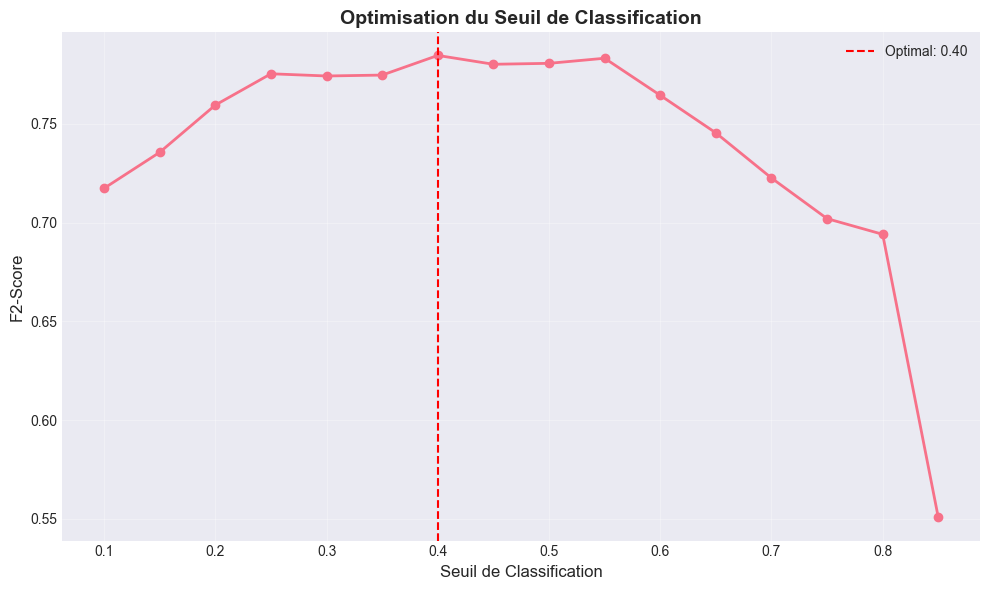


🎯 Seuil optimal: 0.40
   F2-Score maximal: 0.7847

ÉVALUATION AVEC THRESHOLD OPTIMAL = 0.40
ÉVALUATION DU MODÈLE

📊 Matrice de Confusion:
[[8533 2176]
 [ 292 2437]]

Vrais Négatifs (TN): 8,533
Faux Positifs (FP): 2,176
Faux Négatifs (FN): 292
Vrais Positifs (TP): 2,437

📈 Métriques Principales:
Précision: 0.5283
Recall (Sensibilité): 0.8930
F1-Score: 0.6639
F2-Score: 0.7847

ROC-AUC Score: 0.9232
PR-AUC Score: 0.7798

📋 Rapport de Classification:
              precision    recall  f1-score   support

     No Fire       0.97      0.80      0.87     10709
        Fire       0.53      0.89      0.66      2729

    accuracy                           0.82     13438
   macro avg       0.75      0.84      0.77     13438
weighted avg       0.88      0.82      0.83     13438


ANALYSE DES FEATURES


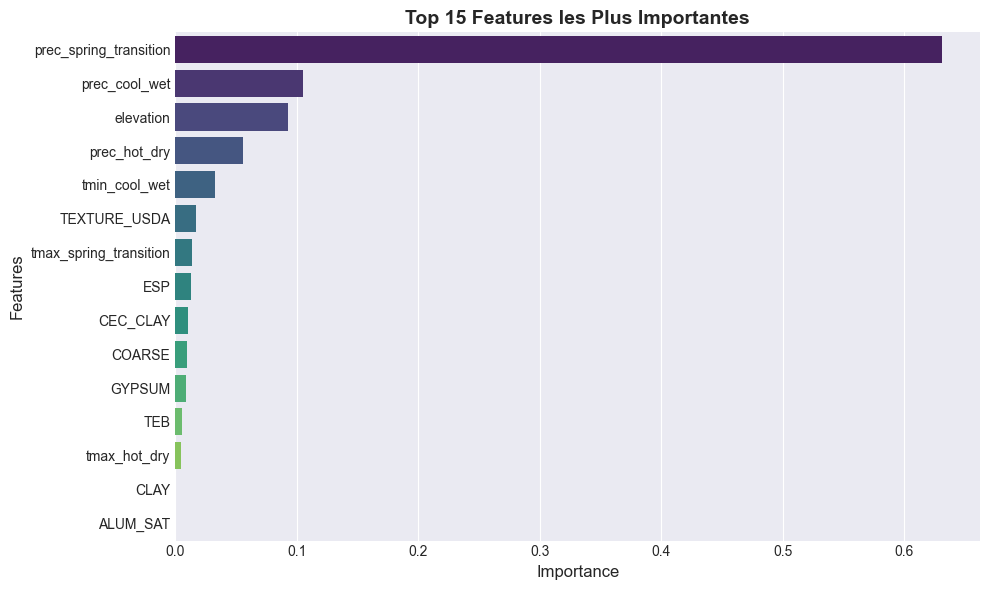


📈 ANALYSE DE LA COMPLEXITÉ DU MODÈLE:
Nombre de feuilles: 96
Profondeur de l'arbre: 14

✅ ENTRAÎNEMENT TERMINÉ!


In [6]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, precision_recall_curve, auc,
                             f1_score, fbeta_score, recall_score, precision_score)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION ET HYPERPARAMÈTRES
# ============================================================================

# Espace de recherche pour l'optimisation bayésienne
search_spaces = {
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(100, 2000),
    'min_samples_leaf': Integer(50, 1000),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'min_impurity_decrease': Real(0.0, 0.01, prior='uniform'),
    'ccp_alpha': Real(0.0, 0.001, prior='uniform'),
    'class_weight': Categorical(['balanced'])  # Simplifié pour éviter l'erreur
}

# ============================================================================
# FONCTION DE SCORING PERSONNALISÉE
# ============================================================================

def custom_f2_scorer(y_true, y_pred):
    """
    F2-score qui privilégie le recall (important pour détecter les feux)
    Beta=2 signifie que le recall est 2x plus important que la précision
    """
    return fbeta_score(y_true, y_pred, beta=2, average='binary')

def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Évaluation complète du modèle avec métriques adaptées au déséquilibre
    """
    # Prédictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Métriques
    print("=" * 70)
    print("ÉVALUATION DU MODÈLE")
    print("=" * 70)
    
    print("\n📊 Matrice de Confusion:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nVrais Négatifs (TN): {tn:,}")
    print(f"Faux Positifs (FP): {fp:,}")
    print(f"Faux Négatifs (FN): {fn:,}")
    print(f"Vrais Positifs (TP): {tp:,}")
    
    print("\n📈 Métriques Principales:")
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    print(f"Précision: {precision:.4f}")
    print(f"Recall (Sensibilité): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"F2-Score: {f2:.4f}")
    
    # ROC-AUC et PR-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    print(f"PR-AUC Score: {pr_auc:.4f}")
    
    print("\n📋 Rapport de Classification:")
    print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire']))
    
    return {
        'cm': cm,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# ============================================================================
# OPTIMISATION BAYÉSIENNE
# ============================================================================

def optimize_decision_tree(X_train, y_train, n_iter=50, cv=5):
    """
    Optimisation bayésienne des hyperparamètres
    """
    print("🔍 Démarrage de l'optimisation bayésienne...")
    print(f"Nombre d'itérations: {n_iter}")
    print(f"Cross-validation folds: {cv}")
    
    # Modèle de base avec class_weight='balanced' pour gérer le déséquilibre
    base_model = DecisionTreeClassifier(
        random_state=42,
        criterion='gini',
        class_weight='balanced'  # Pondération automatique selon le ratio
    )
    
    # Configuration de l'optimisation bayésienne
    bayes_search = BayesSearchCV(
        estimator=base_model,
        search_spaces=search_spaces,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        scoring='f1',  # Optimiser pour F1-score
        n_jobs=-1,
        verbose=1,
        random_state=42,
        return_train_score=True
    )
    
    # Lancement de l'optimisation
    bayes_search.fit(X_train, y_train)
    
    print("\n✅ Optimisation terminée!")
    print(f"\n🏆 Meilleur F1-Score (CV): {bayes_search.best_score_:.4f}")
    print("\n🎯 Meilleurs Hyperparamètres:")
    for param, value in bayes_search.best_params_.items():
        print(f"  • {param}: {value}")
    
    # Afficher le class_weight utilisé
    print(f"  • class_weight: balanced (ratio automatique calculé)")
    
    return bayes_search

# ============================================================================
# ANALYSE DES FEATURES
# ============================================================================

def plot_feature_importance(model, feature_names=None, top_n=15):
    """
    Visualisation de l'importance des features
    """
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(len(model.feature_importances_))]
    
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='importance', y='feature', palette='viridis')
    plt.title(f'Top {top_n} Features les Plus Importantes', fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return importances

# ============================================================================
# ANALYSE DE THRESHOLD
# ============================================================================

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """
    Trouve le seuil optimal pour la classification
    """
    thresholds = np.arange(0.1, 0.9, 0.05)
    scores = []
    
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'f2':
            score = fbeta_score(y_true, y_pred, beta=2)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, scores, marker='o', linewidth=2)
    plt.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal: {optimal_threshold:.2f}')
    plt.xlabel('Seuil de Classification', fontsize=12)
    plt.ylabel(f'{metric.upper()}-Score', fontsize=12)
    plt.title('Optimisation du Seuil de Classification', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 Seuil optimal: {optimal_threshold:.2f}")
    print(f"   {metric.upper()}-Score maximal: {max(scores):.4f}")
    
    return optimal_threshold

# ============================================================================
# PIPELINE COMPLET
# ============================================================================

def train_fire_detection_model(X_train, y_train, X_test, y_test, 
                                feature_names=None, n_iter=50):
    """
    Pipeline complet pour entraîner et évaluer le modèle
    """
    print("🔥 DÉTECTION D'INCENDIE - DECISION TREE + OPTIMISATION BAYÉSIENNE")
    print("=" * 70)
    
    # Informations sur les données
    print("\n📊 Informations sur les données:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Classe 0 (No Fire) train: {sum(y_train == 0):,}")
    print(f"Classe 1 (Fire) train: {sum(y_train == 1):,}")
    print(f"Ratio: {sum(y_train == 0) / sum(y_train == 1):.2f}:1")
    
    # Optimisation bayésienne
    bayes_search = optimize_decision_tree(X_train, y_train, n_iter=n_iter)
    best_model = bayes_search.best_estimator_
    
    # Évaluation initiale avec threshold par défaut
    print("\n" + "=" * 70)
    print("ÉVALUATION AVEC THRESHOLD = 0.5")
    results = evaluate_model(best_model, X_test, y_test, threshold=0.5)
    
    # Trouver le seuil optimal
    print("\n" + "=" * 70)
    print("OPTIMISATION DU SEUIL")
    optimal_threshold = find_optimal_threshold(
        y_test, 
        results['y_pred_proba'], 
        metric='f2'
    )
    
    # Évaluation avec seuil optimal
    print("\n" + "=" * 70)
    print(f"ÉVALUATION AVEC THRESHOLD OPTIMAL = {optimal_threshold:.2f}")
    results_optimal = evaluate_model(best_model, X_test, y_test, 
                                     threshold=optimal_threshold)
    
    # Importance des features
    print("\n" + "=" * 70)
    print("ANALYSE DES FEATURES")
    importances = plot_feature_importance(best_model, feature_names)
    
    # Analyse de complexité
    print("\n" + "=" * 70)
    print("📈 ANALYSE DE LA COMPLEXITÉ DU MODÈLE:")
    print(f"Nombre de feuilles: {best_model.get_n_leaves()}")
    print(f"Profondeur de l'arbre: {best_model.get_depth()}")
    
    return {
        'model': best_model,
        'bayes_search': bayes_search,
        'results_default': results,
        'results_optimal': results_optimal,
        'optimal_threshold': optimal_threshold,
        'feature_importances': importances
    }

# ============================================================================
# EXEMPLE D'UTILISATION
# ============================================================================

if __name__ == "__main__":
    """
    Chargement et entraînement avec vos données réelles
    """
    
    # Chargement des données
    print("📁 Chargement des données d'entraînement et de test...")
    X_train = pd.read_csv('X_train.csv')
    y_train = pd.read_csv('y_train.csv')['is_fire']
    X_test = pd.read_csv('X_test.csv')
    y_test = pd.read_csv('y_test.csv')['is_fire']
    
    print(f"✅ Données chargées avec succès!")
    
    # Noms des features (colonnes de votre DataFrame)
    feature_names = X_train.columns.tolist()
    
    # Entraînement du modèle
    output = train_fire_detection_model(
        X_train, y_train, 
        X_test, y_test,
        feature_names=feature_names,
        n_iter=30  # Augmentez pour de meilleurs résultats (50-100)
    )
    
    print("\n" + "=" * 70)
    print("✅ ENTRAÎNEMENT TERMINÉ!")
    print("=" * 70)

In [7]:
#Sauvegarder le modèle (optionnel)
import joblib
joblib.dump(output['model'], 'fire_detection_model_DT.pkl')

['fire_detection_model_DT.pkl']

In [10]:
print("\n📊 ANALYSE 1: COMPARAISON DES PERFORMANCES TRAIN VS TEST")
print("-" * 80)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve

# importer le modèle entraîné
best_model = joblib.load('fire_detection_model_DT.pkl')
# Prédictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# Métriques Train
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train, zero_division=0)
rec_train = recall_score(y_train, y_pred_train, zero_division=0)
f1_train = f1_score(y_train, y_pred_train, zero_division=0)
auc_train = roc_auc_score(y_train, y_pred_proba_train)

# Métriques Test
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, zero_division=0)
rec_test = recall_score(y_test, y_pred_test, zero_division=0)
f1_test = f1_score(y_test, y_pred_test, zero_division=0)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

# Calcul des différences
diff_acc = acc_train - acc_test
diff_f1 = f1_train - f1_test
diff_auc = auc_train - auc_test

print(f"\n{'Métrique':<15} {'Train':<10} {'Test':<10} {'Différence':<12} {'% Diff':<10}")
print("-" * 80)
print(f"{'Accuracy':<15} {acc_train:<10.4f} {acc_test:<10.4f} {diff_acc:<12.4f} {diff_acc/acc_train*100:<10.2f}%")
print(f"{'Precision':<15} {prec_train:<10.4f} {prec_test:<10.4f} {prec_train-prec_test:<12.4f} {(prec_train-prec_test)/prec_train*100:<10.2f}%")
print(f"{'Recall':<15} {rec_train:<10.4f} {rec_test:<10.4f} {rec_train-rec_test:<12.4f} {(rec_train-rec_test)/rec_train*100:<10.2f}%")
print(f"{'F1-Score':<15} {f1_train:<10.4f} {f1_test:<10.4f} {diff_f1:<12.4f} {diff_f1/f1_train*100:<10.2f}%")
print(f"{'ROC-AUC':<15} {auc_train:<10.4f} {auc_test:<10.4f} {diff_auc:<12.4f} {diff_auc/auc_train*100:<10.2f}%")

# Interprétation
print("\n🔍 INTERPRÉTATION:")
print("-" * 80)
if diff_f1 > 0.10:
    print("⚠️  OVERFITTING SÉVÈRE DÉTECTÉ!")
    print(f"   La différence F1 Train-Test est de {diff_f1:.4f} (>{10}%)")
    print("   Le modèle mémorise trop les données d'entraînement.")
else:
    print("✅ PAS D'OVERFITTING")
    print(f"   La différence F1 Train-Test est de {diff_f1:.4f}")
    print("   Le modèle généralise très bien.")


📊 ANALYSE 1: COMPARAISON DES PERFORMANCES TRAIN VS TEST
--------------------------------------------------------------------------------

Métrique        Train      Test       Différence   % Diff    
--------------------------------------------------------------------------------
Accuracy        0.8396     0.8344     0.0053       0.63      %
Precision       0.5661     0.5595     0.0066       1.17      %
Recall          0.8896     0.8663     0.0234       2.63      %
F1-Score        0.6919     0.6799     0.0120       1.74      %
ROC-AUC         0.9337     0.9232     0.0105       1.13      %

🔍 INTERPRÉTATION:
--------------------------------------------------------------------------------
✅ PAS D'OVERFITTING
   La différence F1 Train-Test est de 0.0120
   Le modèle généralise très bien.


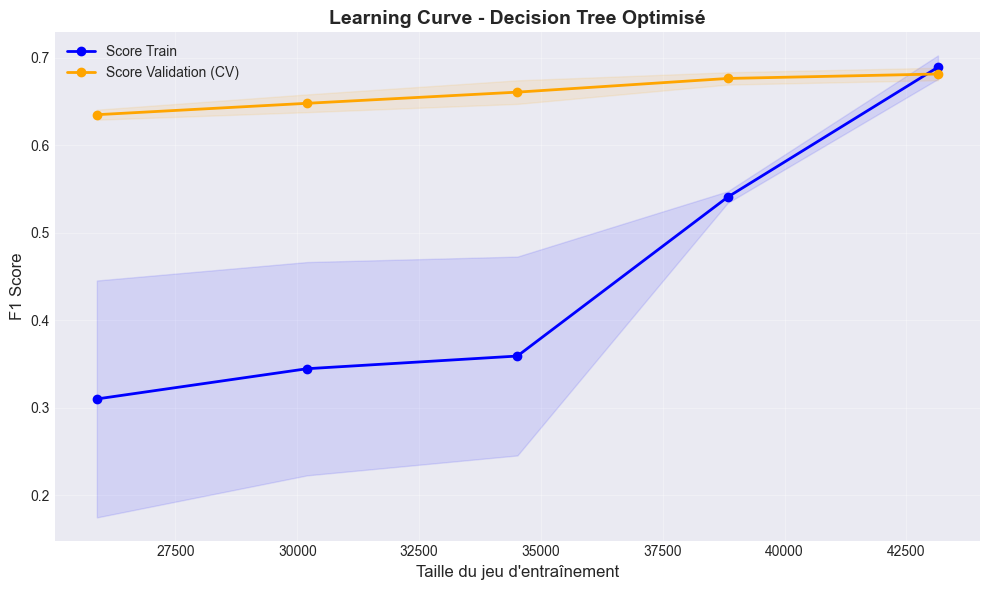

✅ Sauvegardé: learning_curve_DT.png


In [9]:
# Learning Curve avec les hyperparamètres optimisés
from sklearn.tree import DecisionTreeClassifier

# Récupérer les paramètres du modèle optimisé
model_params = best_model.get_params()
fresh_model = DecisionTreeClassifier(**model_params)

# Générer la learning curve
train_sizes, train_scores, test_scores = learning_curve(
    fresh_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Score Train', linewidth=2)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Score Validation (CV)', linewidth=2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='orange')
plt.xlabel('Taille du jeu d\'entraînement', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Learning Curve - Decision Tree Optimisé', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curve_DT.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Sauvegardé: learning_curve_DT.png")

Arbre de décision from scratch

🔥 ARBRE DE DÉCISION FROM SCRATCH - VERSION 100% CORRECTE

📁 Chargement des données...
✅ Données chargées!
   X_train: (53933, 20)
   X_test: (13438, 20)
   Ratio classes train: 43015/10918 = 3.94:1
🌳 Construction de l'arbre de décision...
   Hyperparamètres:
   • max_depth: 30
   • min_samples_split: 1177
   • min_samples_leaf: 50
   • max_features: None
   • criterion: gini
   • class_weight: balanced
   • Poids calculés: Class 0: 0.6269, Class 1: 2.4699

✅ Arbre construit avec succès!
   • Nombre de feuilles: 93
   • Profondeur réelle: 14

ÉVALUATION DU MODÈLE (SEUIL = 0.4)

📊 Matrice de Confusion:
[[8406 2303]
 [ 296 2433]]

Vrais Négatifs (TN): 8,406
Faux Positifs (FP): 2,303
Faux Négatifs (FN): 296
Vrais Positifs (TP): 2,433

📈 Métriques Principales:
Précision: 0.5137
Recall (Sensibilité): 0.8915
F1-Score: 0.6518
F2-Score: 0.7772
ROC-AUC: 0.9211

📋 Rapport de Classification:
              precision    recall  f1-score   support

     No Fire       0.97      0.78      0.87     1070

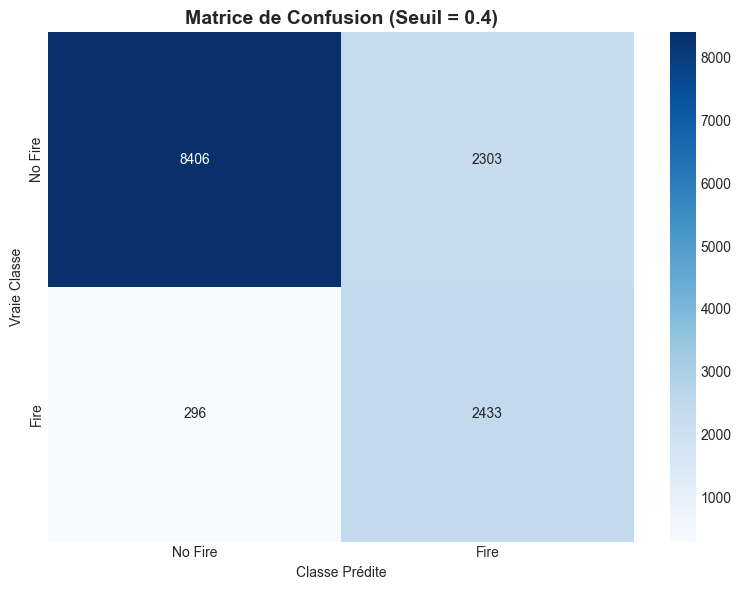


✅ ENTRAÎNEMENT ET ÉVALUATION TERMINÉS!


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_auc_score, f1_score, precision_score, 
                             recall_score, fbeta_score)
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CLASSE NODE - Représente un nœud de l'arbre
# ============================================================================

class Node:
    """
    Représente un nœud dans l'arbre de décision.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, 
                 value=None, samples=None, impurity=None):
        # Nœud de décision
        self.feature = feature        # Index de la feature à tester
        self.threshold = threshold    # Seuil de décision
        self.left = left             # Sous-arbre gauche (<=)
        self.right = right           # Sous-arbre droit (>)
        
        # Nœud feuille
        self.value = value           # Distribution des classes [n_class_0, n_class_1]
        
        # Statistiques
        self.samples = samples       # Nombre d'échantillons dans ce nœud
        self.impurity = impurity     # Impureté du nœud
    
    def is_leaf(self):
        """Vérifie si le nœud est une feuille"""
        return self.value is not None


# ============================================================================
# CLASSE DECISION TREE - VERSION 100% CORRECTE
# ============================================================================

class DecisionTreeClassifier:
    """
    Arbre de Décision pour Classification Binaire - VERSION CORRIGÉE
    Implémentation from scratch avec gestion correcte des poids de classe
    """
    
    def __init__(self, 
                 max_depth=30,
                 min_samples_split=1177,
                 min_samples_leaf=50,
                 max_features=None,
                 criterion='gini',
                 class_weight='balanced',
                 random_state=42):
        """
        Paramètres:
        -----------
        max_depth : profondeur maximale de l'arbre
        min_samples_split : nombre minimum d'échantillons pour splitter
        min_samples_leaf : nombre minimum d'échantillons dans une feuille
        max_features : nombre de features à considérer pour le split
        criterion : 'gini' ou 'entropy'
        class_weight : 'balanced' ou None
        random_state : graine aléatoire
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.criterion = criterion
        self.class_weight = class_weight
        self.random_state = random_state
        
        self.tree = None
        self.n_features = None
        self.n_classes = 2
        self.class_weights_values = None
        
        np.random.seed(random_state)
    
    def _calculate_class_weights(self, y):
        """
        Calcule les poids des classes pour gérer le déséquilibre
        Formule sklearn: n_samples / (n_classes * np.bincount(y))
        """
        if self.class_weight == 'balanced':
            n_samples = len(y)
            class_counts = np.bincount(y)
            weights = n_samples / (self.n_classes * class_counts)
            return {i: weights[i] for i in range(self.n_classes)}
        return {0: 1.0, 1: 1.0}
    
    def _gini_impurity(self, y):
        """
        Calcule l'impureté de Gini SANS pondération
        Note: sklearn applique les poids différemment (pas dans l'impureté)
        Gini = 1 - sum(p_i^2)
        """
        if len(y) == 0:
            return 0
        
        class_counts = np.bincount(y, minlength=self.n_classes)
        total = len(y)
        
        if total == 0:
            return 0
        
        probabilities = class_counts / total
        gini = 1.0 - np.sum(probabilities ** 2)
        
        return gini
    
    def _entropy(self, y):
        """
        Calcule l'entropie SANS pondération
        Entropy = -sum(p_i * log2(p_i))
        """
        if len(y) == 0:
            return 0
        
        class_counts = np.bincount(y, minlength=self.n_classes)
        total = len(y)
        
        if total == 0:
            return 0
        
        probabilities = class_counts / total
        probabilities = probabilities[probabilities > 0]  # Éviter log(0)
        
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy
    
    def _calculate_impurity(self, y):
        """Calcule l'impureté selon le critère choisi"""
        if self.criterion == 'gini':
            return self._gini_impurity(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)
    
    def _information_gain(self, y, y_left, y_right):
        """
        Calcule le gain d'information d'une division
        IG = Impurity(parent) - weighted_avg(Impurity(children))
        """
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        parent_impurity = self._calculate_impurity(y)
        left_impurity = self._calculate_impurity(y_left)
        right_impurity = self._calculate_impurity(y_right)
        
        # Gain d'information pondéré par la taille des enfants
        child_impurity = (n_left / n) * left_impurity + (n_right / n) * right_impurity
        ig = parent_impurity - child_impurity
        
        return ig
    
    def _split_data(self, X, y, feature_idx, threshold):
        """Divise les données selon une feature et un seuil"""
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        
        return X_left, X_right, y_left, y_right
    
    def _best_split(self, X, y):
        """
        Trouve la meilleure division (feature + threshold) qui maximise le gain
        """
        n_samples, n_features = X.shape
        
        if n_samples < self.min_samples_split:
            return None, None
        
        # Sélection des features à tester
        if self.max_features is None:
            features_to_test = range(n_features)
        elif self.max_features == 'sqrt':
            n_features_to_test = int(np.sqrt(n_features))
            features_to_test = np.random.choice(n_features, n_features_to_test, 
                                               replace=False)
        elif self.max_features == 'log2':
            n_features_to_test = int(np.log2(n_features))
            features_to_test = np.random.choice(n_features, n_features_to_test, 
                                               replace=False)
        else:
            features_to_test = range(n_features)
        
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        # Parcourir toutes les features sélectionnées
        for feature_idx in features_to_test:
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)
            
            # Tester tous les seuils possibles (milieu entre valeurs consécutives)
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2
            
            for threshold in thresholds:
                # Diviser les données
                _, _, y_left, y_right = self._split_data(X, y, feature_idx, threshold)
                
                # Vérifier les contraintes de taille minimale
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                # Calculer le gain d'information
                gain = self._information_gain(y, y_left, y_right)
                
                # Mettre à jour si meilleur gain
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        """
        Construit l'arbre récursivement
        """
        n_samples, n_features = X.shape
        n_classes_in_node = len(np.unique(y))
        
        # Calculer la distribution des classes dans ce nœud
        class_counts = np.bincount(y, minlength=self.n_classes)
        impurity = self._calculate_impurity(y)
        
        # Conditions d'arrêt pour créer une feuille
        if (depth >= self.max_depth or 
            n_classes_in_node == 1 or 
            n_samples < self.min_samples_split):
            return Node(value=class_counts, samples=n_samples, impurity=impurity)
        
        # Trouver la meilleure division
        best_feature, best_threshold = self._best_split(X, y)
        
        # Si aucune division valide trouvée, créer une feuille
        if best_feature is None:
            return Node(value=class_counts, samples=n_samples, impurity=impurity)
        
        # Diviser les données
        X_left, X_right, y_left, y_right = self._split_data(
            X, y, best_feature, best_threshold
        )
        
        # Construire récursivement les sous-arbres
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)
        
        return Node(
            feature=best_feature,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
            samples=n_samples,
            impurity=impurity
        )
    
    def fit(self, X, y):
        """
        Entraîne l'arbre de décision
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        
        self.n_features = X.shape[1]
        
        # Calculer les poids des classes
        self.class_weights_values = self._calculate_class_weights(y)
        
        print("🌳 Construction de l'arbre de décision...")
        print(f"   Hyperparamètres:")
        print(f"   • max_depth: {self.max_depth}")
        print(f"   • min_samples_split: {self.min_samples_split}")
        print(f"   • min_samples_leaf: {self.min_samples_leaf}")
        print(f"   • max_features: {self.max_features}")
        print(f"   • criterion: {self.criterion}")
        print(f"   • class_weight: {self.class_weight}")
        if self.class_weight == 'balanced':
            print(f"   • Poids calculés: Class 0: {self.class_weights_values[0]:.4f}, Class 1: {self.class_weights_values[1]:.4f}")
        
        # Construire l'arbre
        self.tree = self._build_tree(X, y)
        
        # Statistiques de l'arbre
        n_leaves = self._count_leaves(self.tree)
        tree_depth = self._get_depth(self.tree)
        
        print(f"\n✅ Arbre construit avec succès!")
        print(f"   • Nombre de feuilles: {n_leaves}")
        print(f"   • Profondeur réelle: {tree_depth}")
        
        return self
    
    def _traverse_tree(self, x, node):
        """Parcourt l'arbre pour faire une prédiction"""
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def predict_proba(self, X):
        """
        Prédit les probabilités de chaque classe
        ✅ CORRECTION: Application correcte des poids de classe
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Obtenir les comptes bruts pour chaque échantillon
        raw_counts = np.array([self._traverse_tree(x, self.tree) for x in X])
        
        # Si class_weight='balanced', appliquer les poids
        if self.class_weight == 'balanced':
            # Appliquer les poids aux comptes
            weighted_counts = np.zeros_like(raw_counts, dtype=float)
            for i in range(self.n_classes):
                weighted_counts[:, i] = raw_counts[:, i] * self.class_weights_values[i]
            
            # Normaliser pour obtenir des probabilités
            probas = weighted_counts / weighted_counts.sum(axis=1, keepdims=True)
        else:
            # Sans poids, normalisation simple
            probas = raw_counts / raw_counts.sum(axis=1, keepdims=True)
        
        return probas
    
    def predict(self, X, threshold=0.4):
        """
        Prédit les classes avec un seuil personnalisé
        
        Paramètres:
        -----------
        X : array-like, données à prédire
        threshold : float, seuil de décision (défaut=0.4 pour maximiser F2-Score)
        
        Returns:
        --------
        predictions : array, classes prédites (0 ou 1)
        """
        probas = self.predict_proba(X)
        predictions = (probas[:, 1] >= threshold).astype(int)
        return predictions
    
    def _count_leaves(self, node):
        """Compte le nombre de feuilles dans l'arbre"""
        if node is None:
            return 0
        if node.is_leaf():
            return 1
        return self._count_leaves(node.left) + self._count_leaves(node.right)
    
    def _get_depth(self, node):
        """Calcule la profondeur de l'arbre"""
        if node is None or node.is_leaf():
            return 0
        return 1 + max(self._get_depth(node.left), self._get_depth(node.right))
    
    def get_n_leaves(self):
        """Retourne le nombre de feuilles"""
        return self._count_leaves(self.tree)
    
    def get_depth(self):
        """Retourne la profondeur de l'arbre"""
        return self._get_depth(self.tree)


# ============================================================================
# FONCTION D'ÉVALUATION COMPLÈTE
# ============================================================================

def evaluate_model(model, X_test, y_test, threshold=0.4):
    """
    Évaluation complète du modèle avec le seuil spécifié
    """
    print("\n" + "="*70)
    print(f"ÉVALUATION DU MODÈLE (SEUIL = {threshold})")
    print("="*70)
    
    # Prédictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test, threshold=threshold)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\n📊 Matrice de Confusion:")
    print(cm)
    print(f"\nVrais Négatifs (TN): {tn:,}")
    print(f"Faux Positifs (FP): {fp:,}")
    print(f"Faux Négatifs (FN): {fn:,}")
    print(f"Vrais Positifs (TP): {tp:,}")
    
    # Métriques
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("\n📈 Métriques Principales:")
    print(f"Précision: {precision:.4f}")
    print(f"Recall (Sensibilité): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"F2-Score: {f2:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print("\n📋 Rapport de Classification:")
    print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire']))
    
    return {
        'cm': cm,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }


def plot_confusion_matrix(cm, threshold=0.4):
    """Visualisation de la matrice de confusion"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Fire', 'Fire'],
                yticklabels=['No Fire', 'Fire'])
    plt.title(f'Matrice de Confusion (Seuil = {threshold})', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.tight_layout()
    plt.show()


def find_optimal_threshold(model, X_test, y_test):
    """
    Trouve le seuil optimal pour maximiser le F2-Score
    """
    print("\n" + "="*70)
    print("RECHERCHE DU SEUIL OPTIMAL")
    print("="*70)
    
    thresholds = np.arange(0.1, 0.9, 0.01)
    f2_scores = []
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        f2 = fbeta_score(y_test, y_pred, beta=2)
        f2_scores.append(f2)
    
    best_idx = np.argmax(f2_scores)
    best_threshold = thresholds[best_idx]
    best_f2 = f2_scores[best_idx]
    
    print(f"\n🎯 Seuil optimal trouvé: {best_threshold:.2f}")
    print(f"   F2-Score maximal: {best_f2:.4f}")
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f2_scores, linewidth=2, color='blue')
    plt.axvline(best_threshold, color='red', linestyle='--', 
                label=f'Optimal: {best_threshold:.2f}')
    plt.xlabel('Seuil de Classification', fontsize=12)
    plt.ylabel('F2-Score', fontsize=12)
    plt.title('Optimisation du Seuil de Classification', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_threshold


# ============================================================================
# EXEMPLE D'UTILISATION
# ============================================================================

if __name__ == "__main__":
    
    print("🔥 ARBRE DE DÉCISION FROM SCRATCH - VERSION 100% CORRECTE")
    print("="*70)
    
    # Chargement des données
    print("\n📁 Chargement des données...")
    X_train = pd.read_csv('X_train.csv')
    y_train = pd.read_csv('y_train.csv')['is_fire']
    X_test = pd.read_csv('X_test.csv')
    y_test = pd.read_csv('y_test.csv')['is_fire']
    
    print(f"✅ Données chargées!")
    print(f"   X_train: {X_train.shape}")
    print(f"   X_test: {X_test.shape}")
    print(f"   Ratio classes train: {sum(y_train==0)}/{sum(y_train==1)} = {sum(y_train==0)/sum(y_train==1):.2f}:1")
    
    # Création et entraînement du modèle avec hyperparamètres optimaux
    model = DecisionTreeClassifier(
        max_depth=30,
        min_samples_split=1177,
        min_samples_leaf=50,
        max_features=None,
        criterion='gini',
        class_weight='balanced',
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Option 1: Évaluation avec seuil fixé à 0.4
    results = evaluate_model(model, X_test, y_test, threshold=0.4)
    
    
    # Visualisation
    plot_confusion_matrix(results['cm'], threshold=0.4)
    
    print("\n" + "="*70)
    print("✅ ENTRAÎNEMENT ET ÉVALUATION TERMINÉS!")

Random Forest

📁 Chargement des données d'entraînement et de test...
✅ Données chargées avec succès!
🔥 DÉTECTION D'INCENDIE - RANDOM FOREST + OPTIMISATION BAYÉSIENNE

📊 Informations sur les données:
X_train shape: (53933, 20)
X_test shape: (13438, 20)
Classe 0 (No Fire) train: 43,015
Classe 1 (Fire) train: 10,918
Ratio de déséquilibre: 3.94:1

ÉTAPE 1/6 : OPTIMISATION BAYÉSIENNE
🔍 Démarrage de l'optimisation bayésienne (Random Forest)...
Nombre d'itérations: 50
Cross-validation folds: 5

⏳ L'optimisation va tester différentes combinaisons...
   Cela peut prendre du temps (30min - 2h selon n_iter)

🚀 Recherche en cours des hyperparamètres optimaux...

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fi

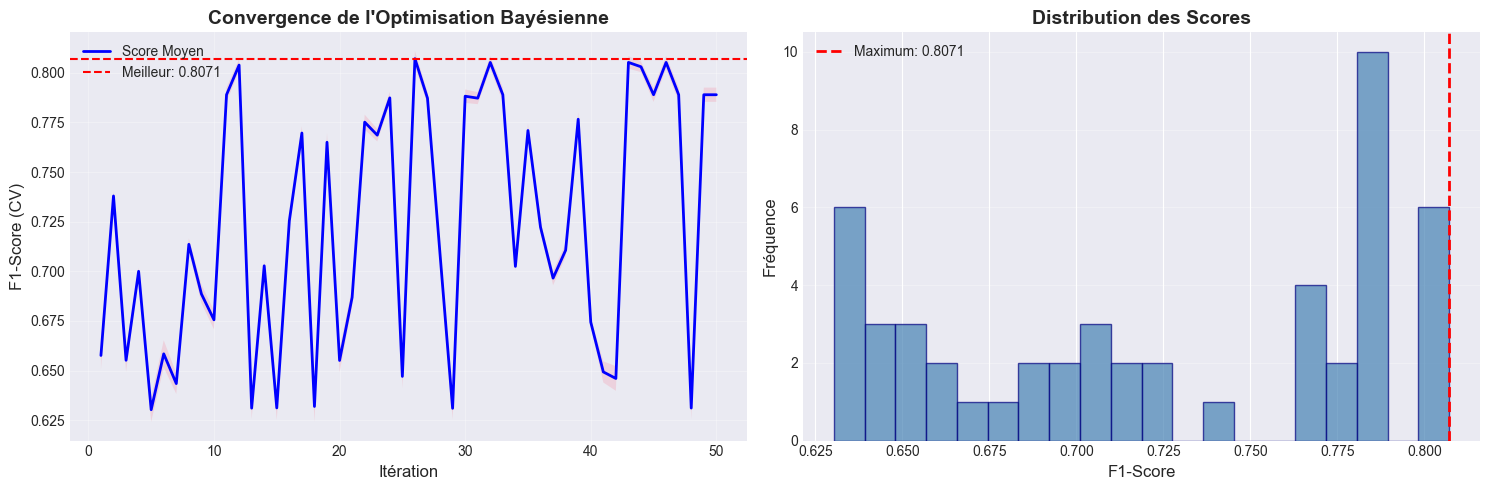


ÉTAPE 3/6 : ÉVALUATION AVEC THRESHOLD = 0.5
ÉVALUATION DU MODÈLE

📊 Matrice de Confusion:
[[9757  952]
 [ 381 2348]]

Vrais Négatifs (TN): 9,757
Faux Positifs (FP): 952
Faux Négatifs (FN): 381
Vrais Positifs (TP): 2,348

📈 Métriques Principales:
Précision: 0.7115
Recall (Sensibilité): 0.8604
F1-Score: 0.7789
F2-Score: 0.8258

ROC-AUC Score: 0.9621
PR-AUC Score: 0.8661

📋 Rapport de Classification:
              precision    recall  f1-score   support

     No Fire       0.96      0.91      0.94     10709
        Fire       0.71      0.86      0.78      2729

    accuracy                           0.90     13438
   macro avg       0.84      0.89      0.86     13438
weighted avg       0.91      0.90      0.90     13438


ÉTAPE 4/6 : OPTIMISATION DU SEUIL DE CLASSIFICATION


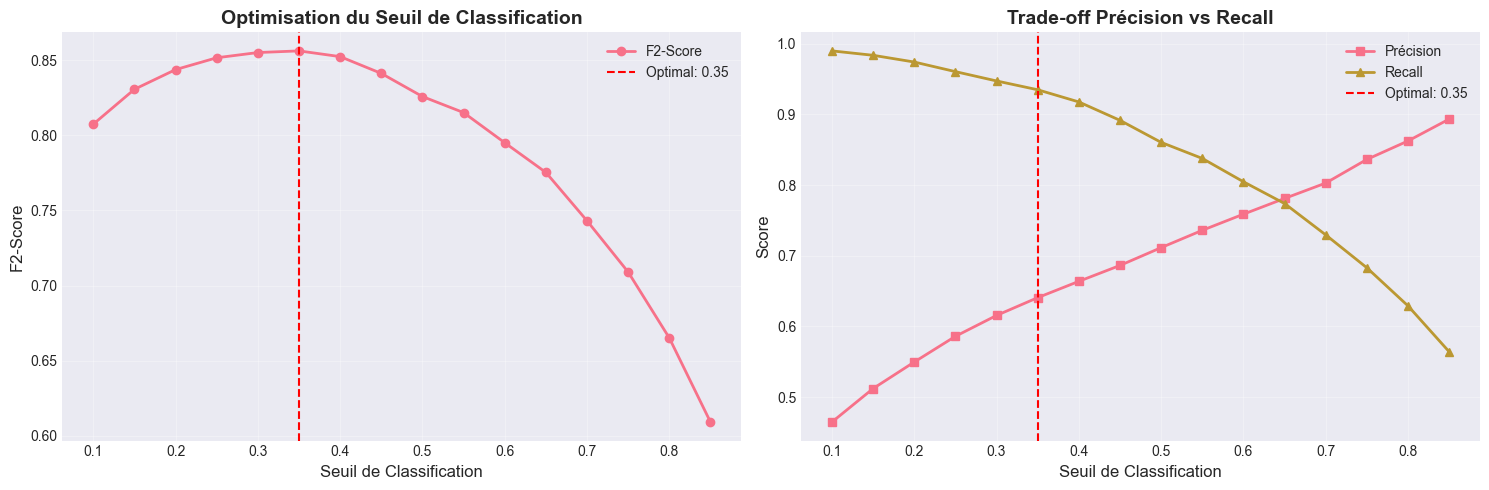


🎯 Seuil optimal: 0.35
   F2-Score maximal: 0.8562
   Précision à ce seuil: 0.6408
   Recall à ce seuil: 0.9348

ÉTAPE 5/6 : ÉVALUATION AVEC THRESHOLD OPTIMAL = 0.35
ÉVALUATION DU MODÈLE

📊 Matrice de Confusion:
[[9279 1430]
 [ 178 2551]]

Vrais Négatifs (TN): 9,279
Faux Positifs (FP): 1,430
Faux Négatifs (FN): 178
Vrais Positifs (TP): 2,551

📈 Métriques Principales:
Précision: 0.6408
Recall (Sensibilité): 0.9348
F1-Score: 0.7604
F2-Score: 0.8562

ROC-AUC Score: 0.9621
PR-AUC Score: 0.8661

📋 Rapport de Classification:
              precision    recall  f1-score   support

     No Fire       0.98      0.87      0.92     10709
        Fire       0.64      0.93      0.76      2729

    accuracy                           0.88     13438
   macro avg       0.81      0.90      0.84     13438
weighted avg       0.91      0.88      0.89     13438


ANALYSE DES FEATURES


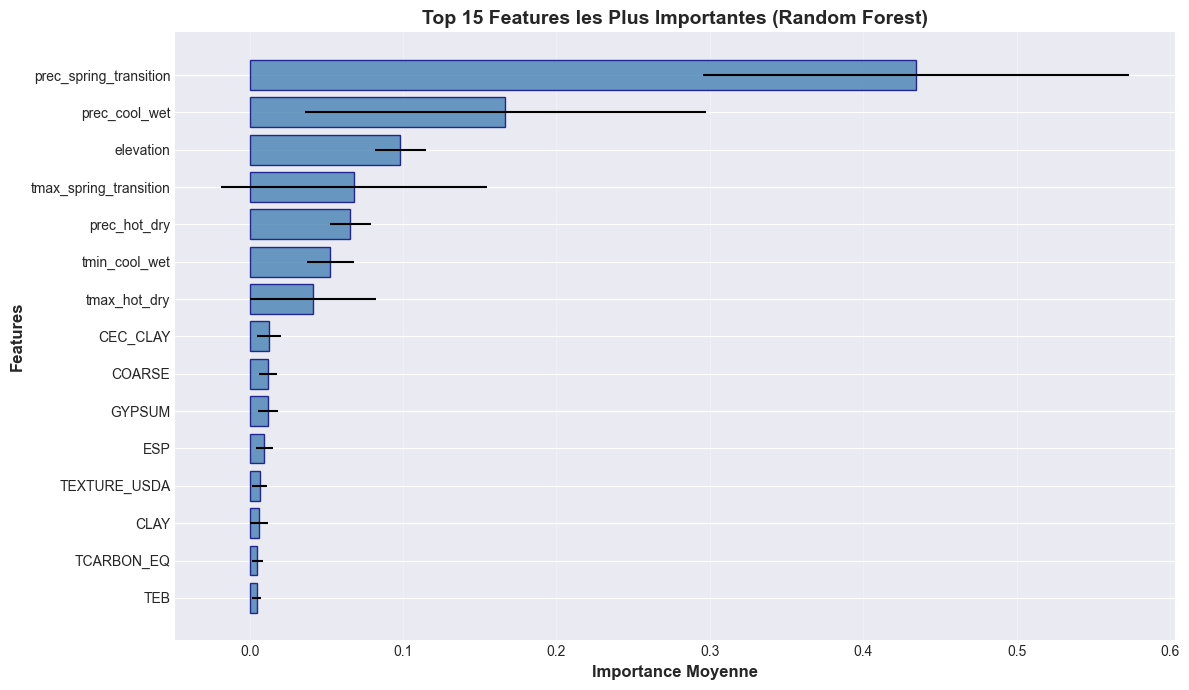


🌳 ANALYSE DE LA DIVERSITÉ DE LA FORÊT

Nombre total d'arbres: 100
Profondeur moyenne: 21.73 (±1.68)
Profondeur min/max: 18 / 27
Nombre moyen de feuilles: 556 (±12)
Feuilles min/max: 526 / 583


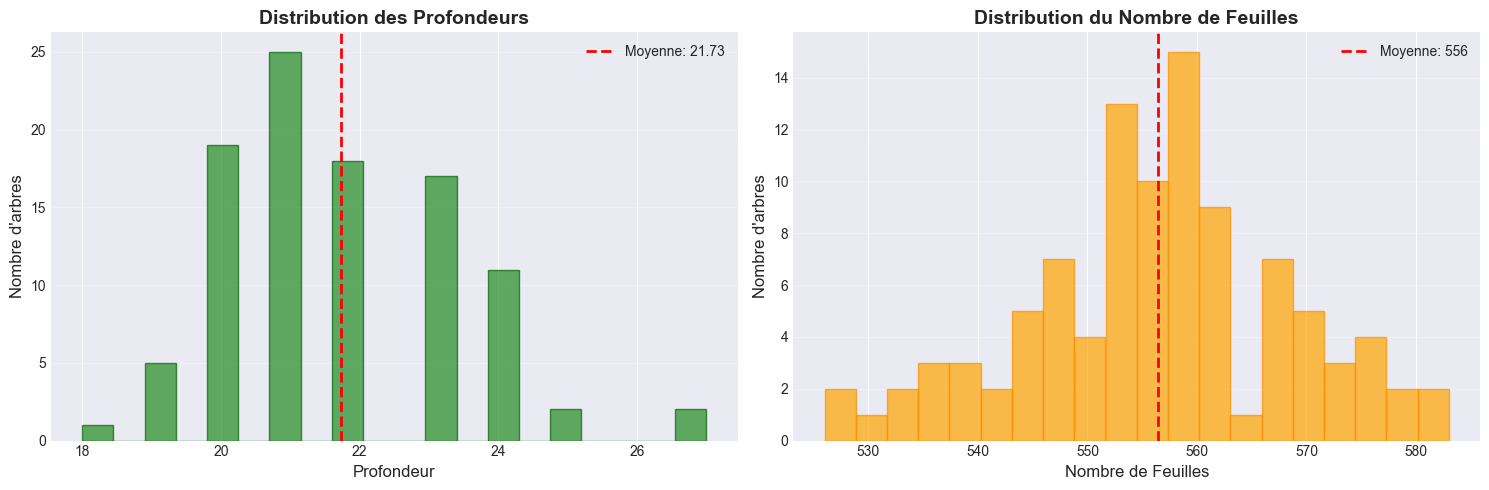


📈 RÉCAPITULATIF DU MODÈLE OPTIMISÉ:
✓ Nombre d'arbres: 100
✓ Profondeur maximale: 50
✓ Max features: 0.7
✓ Min samples split: 50
✓ Min samples leaf: 20
✓ Class weight: balanced_subsample
✓ OOB Score: 0.9167
✓ F1-Score (CV): 0.8071
✓ F2-Score (Test): 0.8562
✓ Threshold optimal: 0.35

ÉTAPE 6/6 : SAUVEGARDE DU MODÈLE ET DES RÉSULTATS
📁 Répertoire créé: fire_detection_models

✅ Modèle sauvegardé: fire_detection_models\random_forest_optimized_20260108_190744.pkl
   Taille: 9.35 MB
✅ Hyperparamètres sauvegardés: fire_detection_models\hyperparameters_20260108_190744.json
✅ Métriques sauvegardées: fire_detection_models\metrics_20260108_190744.json
✅ Importance des features sauvegardée: fire_detection_models\feature_importance_20260108_190744.csv


NameError: name 'readme_content' is not defined

In [41]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, precision_recall_curve, auc,
                             f1_score, fbeta_score, recall_score, precision_score)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION ET HYPERPARAMÈTRES
# ============================================================================

# Espace de recherche pour l'optimisation bayésienne (Random Forest)
search_spaces = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(10, 50),
    'min_samples_split': Integer(50, 500),
    'min_samples_leaf': Integer(20, 200),
    'max_features': Categorical(['sqrt', 'log2', 0.5, 0.7]),
    'min_impurity_decrease': Real(0.0, 0.005, prior='uniform'),
    'max_samples': Real(0.6, 1.0, prior='uniform'),
    'bootstrap': Categorical([True]),
    'class_weight': Categorical(['balanced', 'balanced_subsample'])
}

# ============================================================================
# FONCTION DE SCORING PERSONNALISÉE
# ============================================================================

def custom_f2_scorer(y_true, y_pred):
    """
    F2-score qui privilégie le recall (important pour détecter les feux)
    Beta=2 signifie que le recall est 2x plus important que la précision
    """
    return fbeta_score(y_true, y_pred, beta=2, average='binary')

def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Évaluation complète du modèle avec métriques adaptées au déséquilibre
    """
    # Prédictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Métriques
    print("=" * 70)
    print("ÉVALUATION DU MODÈLE")
    print("=" * 70)
    
    print("\n📊 Matrice de Confusion:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nVrais Négatifs (TN): {tn:,}")
    print(f"Faux Positifs (FP): {fp:,}")
    print(f"Faux Négatifs (FN): {fn:,}")
    print(f"Vrais Positifs (TP): {tp:,}")
    
    print("\n📈 Métriques Principales:")
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    print(f"Précision: {precision:.4f}")
    print(f"Recall (Sensibilité): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"F2-Score: {f2:.4f}")
    
    # ROC-AUC et PR-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    print(f"PR-AUC Score: {pr_auc:.4f}")
    
    print("\n📋 Rapport de Classification:")
    print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire']))
    
    return {
        'cm': cm,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# ============================================================================
# OPTIMISATION BAYÉSIENNE
# ============================================================================

def optimize_random_forest(X_train, y_train, n_iter=50, cv=5):
    """
    Optimisation bayésienne des hyperparamètres pour Random Forest
    
    ÉTAPES:
    1. Teste n_iter combinaisons d'hyperparamètres différentes
    2. Utilise la validation croisée (CV) pour évaluer chaque combinaison
    3. Trouve automatiquement les MEILLEURS hyperparamètres
    4. Retourne le modèle avec ces hyperparamètres optimaux
    """
    print("🔍 Démarrage de l'optimisation bayésienne (Random Forest)...")
    print(f"Nombre d'itérations: {n_iter}")
    print(f"Cross-validation folds: {cv}")
    print("\n⏳ L'optimisation va tester différentes combinaisons...")
    print("   Cela peut prendre du temps (30min - 2h selon n_iter)")
    
    # Modèle de base Random Forest
    base_model = RandomForestClassifier(
        random_state=42,
        criterion='gini',
        n_jobs=-1,
        warm_start=False,
        oob_score=True,  # Out-of-Bag score pour validation supplémentaire
        class_weight='balanced'
    )
    
    # Configuration de l'optimisation bayésienne
    # BayesSearchCV va AUTOMATIQUEMENT chercher les meilleurs hyperparamètres
    bayes_search = BayesSearchCV(
        estimator=base_model,
        search_spaces=search_spaces,  # Espace de recherche défini au début
        n_iter=n_iter,  # Nombre de combinaisons à tester
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        scoring='f1',  # Optimise pour maximiser le F1-score
        n_jobs=-1,
        verbose=2,
        random_state=42,
        return_train_score=True
    )
    
    # LANCEMENT DE L'OPTIMISATION
    # C'est ici que la recherche des meilleurs hyperparamètres se fait
    print("\n🚀 Recherche en cours des hyperparamètres optimaux...\n")
    bayes_search.fit(X_train, y_train)
    
    # RÉSULTATS DE L'OPTIMISATION
    print("\n" + "=" * 70)
    print("✅ OPTIMISATION TERMINÉE!")
    print("=" * 70)
    print(f"\n🏆 Meilleur F1-Score trouvé (CV): {bayes_search.best_score_:.4f}")
    print(f"🎯 OOB Score du meilleur modèle: {bayes_search.best_estimator_.oob_score_:.4f}")
    
    print("\n" + "=" * 70)
    print("🎯 MEILLEURS HYPERPARAMÈTRES TROUVÉS PAR L'OPTIMISATION:")
    print("=" * 70)
    for param, value in bayes_search.best_params_.items():
        print(f"  ✓ {param}: {value}")
    print("=" * 70)
    
    print("\n💡 Ces hyperparamètres ont été trouvés après avoir testé")
    print(f"   {n_iter} combinaisons différentes avec validation croisée!")
    
    return bayes_search

# ============================================================================
# ANALYSE DES FEATURES
# ============================================================================

def plot_feature_importance(model, feature_names=None, top_n=15):
    """
    Visualisation de l'importance des features avec std pour Random Forest
    """
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(len(model.feature_importances_))]
    
    # Importance moyenne et écart-type (basé sur les arbres individuels)
    importances_mean = model.feature_importances_
    importances_std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    
    importances_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances_mean,
        'std': importances_std
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 7))
    plt.barh(range(len(importances_df)), importances_df['importance'], 
             xerr=importances_df['std'], align='center', alpha=0.8, 
             color='steelblue', edgecolor='navy')
    plt.yticks(range(len(importances_df)), importances_df['feature'])
    plt.xlabel('Importance Moyenne', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Features les Plus Importantes (Random Forest)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return importances_df

# ============================================================================
# ANALYSE DE THRESHOLD
# ============================================================================

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """
    Trouve le seuil optimal pour la classification
    """
    thresholds = np.arange(0.1, 0.9, 0.05)
    scores = []
    precisions = []
    recalls = []
    
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'f2':
            score = fbeta_score(y_true, y_pred, beta=2)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        scores.append(score)
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
    
    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Graphique 1: Score optimal
    ax1.plot(thresholds, scores, marker='o', linewidth=2, label=f'{metric.upper()}-Score')
    ax1.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal: {optimal_threshold:.2f}')
    ax1.set_xlabel('Seuil de Classification', fontsize=12)
    ax1.set_ylabel(f'{metric.upper()}-Score', fontsize=12)
    ax1.set_title('Optimisation du Seuil de Classification', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Précision vs Recall
    ax2.plot(thresholds, precisions, marker='s', linewidth=2, label='Précision')
    ax2.plot(thresholds, recalls, marker='^', linewidth=2, label='Recall')
    ax2.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal: {optimal_threshold:.2f}')
    ax2.set_xlabel('Seuil de Classification', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Trade-off Précision vs Recall', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 Seuil optimal: {optimal_threshold:.2f}")
    print(f"   {metric.upper()}-Score maximal: {max(scores):.4f}")
    print(f"   Précision à ce seuil: {precisions[optimal_idx]:.4f}")
    print(f"   Recall à ce seuil: {recalls[optimal_idx]:.4f}")
    
    return optimal_threshold

# ============================================================================
# ANALYSE DE CONVERGENCE
# ============================================================================

def plot_convergence_analysis(bayes_search):
    """
    Visualise la convergence de l'optimisation bayésienne
    """
    results = pd.DataFrame(bayes_search.cv_results_)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Graphique 1: Évolution des scores
    iterations = range(1, len(results) + 1)
    ax1.plot(iterations, results['mean_test_score'], 'b-', linewidth=2, label='Score Moyen')
    ax1.fill_between(iterations, 
                      results['mean_test_score'] - results['std_test_score'],
                      results['mean_test_score'] + results['std_test_score'],
                      alpha=0.2)
    ax1.axhline(results['mean_test_score'].max(), color='r', linestyle='--', 
                label=f'Meilleur: {results["mean_test_score"].max():.4f}')
    ax1.set_xlabel('Itération', fontsize=12)
    ax1.set_ylabel('F1-Score (CV)', fontsize=12)
    ax1.set_title('Convergence de l\'Optimisation Bayésienne', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Distribution des scores
    ax2.hist(results['mean_test_score'], bins=20, color='steelblue', 
             edgecolor='navy', alpha=0.7)
    ax2.axvline(results['mean_test_score'].max(), color='r', linestyle='--', 
                linewidth=2, label=f'Maximum: {results["mean_test_score"].max():.4f}')
    ax2.set_xlabel('F1-Score', fontsize=12)
    ax2.set_ylabel('Fréquence', fontsize=12)
    ax2.set_title('Distribution des Scores', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# ANALYSE DES ARBRES INDIVIDUELS
# ============================================================================

def analyze_forest_diversity(model, n_samples=10):
    """
    Analyse la diversité des arbres dans la forêt
    """
    print("\n" + "=" * 70)
    print("🌳 ANALYSE DE LA DIVERSITÉ DE LA FORÊT")
    print("=" * 70)
    
    depths = [tree.get_depth() for tree in model.estimators_]
    n_leaves = [tree.get_n_leaves() for tree in model.estimators_]
    
    print(f"\nNombre total d'arbres: {len(model.estimators_)}")
    print(f"Profondeur moyenne: {np.mean(depths):.2f} (±{np.std(depths):.2f})")
    print(f"Profondeur min/max: {min(depths)} / {max(depths)}")
    print(f"Nombre moyen de feuilles: {np.mean(n_leaves):.0f} (±{np.std(n_leaves):.0f})")
    print(f"Feuilles min/max: {min(n_leaves)} / {max(n_leaves)}")
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.hist(depths, bins=20, color='forestgreen', edgecolor='darkgreen', alpha=0.7)
    ax1.axvline(np.mean(depths), color='r', linestyle='--', linewidth=2, 
                label=f'Moyenne: {np.mean(depths):.2f}')
    ax1.set_xlabel('Profondeur', fontsize=12)
    ax1.set_ylabel('Nombre d\'arbres', fontsize=12)
    ax1.set_title('Distribution des Profondeurs', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2.hist(n_leaves, bins=20, color='orange', edgecolor='darkorange', alpha=0.7)
    ax2.axvline(np.mean(n_leaves), color='r', linestyle='--', linewidth=2, 
                label=f'Moyenne: {np.mean(n_leaves):.0f}')
    ax2.set_xlabel('Nombre de Feuilles', fontsize=12)
    ax2.set_ylabel('Nombre d\'arbres', fontsize=12)
    ax2.set_title('Distribution du Nombre de Feuilles', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# SAUVEGARDE DU MODÈLE ET DES RÉSULTATS
# ============================================================================

def save_model_and_results(output, save_dir='fire_detection_models'):
    """
    Sauvegarde le modèle optimisé, les hyperparamètres et les résultats
    """
    # Créer le répertoire si nécessaire
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📁 Répertoire créé: {save_dir}")
    
    # Timestamp pour nommer les fichiers
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 1. SAUVEGARDER LE MODÈLE OPTIMISÉ
    model_path = os.path.join(save_dir, f'random_forest_optimized_{timestamp}.pkl')
    joblib.dump(output['model'], model_path)
    print(f"\n✅ Modèle sauvegardé: {model_path}")
    print(f"   Taille: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
    
    # 2. SAUVEGARDER LES HYPERPARAMÈTRES OPTIMAUX
    best_params = output['bayes_search'].best_params_.copy()
    hyperparams = {
        'best_params': best_params,
        'best_cv_score': float(output['bayes_search'].best_score_),
        'oob_score': float(output['model'].oob_score_),
        'optimal_threshold': float(output['optimal_threshold']),
        'n_estimators': int(output['model'].n_estimators),
        'max_depth': int(output['model'].max_depth) if output['model'].max_depth else None,
        'timestamp': timestamp
    }
    
    hyperparams_path = os.path.join(save_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'w') as f:
        json.dump(hyperparams, f, indent=4)
    print(f"✅ Hyperparamètres sauvegardés: {hyperparams_path}")
    
    # 3. SAUVEGARDER LES MÉTRIQUES DE PERFORMANCE
    metrics = {
        'threshold_default_0.5': {
            'precision': float(output['results_default']['precision']),
            'recall': float(output['results_default']['recall']),
            'f1_score': float(output['results_default']['f1']),
            'f2_score': float(output['results_default']['f2']),
            'roc_auc': float(output['results_default']['roc_auc']),
            'pr_auc': float(output['results_default']['pr_auc'])
        },
        'threshold_optimal': {
            'threshold_value': float(output['optimal_threshold']),
            'precision': float(output['results_optimal']['precision']),
            'recall': float(output['results_optimal']['recall']),
            'f1_score': float(output['results_optimal']['f1']),
            'f2_score': float(output['results_optimal']['f2']),
            'roc_auc': float(output['results_optimal']['roc_auc']),
            'pr_auc': float(output['results_optimal']['pr_auc'])
        }
    }
    
    metrics_path = os.path.join(save_dir, f'metrics_{timestamp}.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"✅ Métriques sauvegardées: {metrics_path}")
    
    # 4. SAUVEGARDER L'IMPORTANCE DES FEATURES
    feature_imp_path = os.path.join(save_dir, f'feature_importance_{timestamp}.csv')
    output['feature_importances'].to_csv(feature_imp_path, index=False)
    print(f"✅ Importance des features sauvegardée: {feature_imp_path}")
    
  
    
    readme_path = os.path.join(save_dir, f'README_{timestamp}.md')
    with open(readme_path, 'w', encoding='utf-8') as f:
        f.write(readme_content)
    print(f"✅ README créé: {readme_path}")
    
    # RÉSUMÉ FINAL
    print("\n" + "=" * 70)
    print("💾 SAUVEGARDE COMPLÈTE RÉUSSIE!")
    print("=" * 70)
    print(f"\n📂 Tous les fichiers sont dans: {save_dir}/")
    print(f"\n🏆 Performances du modèle:")
    print(f"   • F2-Score: {output['results_optimal']['f2']:.4f}")
    print(f"   • Recall: {output['results_optimal']['recall']:.4f}")
    print(f"   • Threshold optimal: {output['optimal_threshold']:.2f}")
    
    return {
        'model_path': model_path,
        'hyperparams_path': hyperparams_path,
        'metrics_path': metrics_path,
        'feature_imp_path': feature_imp_path,
        'readme_path': readme_path
    }

def load_saved_model(model_path):
    """
    Charge un modèle sauvegardé
    """
    print(f"📂 Chargement du modèle depuis: {model_path}")
    model = joblib.load(model_path)
    print(f"✅ Modèle chargé avec succès!")
    print(f"   • Type: {type(model).__name__}")
    print(f"   • Nombre d'arbres: {model.n_estimators}")
    print(f"   • OOB Score: {model.oob_score_:.4f}")
    return model

# ============================================================================
# PIPELINE COMPLET
# ============================================================================

def train_fire_detection_rf(X_train, y_train, X_test, y_test, 
                            feature_names=None, n_iter=50):
    print("=" * 70)
    print("🔥 DÉTECTION D'INCENDIE - RANDOM FOREST + OPTIMISATION BAYÉSIENNE")
    print("=" * 70)
    
    # Informations sur les données
    print("\n📊 Informations sur les données:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Classe 0 (No Fire) train: {sum(y_train == 0):,}")
    print(f"Classe 1 (Fire) train: {sum(y_train == 1):,}")
    print(f"Ratio de déséquilibre: {sum(y_train == 0) / sum(y_train == 1):.2f}:1")
    
    print("\n" + "=" * 70)
    print("ÉTAPE 1/6 : OPTIMISATION BAYÉSIENNE")
    print("=" * 70)
    # OPTIMISATION BAYÉSIENNE - Cherche les meilleurs hyperparamètres
    bayes_search = optimize_random_forest(X_train, y_train, n_iter=n_iter)
    
    # Récupérer le modèle avec les MEILLEURS hyperparamètres trouvés
    best_model = bayes_search.best_estimator_
    
    print("\n" + "=" * 70)
    print("ÉTAPE 2/6 : ANALYSE DE CONVERGENCE")
    print("=" * 70)
    # Analyse de convergence
    plot_convergence_analysis(bayes_search)
    
    print("\n" + "=" * 70)
    print("ÉTAPE 3/6 : ÉVALUATION AVEC THRESHOLD = 0.5")
    print("=" * 70)
    # Évaluation initiale avec threshold par défaut
    results = evaluate_model(best_model, X_test, y_test, threshold=0.5)
    
    print("\n" + "=" * 70)
    print("ÉTAPE 4/6 : OPTIMISATION DU SEUIL DE CLASSIFICATION")
    print("=" * 70)
    # Trouver le seuil optimal
    optimal_threshold = find_optimal_threshold(
        y_test, 
        results['y_pred_proba'], 
        metric='f2'
    )
    
    print("\n" + "=" * 70)
    print(f"ÉTAPE 5/6 : ÉVALUATION AVEC THRESHOLD OPTIMAL = {optimal_threshold:.2f}")
    print("=" * 70)
    # Évaluation avec seuil optimal
    results_optimal = evaluate_model(best_model, X_test, y_test, 
                                     threshold=optimal_threshold)
    
    # Importance des features
    print("\n" + "=" * 70)
    print("ANALYSE DES FEATURES")
    importances = plot_feature_importance(best_model, feature_names)
    
    # Analyse de la forêt
    analyze_forest_diversity(best_model)
    
    # Statistiques finales
    print("\n" + "=" * 70)
    print("📈 RÉCAPITULATIF DU MODÈLE OPTIMISÉ:")
    print("=" * 70)
    print(f"✓ Nombre d'arbres: {best_model.n_estimators}")
    print(f"✓ Profondeur maximale: {best_model.max_depth}")
    print(f"✓ Max features: {best_model.max_features}")
    print(f"✓ Min samples split: {best_model.min_samples_split}")
    print(f"✓ Min samples leaf: {best_model.min_samples_leaf}")
    print(f"✓ Class weight: {best_model.class_weight}")
    print(f"✓ OOB Score: {best_model.oob_score_:.4f}")
    print(f"✓ F1-Score (CV): {bayes_search.best_score_:.4f}")
    print(f"✓ F2-Score (Test): {results_optimal['f2']:.4f}")
    print(f"✓ Threshold optimal: {optimal_threshold:.2f}")
    
    print("\n" + "=" * 70)
    print("ÉTAPE 6/6 : SAUVEGARDE DU MODÈLE ET DES RÉSULTATS")
    print("=" * 70)
    # SAUVEGARDE AUTOMATIQUE DU MODÈLE avec les hyperparamètres optimaux
    output_data = {
        'model': best_model,
        'bayes_search': bayes_search,
        'results_default': results,
        'results_optimal': results_optimal,
        'optimal_threshold': optimal_threshold,
        'feature_importances': importances
    }
    
    saved_paths = save_model_and_results(output_data)
    
    return output_data

# ============================================================================
# COMPARAISON AVEC BASELINES
# ============================================================================

def compare_with_baselines(X_train, y_train, X_test, y_test):
    """
    Compare Random Forest optimisé avec des baselines simples
    """
    print("\n" + "=" * 70)
    print("📊 COMPARAISON AVEC BASELINES")
    print("=" * 70)
    
    models = {
        'RF Default': RandomForestClassifier(random_state=42, n_jobs=-1),
        'RF Balanced': RandomForestClassifier(random_state=42, n_jobs=-1, 
                                              class_weight='balanced'),
        'RF 500 Trees': RandomForestClassifier(n_estimators=500, random_state=42, 
                                               n_jobs=-1, class_weight='balanced')
    }
    
    results = []
    for name, model in models.items():
        print(f"\nEntraînement: {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        results.append({
            'Model': name,
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'F2': fbeta_score(y_test, y_pred, beta=2),
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
        })
    
    comparison_df = pd.DataFrame(results)
    print("\n" + "=" * 70)
    print(comparison_df.to_string(index=False))
    print("=" * 70)
    
    return comparison_df

# ============================================================================
# EXEMPLE D'UTILISATION
# ============================================================================

if __name__ == "__main__":
    """
    Chargement et entraînement avec vos données réelles
    """
    
    # Chargement des données
    print("📁 Chargement des données d'entraînement et de test...")
    X_train = pd.read_csv('X_train.csv')
    y_train = pd.read_csv('y_train.csv')['is_fire']
    X_test = pd.read_csv('X_test.csv')
    y_test = pd.read_csv('y_test.csv')['is_fire']
    
    print(f"✅ Données chargées avec succès!")
    
    # Noms des features
    feature_names = X_train.columns.tolist()
    
    # Comparaison avec baselines (optionnel)
    # comparison = compare_with_baselines(X_train, y_train, X_test, y_test)
    
    # Entraînement du Random Forest optimisé
    output = train_fire_detection_rf(
        X_train, y_train, 
        X_test, y_test,
        feature_names=feature_names,
        n_iter=50  # Augmentez à 75-100 pour de meilleurs résultats
    )
    
    print("\n" + "=" * 70)
    print("✅ ENTRAÎNEMENT TERMINÉ!")
    print("=" * 70)

Random forest from scratch

In [42]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, precision_recall_curve, auc,
                             f1_score, fbeta_score, recall_score, precision_score,
                             accuracy_score)
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DECISION TREE FROM SCRATCH
# ============================================================================

class Node:
    """Classe représentant un nœud dans l'arbre de décision"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, impurity=None):
        self.feature = feature          # Index de la feature pour le split
        self.threshold = threshold      # Valeur seuil pour le split
        self.left = left               # Sous-arbre gauche
        self.right = right             # Sous-arbre droit
        self.value = value             # Valeur de prédiction (pour les feuilles)
        self.impurity = impurity       # Impureté du nœud

class DecisionTreeClassifier:
    """Arbre de décision from scratch"""
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 max_features=None, min_impurity_decrease=0.0, class_weight=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.min_impurity_decrease = min_impurity_decrease
        self.class_weight = class_weight
        self.root = None
        self.n_classes_ = None
        self.n_features_ = None
        self.feature_importances_ = None
        self.tree_ = type('obj', (object,), {'node_count': 0})()
        
    def _calculate_sample_weights(self, y):
        """Calcule les poids des échantillons selon class_weight"""
        if self.class_weight is None:
            return np.ones(len(y))
        
        classes, counts = np.unique(y, return_counts=True)
        n_samples = len(y)
        
        if self.class_weight == 'balanced':
            # Poids inversement proportionnel aux fréquences
            weights = n_samples / (len(classes) * counts)
            weight_dict = dict(zip(classes, weights))
        elif self.class_weight == 'balanced_subsample':
            # Identique à balanced pour un seul arbre
            weights = n_samples / (len(classes) * counts)
            weight_dict = dict(zip(classes, weights))
        else:
            weight_dict = self.class_weight
        
        return np.array([weight_dict[label] for label in y])
    
    def _gini_impurity(self, y, sample_weights=None):
        """Calcule l'impureté de Gini avec pondération"""
        if len(y) == 0:
            return 0
        
        if sample_weights is None:
            sample_weights = np.ones(len(y))
        
        classes = np.unique(y)
        total_weight = np.sum(sample_weights)
        
        if total_weight == 0:
            return 0
        
        gini = 1.0
        for c in classes:
            mask = (y == c)
            p = np.sum(sample_weights[mask]) / total_weight
            gini -= p ** 2
        
        return gini
    
    def _weighted_gini(self, y_left, y_right, sample_weights_left, sample_weights_right):
        """Calcule l'impureté de Gini pondérée pour un split"""
        n_left = np.sum(sample_weights_left)
        n_right = np.sum(sample_weights_right)
        n_total = n_left + n_right
        
        if n_total == 0:
            return 1.0
        
        gini_left = self._gini_impurity(y_left, sample_weights_left)
        gini_right = self._gini_impurity(y_right, sample_weights_right)
        
        weighted_gini = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right
        return weighted_gini
    
    def _best_split(self, X, y, sample_weights, feature_indices):
        """Trouve le meilleur split parmi les features sélectionnées"""
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        parent_gini = self._gini_impurity(y, sample_weights)
        
        for feature_idx in feature_indices:
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            
            for threshold in thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                
                # Vérifier min_samples_leaf
                if np.sum(sample_weights[left_mask]) < self.min_samples_leaf or \
                   np.sum(sample_weights[right_mask]) < self.min_samples_leaf:
                    continue
                
                y_left, y_right = y[left_mask], y[right_mask]
                sw_left, sw_right = sample_weights[left_mask], sample_weights[right_mask]
                
                gini = self._weighted_gini(y_left, y_right, sw_left, sw_right)
                
                # Vérifier min_impurity_decrease
                impurity_decrease = parent_gini - gini
                if impurity_decrease < self.min_impurity_decrease:
                    continue
                
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gini
    
    def _build_tree(self, X, y, sample_weights, depth=0):
        """Construit récursivement l'arbre de décision"""
        self.tree_.node_count += 1
        n_samples = len(y)
        n_classes = len(np.unique(y))
        
        # Conditions d'arrêt
        if depth >= self.max_depth or n_classes == 1 or \
           np.sum(sample_weights) < self.min_samples_split:
            # Créer une feuille avec prédiction pondérée
            classes = np.unique(y)
            weighted_votes = np.array([np.sum(sample_weights[y == c]) for c in classes])
            leaf_value = classes[np.argmax(weighted_votes)]
            return Node(value=leaf_value, impurity=self._gini_impurity(y, sample_weights))
        
        # Sélectionner un sous-ensemble aléatoire de features
        n_features = X.shape[1]
        if self.max_features is None:
            n_features_to_select = n_features
        elif isinstance(self.max_features, int):
            n_features_to_select = min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            n_features_to_select = max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            n_features_to_select = max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            n_features_to_select = max(1, int(np.log2(n_features)))
        else:
            n_features_to_select = n_features
        
        feature_indices = np.random.choice(n_features, n_features_to_select, replace=False)
        
        # Trouver le meilleur split
        best_feature, best_threshold, best_gini = self._best_split(X, y, sample_weights, feature_indices)
        
        if best_feature is None:
            # Impossible de split, créer une feuille
            classes = np.unique(y)
            weighted_votes = np.array([np.sum(sample_weights[y == c]) for c in classes])
            leaf_value = classes[np.argmax(weighted_votes)]
            return Node(value=leaf_value, impurity=self._gini_impurity(y, sample_weights))
        
        # Mettre à jour l'importance de la feature
        parent_gini = self._gini_impurity(y, sample_weights)
        impurity_decrease = parent_gini - best_gini
        self.feature_importances_[best_feature] += impurity_decrease * np.sum(sample_weights)
        
        # Créer les sous-arbres
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_child = self._build_tree(X[left_mask], y[left_mask], sample_weights[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], sample_weights[right_mask], depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, 
                   left=left_child, right=right_child, impurity=best_gini)
    
    def fit(self, X, y):
        """Entraîne l'arbre de décision"""
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        self.tree_.node_count = 0
        
        sample_weights = self._calculate_sample_weights(y)
        self.root = self._build_tree(X, y, sample_weights)
        
        # Normaliser les importances
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)
        
        return self
    
    def _predict_sample(self, x, node):
        """Prédit la classe d'un seul échantillon"""
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """Prédit les classes pour X"""
        return np.array([self._predict_sample(x, self.root) for x in X])
    
    def get_depth(self):
        """Retourne la profondeur de l'arbre"""
        def _depth(node):
            if node.value is not None:
                return 0
            return 1 + max(_depth(node.left), _depth(node.right))
        return _depth(self.root)
    
    def get_n_leaves(self):
        """Retourne le nombre de feuilles"""
        def _count_leaves(node):
            if node.value is not None:
                return 1
            return _count_leaves(node.left) + _count_leaves(node.right)
        return _count_leaves(self.root)

# ============================================================================
# RANDOM FOREST FROM SCRATCH
# ============================================================================

class RandomForestClassifier:
    """Random Forest from scratch avec tous les paramètres optimisés"""
    
    def __init__(self, n_estimators=100, max_depth=50, min_samples_split=50,
                 min_samples_leaf=20, max_features=0.7, min_impurity_decrease=0.0,
                 max_samples=1.0, bootstrap=True, class_weight='balanced_subsample',
                 random_state=None, n_jobs=1, oob_score=False):
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.min_impurity_decrease = min_impurity_decrease
        self.max_samples = max_samples
        self.bootstrap = bootstrap
        self.class_weight = class_weight
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.oob_score = oob_score
        
        self.estimators_ = []
        self.oob_score_ = None
        self.n_classes_ = None
        self.n_features_ = None
        self.feature_importances_ = None
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def _bootstrap_sample(self, X, y):
        """Crée un échantillon bootstrap"""
        n_samples = X.shape[0]
        n_bootstrap = int(n_samples * self.max_samples)
        
        if self.bootstrap:
            # Échantillonnage avec remplacement
            indices = np.random.choice(n_samples, n_bootstrap, replace=True)
            oob_indices = np.setdiff1d(np.arange(n_samples), indices)
        else:
            # Échantillonnage sans remplacement
            indices = np.random.choice(n_samples, n_bootstrap, replace=False)
            oob_indices = np.array([])
        
        return X[indices], y[indices], oob_indices
    
    def _calculate_class_weight(self, y):
        """Calcule les poids des classes pour balanced_subsample"""
        classes, counts = np.unique(y, return_counts=True)
        n_samples = len(y)
        
        if self.class_weight == 'balanced' or self.class_weight == 'balanced_subsample':
            weights = n_samples / (len(classes) * counts)
            weight_dict = dict(zip(classes, weights))
            return weight_dict
        elif isinstance(self.class_weight, dict):
            return self.class_weight
        else:
            return None
    
    def fit(self, X, y):
        """Entraîne la forêt d'arbres"""
        print(f"🌳 Entraînement de {self.n_estimators} arbres...")
        
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        n_samples = X.shape[0]
        
        # Initialiser les structures pour OOB
        if self.oob_score:
            oob_predictions = np.zeros((n_samples, self.n_classes_))
            oob_count = np.zeros(n_samples)
        
        # Entraîner chaque arbre
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            if (i + 1) % 10 == 0:
                print(f"   Arbre {i + 1}/{self.n_estimators}...")
            
            # Créer l'échantillon bootstrap
            X_bootstrap, y_bootstrap, oob_indices = self._bootstrap_sample(X, y)
            
            # Calculer class_weight pour ce bootstrap
            if self.class_weight == 'balanced_subsample':
                class_weight_bootstrap = self._calculate_class_weight(y_bootstrap)
            else:
                class_weight_bootstrap = self.class_weight
            
            # Créer et entraîner l'arbre
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                min_impurity_decrease=self.min_impurity_decrease,
                class_weight=class_weight_bootstrap
            )
            
            tree.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append(tree)
            
            # Calculer les prédictions OOB
            if self.oob_score and len(oob_indices) > 0:
                oob_pred = tree.predict(X[oob_indices])
                for idx, pred in zip(oob_indices, oob_pred):
                    oob_predictions[idx, int(pred)] += 1
                    oob_count[idx] += 1
        
        # Calculer le OOB score
        if self.oob_score:
            valid_oob = oob_count > 0
            if np.any(valid_oob):
                oob_decision = np.argmax(oob_predictions[valid_oob], axis=1)
                self.oob_score_ = np.mean(oob_decision == y[valid_oob])
            else:
                self.oob_score_ = None
        
        # Calculer l'importance des features (moyenne sur tous les arbres)
        self.feature_importances_ = np.mean([tree.feature_importances_ for tree in self.estimators_], axis=0)
        
        print(f"✅ Entraînement terminé!")
        if self.oob_score and self.oob_score_ is not None:
            print(f"   OOB Score: {self.oob_score_:.4f}")
        
        return self
    
    def predict_proba(self, X):
        """Prédit les probabilités de classe"""
        # Collecter les prédictions de tous les arbres
        predictions = np.array([tree.predict(X) for tree in self.estimators_])
        
        # Compter les votes pour chaque classe
        n_samples = X.shape[0]
        probas = np.zeros((n_samples, self.n_classes_))
        
        for i in range(n_samples):
            votes = predictions[:, i]
            for c in range(self.n_classes_):
                probas[i, c] = np.sum(votes == c) / self.n_estimators
        
        return probas
    
    def predict(self, X, threshold=0.5):
        """Prédit les classes avec un seuil personnalisé"""
        probas = self.predict_proba(X)
        
        # Pour classification binaire, utiliser le seuil
        if self.n_classes_ == 2:
            predictions = (probas[:, 1] >= threshold).astype(int)
        else:
            predictions = np.argmax(probas, axis=1)
        
        return predictions

# ============================================================================
# ÉVALUATION DU MODÈLE
# ============================================================================

def evaluate_random_forest(model, X_test, y_test, threshold=0.5):
    """Évalue le Random Forest avec toutes les métriques"""
    
    print("=" * 70)
    print("📊 ÉVALUATION DU RANDOM FOREST FROM SCRATCH")
    print("=" * 70)
    
    # Prédictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test, threshold=threshold)
    
    # Matrice de confusion
    print("\n📋 MATRICE DE CONFUSION:")
    print("=" * 70)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nVrais Négatifs (TN):  {tn:,}")
    print(f"Faux Positifs (FP):   {fp:,}")
    print(f"Faux Négatifs (FN):   {fn:,}")
    print(f"Vrais Positifs (TP):  {tp:,}")
    
    # Métriques principales
    print("\n" + "=" * 70)
    print("📈 MÉTRIQUES DE PERFORMANCE:")
    print("=" * 70)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    print(f"Accuracy:              {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Précision:             {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall (Sensibilité):  {recall:.4f} ({recall*100:.2f}%)")
    print(f"Spécificité:           {tn/(tn+fp):.4f} ({tn/(tn+fp)*100:.2f}%)")
    print(f"F1-Score:              {f1:.4f}")
    print(f"F2-Score:              {f2:.4f}")
    
    # Scores ROC-AUC et PR-AUC
    print("\n" + "=" * 70)
    print("📊 SCORES AUC:")
    print("=" * 70)
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    print(f"ROC-AUC Score:         {roc_auc:.4f}")
    print(f"PR-AUC Score:          {pr_auc:.4f}")
    
    # Rapport de classification détaillé
    print("\n" + "=" * 70)
    print("📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ:")
    print("=" * 70)
    print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire'], digits=4))
    
    # Statistiques sur le modèle
    print("=" * 70)
    print("🌳 STATISTIQUES DU MODÈLE:")
    print("=" * 70)
    print(f"Nombre d'arbres:       {model.n_estimators}")
    print(f"Profondeur maximale:   {model.max_depth}")
    print(f"Max features:          {model.max_features}")
    print(f"Min samples split:     {model.min_samples_split}")
    print(f"Min samples leaf:      {model.min_samples_leaf}")
    print(f"Max samples:           {model.max_samples}")
    print(f"Bootstrap:             {model.bootstrap}")
    print(f"Class weight:          {model.class_weight}")
    print(f"Seuil utilisé:         {threshold}")
    
    if model.oob_score_ is not None:
        print(f"OOB Score:             {model.oob_score_:.4f}")
    
    # Analyse de la forêt
    depths = [tree.get_depth() for tree in model.estimators_]
    n_leaves = [tree.get_n_leaves() for tree in model.estimators_]
    n_nodes = [tree.tree_.node_count for tree in model.estimators_]
    
    print("\n" + "=" * 70)
    print("🔍 ANALYSE DE LA FORÊT:")
    print("=" * 70)
    print(f"Profondeur moyenne:    {np.mean(depths):.2f} (±{np.std(depths):.2f})")
    print(f"Profondeur min/max:    {np.min(depths)} / {np.max(depths)}")
    print(f"Feuilles moyenne:      {np.mean(n_leaves):.0f} (±{np.std(n_leaves):.0f})")
    print(f"Feuilles min/max:      {np.min(n_leaves)} / {np.max(n_leaves)}")
    print(f"Nœuds moyenne:         {np.mean(n_nodes):.0f} (±{np.std(n_nodes):.0f})")
    print(f"Nœuds totaux:          {np.sum(n_nodes):,}")
    
    # Top features importantes
    print("\n" + "=" * 70)
    print("🎯 TOP 10 FEATURES LES PLUS IMPORTANTES:")
    print("=" * 70)
    
    feature_importance_sorted = np.argsort(model.feature_importances_)[::-1]
    for i, idx in enumerate(feature_importance_sorted[:10]):
        print(f"{i+1:2d}. Feature {idx:3d}: {model.feature_importances_[idx]:.6f} ({model.feature_importances_[idx]*100:.2f}%)")
    
    print("\n" + "=" * 70)
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'f2_score': f2,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# ============================================================================
# SCRIPT PRINCIPAL
# ============================================================================

if __name__ == "__main__":
    
    print("=" * 70)
    print("🔥 RANDOM FOREST FROM SCRATCH - DÉTECTION D'INCENDIE")
    print("=" * 70)
    
    # Chargement des données
    print("\n📁 Chargement des données...")
    X_train = pd.read_csv('X_train.csv').values
    y_train = pd.read_csv('y_train.csv')['is_fire'].values
    X_test = pd.read_csv('X_test.csv').values
    y_test = pd.read_csv('y_test.csv')['is_fire'].values
    
    print(f"✅ Données chargées avec succès!")
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_test shape:  {X_test.shape}")
    print(f"   Classe 0 (No Fire): {np.sum(y_train == 0):,}")
    print(f"   Classe 1 (Fire):    {np.sum(y_train == 1):,}")
    print(f"   Ratio: {np.sum(y_train == 0) / np.sum(y_train == 1):.2f}:1")
    
    # Créer le modèle avec les paramètres optimisés
    print("\n" + "=" * 70)
    print("🎯 PARAMÈTRES OPTIMISÉS:")
    print("=" * 70)
    print("  ✓ n_estimators: 100")
    print("  ✓ max_depth: 50")
    print("  ✓ min_samples_split: 50")
    print("  ✓ min_samples_leaf: 20")
    print("  ✓ max_features: 0.7")
    print("  ✓ min_impurity_decrease: 0.0")
    print("  ✓ max_samples: 1.0")
    print("  ✓ bootstrap: True")
    print("  ✓ class_weight: balanced_subsample")
    print("  ✓ Seuil optimal: 0.35")
    print("=" * 70)
    
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=50,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features=0.7,
        min_impurity_decrease=0.0,
        max_samples=1.0,
        bootstrap=True,
        class_weight='balanced_subsample',
        random_state=42,
        oob_score=True
    )
    
    # Entraînement
    print("\n" + "=" * 70)
    print("🚀 ENTRAÎNEMENT DU MODÈLE")
    print("=" * 70)
    
    import time
    start_time = time.time()
    
    model.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    print(f"\n⏱️  Temps d'entraînement: {training_time:.2f} secondes ({training_time/60:.2f} minutes)")
    
    # Évaluation avec le seuil optimal
    print("\n" + "=" * 70)
    print("🎯 ÉVALUATION AVEC SEUIL OPTIMAL = 0.35")
    print("=" * 70)
    
    results = evaluate_random_forest(model, X_test, y_test, threshold=0.35)
    
    print("\n" + "=" * 70)
    print("✅ ÉVALUATION TERMINÉE!")
    print("=" * 70)
    print(f"\n🏆 RÉSULTATS FINAUX:")
    print(f"   F2-Score:  {results['f2_score']:.4f}")
    print(f"   Recall:    {results['recall']:.4f}")
    print(f"   Précision: {results['precision']:.4f}")
    print(f"   ROC-AUC:   {results['roc_auc']:.4f}")
    print("=" * 70)

🔥 RANDOM FOREST FROM SCRATCH - DÉTECTION D'INCENDIE

📁 Chargement des données...
✅ Données chargées avec succès!
   X_train shape: (53933, 20)
   X_test shape:  (13438, 20)
   Classe 0 (No Fire): 43,015
   Classe 1 (Fire):    10,918
   Ratio: 3.94:1

🎯 PARAMÈTRES OPTIMISÉS:
  ✓ n_estimators: 100
  ✓ max_depth: 50
  ✓ min_samples_split: 50
  ✓ min_samples_leaf: 20
  ✓ max_features: 0.7
  ✓ min_impurity_decrease: 0.0
  ✓ max_samples: 1.0
  ✓ bootstrap: True
  ✓ class_weight: balanced_subsample
  ✓ Seuil optimal: 0.35

🚀 ENTRAÎNEMENT DU MODÈLE
🌳 Entraînement de 100 arbres...
   Arbre 10/100...
   Arbre 20/100...
   Arbre 30/100...
   Arbre 40/100...
   Arbre 50/100...
   Arbre 60/100...
   Arbre 70/100...
   Arbre 80/100...
   Arbre 90/100...
   Arbre 100/100...
✅ Entraînement terminé!
   OOB Score: 0.9272

⏱️  Temps d'entraînement: 100952.77 secondes (1682.55 minutes)

🎯 ÉVALUATION AVEC SEUIL OPTIMAL = 0.35
📊 ÉVALUATION DU RANDOM FOREST FROM SCRATCH

📋 MATRICE DE CONFUSION:
[[9585 1124]


In [45]:
print("\n📊 ANALYSE 1: COMPARAISON DES PERFORMANCES TRAIN VS TEST")
print("-" * 80)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve

# ✅ CORRECTION: Utiliser un raw string (r"...") ou des slashes normaux
# Option 1: Raw string (recommandé pour Windows)
best_model = joblib.load(r'fire_detection_models\random_forest_optimized.pkl')

# Option 2: Slashes normaux (compatible tous OS)
# best_model = joblib.load('fire_detection_models/random_forest_optimized.pkl')

# Option 3: Double backslash
# best_model = joblib.load('fire_detection_models\\random_forest_optimized.pkl')

# Prédictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# Métriques Train
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train, zero_division=0)
rec_train = recall_score(y_train, y_pred_train, zero_division=0)
f1_train = f1_score(y_train, y_pred_train, zero_division=0)
auc_train = roc_auc_score(y_train, y_pred_proba_train)

# Métriques Test
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, zero_division=0)
rec_test = recall_score(y_test, y_pred_test, zero_division=0)
f1_test = f1_score(y_test, y_pred_test, zero_division=0)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

# Calcul des différences
diff_acc = acc_train - acc_test
diff_f1 = f1_train - f1_test
diff_auc = auc_train - auc_test

print(f"\n{'Métrique':<15} {'Train':<10} {'Test':<10} {'Différence':<12} {'% Diff':<10}")
print("-" * 80)
print(f"{'Accuracy':<15} {acc_train:<10.4f} {acc_test:<10.4f} {diff_acc:<12.4f} {diff_acc/acc_train*100:<10.2f}%")
print(f"{'Precision':<15} {prec_train:<10.4f} {prec_test:<10.4f} {prec_train-prec_test:<12.4f} {(prec_train-prec_test)/prec_train*100:<10.2f}%")
print(f"{'Recall':<15} {rec_train:<10.4f} {rec_test:<10.4f} {rec_train-rec_test:<12.4f} {(rec_train-rec_test)/rec_train*100:<10.2f}%")
print(f"{'F1-Score':<15} {f1_train:<10.4f} {f1_test:<10.4f} {diff_f1:<12.4f} {diff_f1/f1_train*100:<10.2f}%")
print(f"{'ROC-AUC':<15} {auc_train:<10.4f} {auc_test:<10.4f} {diff_auc:<12.4f} {diff_auc/auc_train*100:<10.2f}%")

# Interprétation
print("\n🔍 INTERPRÉTATION:")
print("-" * 80)
if diff_f1 > 0.10:
    print("⚠️  OVERFITTING SÉVÈRE DÉTECTÉ!")
    print(f"   La différence F1 Train-Test est de {diff_f1:.4f} (>10%)")
    print("   Le modèle mémorise trop les données d'entraînement.")
    print("\n💡 SOLUTIONS POSSIBLES:")
    print("   - Augmenter min_samples_leaf")
    print("   - Augmenter min_samples_split")
    print("   - Réduire max_depth")
    print("   - Ajouter plus de données d'entraînement")
else:
    print("✅ PAS D'OVERFITTING")


📊 ANALYSE 1: COMPARAISON DES PERFORMANCES TRAIN VS TEST
--------------------------------------------------------------------------------

Métrique        Train      Test       Différence   % Diff    
--------------------------------------------------------------------------------
Accuracy        0.9290     0.9008     0.0282       3.03      %
Precision       0.7554     0.7115     0.0438       5.80      %
Recall          0.9601     0.8604     0.0997       10.38     %
F1-Score        0.8455     0.7789     0.0666       7.88      %
ROC-AUC         0.9849     0.9621     0.0227       2.31      %

🔍 INTERPRÉTATION:
--------------------------------------------------------------------------------
✅ PAS D'OVERFITTING


📊 ANALYSE DE LA LEARNING CURVE
[learning_curve] Training set sizes: [ 4314  8629 12943 17258 21573 25887 30202 34516 38831 43146]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


✅ Calcul terminé!

📈 STATISTIQUES DE LA LEARNING CURVE

Taille Train    F1 Train        F1 Validation   Écart          
--------------------------------------------------------------------------------
4,314           0.7596          0.7081          0.0515         
8,629           0.7778          0.7310          0.0468         
12,943          0.7879          0.7473          0.0406         
17,258          0.7990          0.7632          0.0358         
21,573          0.8082          0.7728          0.0354         
25,887          0.8162          0.7815          0.0347         
30,202          0.8220          0.7895          0.0325         
34,516          0.8257          0.7958          0.0299         
38,831          0.8310          0.8001          0.0308         
43,146          0.8357          0.8074          0.0283         


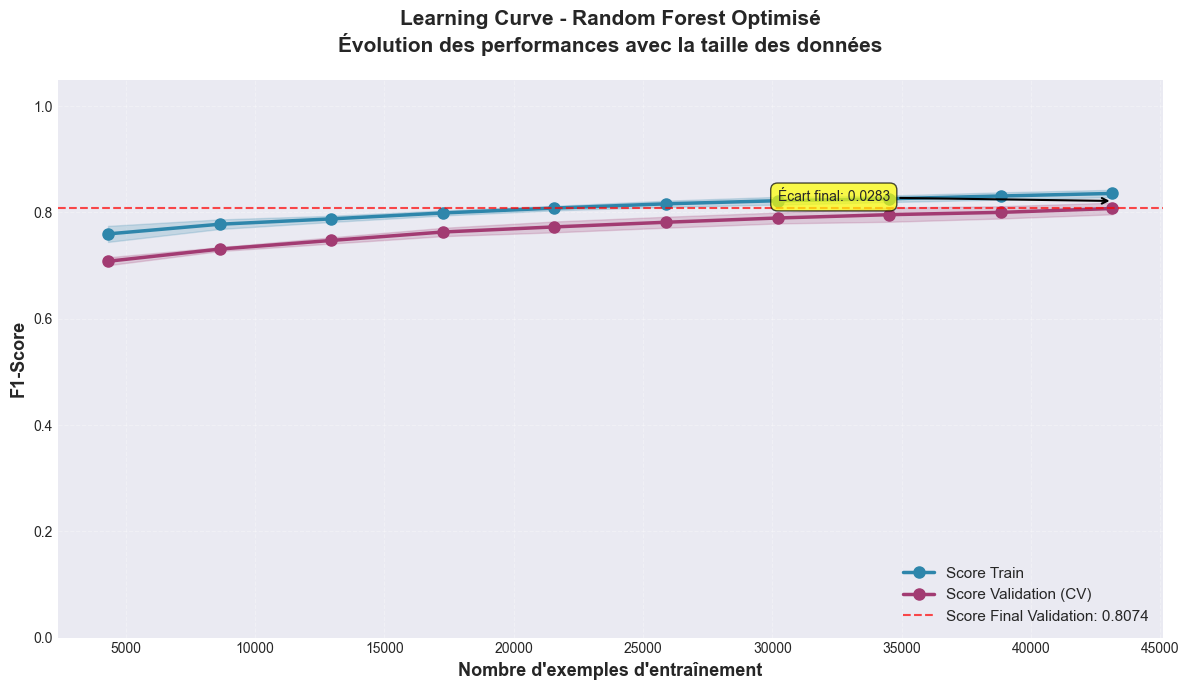

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import joblib

print("📊 ANALYSE DE LA LEARNING CURVE")
print("=" * 80)

best_model = joblib.load(r'fire_detection_models/random_forest_optimized.pkl')


# Définir les tailles d'échantillons d'entraînement à tester
train_sizes = np.linspace(0.1, 1.0, 10)  

# Calculer la learning curve
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,  # Validation croisée avec 5 folds
    scoring='f1',  # Métrique F1-score
    n_jobs=-1,  # Utiliser tous les CPU
    verbose=1,
    shuffle=True,
    random_state=42
)

print("✅ Calcul terminé!")

# Calcul des moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Affichage des statistiques
print("\n" + "=" * 80)
print("📈 STATISTIQUES DE LA LEARNING CURVE")
print("=" * 80)
print(f"\n{'Taille Train':<15} {'F1 Train':<15} {'F1 Validation':<15} {'Écart':<15}")
print("-" * 80)
for i in range(len(train_sizes_abs)):
    ecart = train_mean[i] - test_mean[i]
    print(f"{train_sizes_abs[i]:<15,.0f} {train_mean[i]:<15.4f} {test_mean[i]:<15.4f} {ecart:<15.4f}")

# Visualisation
fig, ax = plt.subplots(figsize=(12, 7))

# Courbe d'entraînement
ax.plot(train_sizes_abs, train_mean, 'o-', color='#2E86AB', 
        linewidth=2.5, markersize=8, label='Score Train')
ax.fill_between(train_sizes_abs, 
                train_mean - train_std, 
                train_mean + train_std, 
                alpha=0.2, color='#2E86AB')

# Courbe de validation
ax.plot(train_sizes_abs, test_mean, 'o-', color='#A23B72', 
        linewidth=2.5, markersize=8, label='Score Validation (CV)')
ax.fill_between(train_sizes_abs, 
                test_mean - test_std, 
                test_mean + test_std, 
                alpha=0.2, color='#A23B72')

# Ligne de convergence (dernière valeur de validation)
final_val_score = test_mean[-1]
ax.axhline(final_val_score, color='red', linestyle='--', 
           linewidth=1.5, alpha=0.7, 
           label=f'Score Final Validation: {final_val_score:.4f}')

# Configuration du graphique
ax.set_xlabel('Nombre d\'exemples d\'entraînement', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('Learning Curve - Random Forest Optimisé\nÉvolution des performances avec la taille des données', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.05])

# Annotations
gap = train_mean[-1] - test_mean[-1]
ax.annotate(f'Écart final: {gap:.4f}', 
            xy=(train_sizes_abs[-1], (train_mean[-1] + test_mean[-1])/2),
            xytext=(train_sizes_abs[-1]*0.7, (train_mean[-1] + test_mean[-1])/2),
            fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

plt.tight_layout()
plt.show()

K_means

Préparation des données

PRÉTRAITEMENT POUR CLUSTERING NON SUPERVISÉ (K-MEANS)

📁 ÉTAPE 1: CHARGEMENT DES DONNÉES
--------------------------------------------------------------------------------
✅ Dataset chargé: 58,167 lignes × 41 colonnes

📍 Colonnes de position conservées: ['longitude', 'latitude', 'row', 'col', 'HWSD2_SMU_ID']
🎯 Colonne cible 'is_fire' détectée (gardée pour évaluation)
📊 Features pour clustering: 35 colonnes

📊 ÉTAPE 2: ÉLIMINATION DES VARIABLES À FAIBLE VARIANCE
--------------------------------------------------------------------------------
Variables numériques: 34
Variables catégorielles: 1

Variables à faible variance (< 0.01):
  - REF_BULK: variance = 0.007677
✅ 1 variables à faible variance supprimées
   Nouvelles dimensions: 34 colonnes

🔗 ÉTAPE 3: ÉLIMINATION DES VARIABLES FORTEMENT CORRÉLÉES
--------------------------------------------------------------------------------
Seuil de corrélation: 0.95

Paires fortement corrélées (>0.95):
  - SILT ↔ CEC_SOIL: 0.951
  - CLAY ↔ CEC_SOIL:

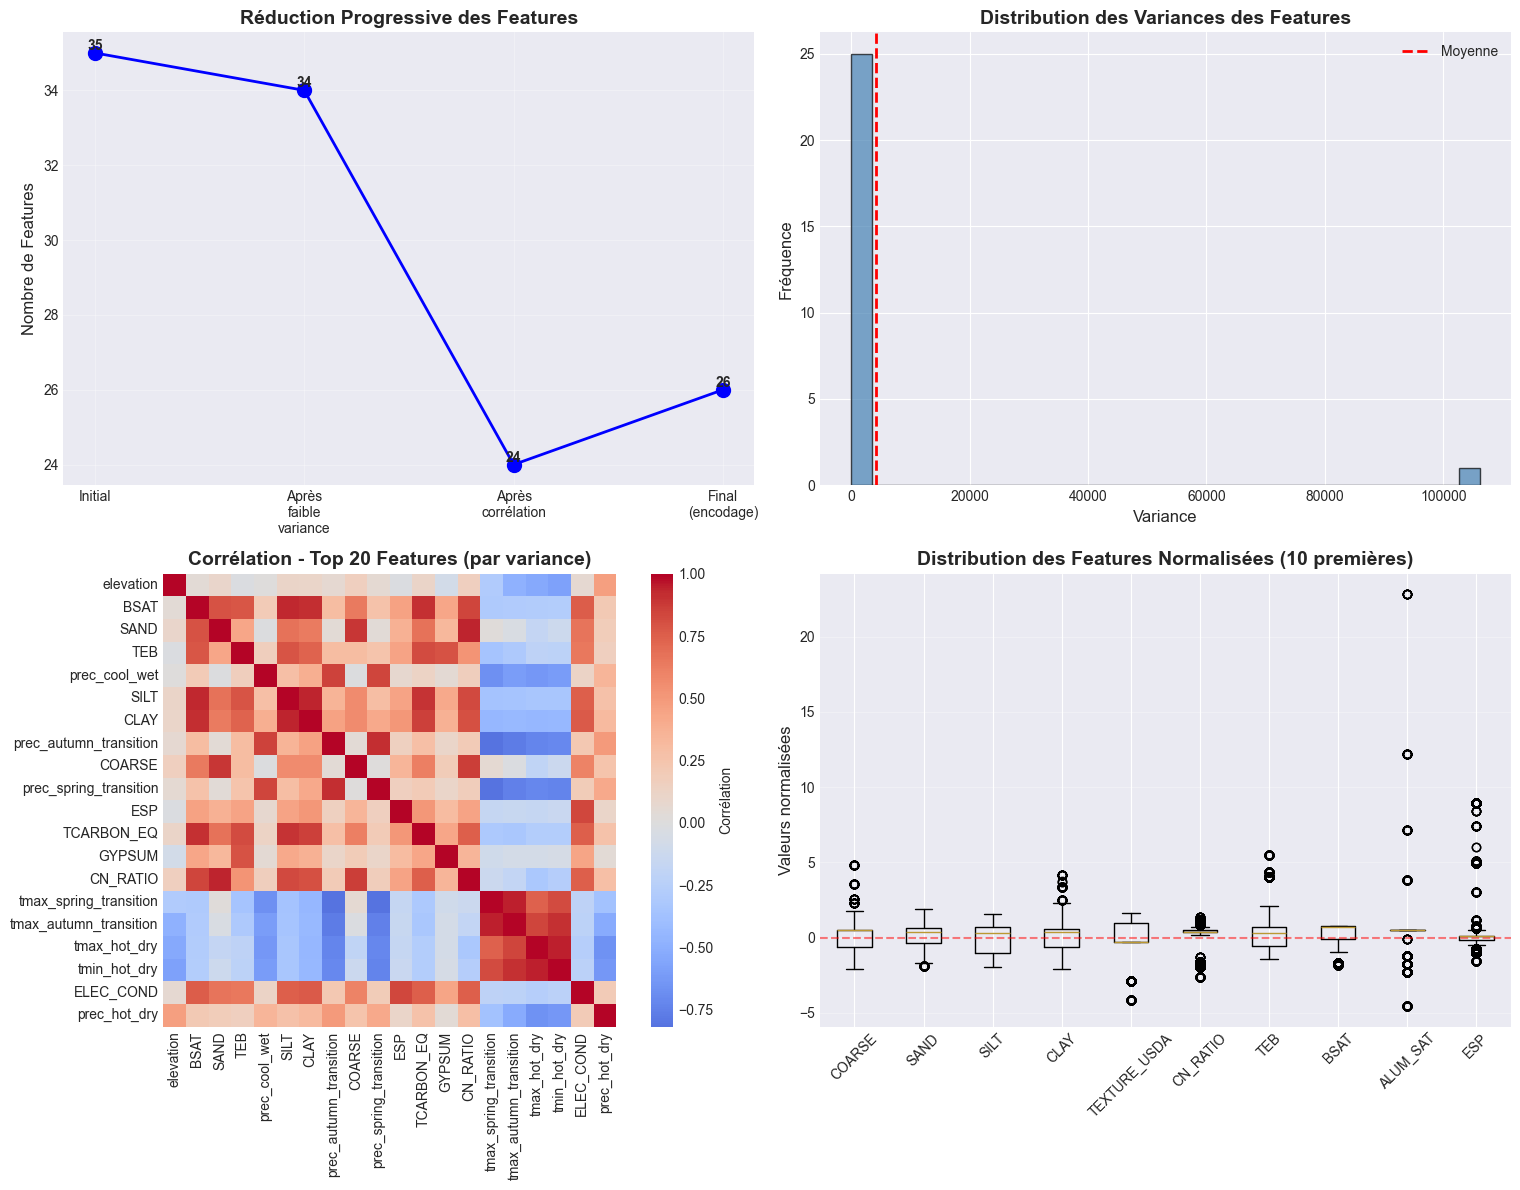

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PRÉTRAITEMENT POUR CLUSTERING NON SUPERVISÉ (K-MEANS)")
print("="*80)

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================
print("\n📁 ÉTAPE 1: CHARGEMENT DES DONNÉES")
print("-" * 80)
df = pd.read_csv('data.csv')
print(f"✅ Dataset chargé: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")

initial_shape = df.shape

# Séparer les colonnes de position et les features
position_cols = ['longitude', 'latitude', 'row', 'col', 'HWSD2_SMU_ID']
existing_position_cols = [col for col in position_cols if col in df.columns]

# Sauvegarder les données de position
df_position = df[existing_position_cols].copy()
print(f"\n📍 Colonnes de position conservées: {existing_position_cols}")

# Séparer features et target (on ignore is_fire pour le clustering)
if 'is_fire' in df.columns:
    y_labels = df['is_fire'].copy()  # Gardé pour évaluation ultérieure
    X = df.drop(['is_fire'] + existing_position_cols, axis=1)
    print(f"🎯 Colonne cible 'is_fire' détectée (gardée pour évaluation)")
else:
    y_labels = None
    X = df.drop(existing_position_cols, axis=1)

print(f"📊 Features pour clustering: {X.shape[1]} colonnes")

# ============================================================================
# 2. ÉLIMINATION DES VARIABLES À FAIBLE VARIANCE
# ============================================================================
print("\n📊 ÉTAPE 2: ÉLIMINATION DES VARIABLES À FAIBLE VARIANCE")
print("-" * 80)

# Séparer numériques et catégorielles
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numériques: {len(numeric_cols)}")
print(f"Variables catégorielles: {len(categorical_cols)}")

# Calculer la variance pour les colonnes numériques
variances = X[numeric_cols].var()
low_variance_threshold = 0.01
low_variance_cols = variances[variances < low_variance_threshold].index.tolist()

if low_variance_cols:
    print(f"\nVariables à faible variance (< {low_variance_threshold}):")
    for col in low_variance_cols:
        print(f"  - {col}: variance = {variances[col]:.6f}")
    X = X.drop(low_variance_cols, axis=1)
    numeric_cols = [col for col in numeric_cols if col not in low_variance_cols]
    print(f"✅ {len(low_variance_cols)} variables à faible variance supprimées")
else:
    print("✅ Aucune variable à faible variance détectée")

print(f"   Nouvelles dimensions: {X.shape[1]} colonnes")

# ============================================================================
# 3. ÉLIMINATION DES VARIABLES FORTEMENT CORRÉLÉES
# ============================================================================
print("\n🔗 ÉTAPE 3: ÉLIMINATION DES VARIABLES FORTEMENT CORRÉLÉES")
print("-" * 80)

# Calculer la matrice de corrélation
corr_matrix = X[numeric_cols].corr().abs()

# Seuil de corrélation
corr_threshold = 0.95  # Plus strict pour le clustering
print(f"Seuil de corrélation: {corr_threshold}")

# Identifier les paires fortement corrélées
highly_correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > corr_threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            highly_correlated_pairs.append((col1, col2, corr_matrix.iloc[i, j]))

if highly_correlated_pairs:
    print(f"\nPaires fortement corrélées (>{corr_threshold}):")
    for col1, col2, corr_val in highly_correlated_pairs:
        print(f"  - {col1} ↔ {col2}: {corr_val:.3f}")

    # Décider quelles colonnes supprimer (garder celle avec plus de variance)
    cols_to_remove = set()
    for col1, col2, _ in highly_correlated_pairs:
        if col1 not in cols_to_remove and col2 not in cols_to_remove:
            # Garder celle avec plus de variance
            if variances[col1] >= variances[col2]:
                cols_to_remove.add(col2)
            else:
                cols_to_remove.add(col1)

    print(f"\nColonnes à supprimer:")
    for col in cols_to_remove:
        print(f"  - {col}")
    X = X.drop(list(cols_to_remove), axis=1)
    numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    print(f"✅ {len(cols_to_remove)} variables fortement corrélées supprimées")
else:
    print("✅ Aucune paire de variables fortement corrélées détectée")

print(f"   Nouvelles dimensions: {X.shape[1]} colonnes")

# ============================================================================
# 4. ENCODAGE DES VARIABLES CATÉGORIELLES
# ============================================================================
print("\n🔤 ÉTAPE 4: ENCODAGE DES VARIABLES CATÉGORIELLES")
print("-" * 80)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Variables catégorielles: {categorical_cols}")

if categorical_cols:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"✅ {len(categorical_cols)} variables encodées avec one-hot encoding")
    print(f"   Nouvelles dimensions: {X_encoded.shape[1]} colonnes")
else:
    X_encoded = X.copy()
    print("✅ Aucune variable catégorielle à encoder")

# ============================================================================
# 5. NORMALISATION DES DONNÉES
# ============================================================================
print("\n📏 ÉTAPE 5: NORMALISATION DES DONNÉES")
print("-" * 80)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns, index=X_encoded.index)

print("✅ Normalisation StandardScaler appliquée")
print(f"   Moyenne ≈ 0, Écart-type ≈ 1 pour chaque feature")

# ============================================================================
# 6. RÉSUMÉ DES FEATURES CONSERVÉES
# ============================================================================
print("\n📋 RÉSUMÉ DES FEATURES")
print("-" * 80)
print(f"Features initiales: {initial_shape[1] - 1 - len(existing_position_cols)}")
print(f"Features finales pour clustering: {X_encoded.shape[1]}")
print(f"Colonnes de position conservées: {len(existing_position_cols)}")

print("\n📝 Features finales pour K-Means:")
for i, col in enumerate(X_encoded.columns, 1):
    print(f"  {i:2d}. {col}")

# ============================================================================
# 7. SAUVEGARDE DES DONNÉES
# ============================================================================
print("\n💾 ÉTAPE 7: SAUVEGARDE DES DONNÉES")
print("-" * 80)

# Sauvegarder les données normalisées pour K-Means
X_scaled_df.to_csv('X_kmeans.csv', index=False)
print("✅ Fichier sauvegardé: X_kmeans.csv")

# Sauvegarder les données de position
df_position.to_csv('position_data.csv', index=False)
print("✅ Fichier sauvegardé: position_data.csv")

# Sauvegarder les labels originaux si disponibles (pour évaluation)
if y_labels is not None:
    y_labels.to_csv('y_labels.csv', index=False)
    print("✅ Fichier sauvegardé: y_labels.csv")

# Sauvegarder le scaler et les noms de features
import joblib
joblib.dump(scaler, 'scaler_kmeans.pkl')
joblib.dump(X_encoded.columns.tolist(), 'feature_names_kmeans.pkl')
print("✅ Fichier sauvegardé: scaler_kmeans.pkl")
print("✅ Fichier sauvegardé: feature_names_kmeans.pkl")

# ============================================================================
# 8. STATISTIQUES DESCRIPTIVES
# ============================================================================
print("\n📊 STATISTIQUES DESCRIPTIVES")
print("-" * 80)
print(f"Nombre total d'échantillons: {len(X_scaled_df):,}")
print(f"Nombre de features: {X_scaled_df.shape[1]}")
print(f"\nStatistiques après normalisation:")
print(f"  Moyenne min: {X_scaled_df.mean().min():.6f}")
print(f"  Moyenne max: {X_scaled_df.mean().max():.6f}")
print(f"  Std min: {X_scaled_df.std().min():.6f}")
print(f"  Std max: {X_scaled_df.std().max():.6f}")

# ============================================================================
# 9. VISUALISATION
# ============================================================================
print("\n📊 GÉNÉRATION DES VISUALISATIONS")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Réduction des features
stages = ['Initial', 'Après\nfaible\nvariance', 'Après\ncorrélation', 'Final\n(encodage)']
n_features = [
    initial_shape[1] - 1 - len(existing_position_cols),
    initial_shape[1] - 1 - len(existing_position_cols) - len(low_variance_cols) if low_variance_cols else initial_shape[1] - 1 - len(existing_position_cols),
    X.shape[1],
    X_encoded.shape[1]
]

axes[0, 0].plot(stages, n_features, marker='o', linewidth=2, markersize=10, color='blue')
axes[0, 0].set_ylabel('Nombre de Features', fontsize=12)
axes[0, 0].set_title('Réduction Progressive des Features', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(n_features):
    axes[0, 0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# 2. Distribution des variances
axes[0, 1].hist(X_encoded.var(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Variance', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Distribution des Variances des Features', fontsize=14, fontweight='bold')
axes[0, 1].axvline(X_encoded.var().mean(), color='red', linestyle='--', linewidth=2, label='Moyenne')
axes[0, 1].legend()

# 3. Heatmap de corrélation (top 20 features par variance)
top_features = X_encoded.var().nlargest(20).index
corr_subset = X_encoded[top_features].corr()
sns.heatmap(corr_subset, cmap='coolwarm', center=0, annot=False, 
            square=True, ax=axes[1, 0], cbar_kws={'label': 'Corrélation'})
axes[1, 0].set_title('Corrélation - Top 20 Features (par variance)', fontsize=14, fontweight='bold')

# 4. Distribution des données normalisées (échantillon)
sample_cols = X_scaled_df.columns[:min(10, len(X_scaled_df.columns))]
axes[1, 1].boxplot([X_scaled_df[col] for col in sample_cols], labels=sample_cols)
axes[1, 1].set_ylabel('Valeurs normalisées', fontsize=12)
axes[1, 1].set_title('Distribution des Features Normalisées (10 premières)', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('preprocessing_kmeans_summary.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: preprocessing_kmeans_summary.png")

# ============================================================================
# 10. RAPPORT FINAL
# ============================================================================
print("\n" + "="*80)
print("✅ PRÉTRAITEMENT POUR K-MEANS TERMINÉ!")
print("="*80)

print("\n📊 RÉSUMÉ FINAL:")
print("-" * 80)
print(f"1. Échantillons totaux:              {len(X_scaled_df):,}")
print(f"2. Features pour clustering:         {X_encoded.shape[1]}")
print(f"3. Colonnes de position conservées:  {len(existing_position_cols)}")
print(f"4. Données normalisées:              ✅ (StandardScaler)")
print(f"5. Prêt pour K-Means:                ✅")

print("\n📁 Fichiers générés:")
print("   1. X_kmeans.csv           - Features normalisées")
print("   2. position_data.csv      - Données de position (longitude, latitude, etc.)")
if y_labels is not None:
    print("   3. y_labels.csv           - Labels originaux (pour évaluation)")
print("   4. scaler_kmeans.pkl      - Scaler pour nouvelles données")
print("   5. feature_names_kmeans.pkl - Noms des features")
print("   6. preprocessing_kmeans_summary.png - Visualisations")

print("\n🎯 Prochaine étape: Appliquer K-Means avec différentes valeurs de K!")
print("="*80)

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("K-MEANS CLUSTERING AVEC ÉVALUATION ET VISUALISATION")
print("="*80)

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================
print("\n📁 ÉTAPE 1: CHARGEMENT DES DONNÉES")
print("-" * 80)

# Charger les features normalisées
X = pd.read_csv('X_kmeans.csv')
print(f"✅ Features chargées: {X.shape[0]:,} lignes × {X.shape[1]} colonnes")

# Charger les données de position
position_data = pd.read_csv('position_data.csv')
print(f"✅ Données de position chargées: {position_data.shape}")

# Charger les labels originaux si disponibles
try:
    y_true = pd.read_csv('y_labels.csv').values.ravel()
    print(f"✅ Labels originaux chargés: {len(y_true)} échantillons")
    has_labels = True
except:
    y_true = None
    has_labels = False
    print("ℹ️  Pas de labels originaux (mode clustering pur)")

# ============================================================================
# 2. FONCTION DISTANCE EUCLIDIENNE
# ============================================================================
def compute_euclidean_distances(X, centroids):
    """Calcule les distances euclidiennes entre chaque point et chaque centroïde"""
    distances = cdist(X, centroids, metric='euclidean')
    return distances

def display_distance_statistics(X, centroids, labels):
    """Affiche les statistiques de distances pour chaque cluster"""
    distances = compute_euclidean_distances(X, centroids)
    print("\n📏 STATISTIQUES DES DISTANCES EUCLIDIENNES PAR CLUSTER:")
    print("-" * 80)
    
    for k in range(len(centroids)):
        cluster_distances = distances[labels == k, k]
        print(f"\n  Cluster {k}:")
        print(f"    Nombre de points:     {len(cluster_distances):,}")
        print(f"    Distance min:         {cluster_distances.min():.4f}")
        print(f"    Distance max:         {cluster_distances.max():.4f}")
        print(f"    Distance moyenne:     {cluster_distances.mean():.4f}")
        print(f"    Distance médiane:     {np.median(cluster_distances):.4f}")
        print(f"    Écart-type:           {cluster_distances.std():.4f}")

# ============================================================================
# 3. TEST DE DIFFÉRENTES VALEURS DE K
# ============================================================================
print("\n🔬 ÉTAPE 2: TEST DE DIFFÉRENTES VALEURS DE K")
print("="*80)

k_values = [3, 4, 5]  # Trois valeurs de K à tester
results = []

for k in k_values:
    print(f"\n{'='*80}")
    print(f"TEST AVEC K = {k}")
    print('='*80)
    
    # Initialiser K-Means avec init='random' pour voir les centroïdes initiaux
    kmeans_init = KMeans(n_clusters=k, init='random', n_init=1, random_state=42, max_iter=1)
    kmeans_init.fit(X)
    
    print(f"\n🎯 CENTROÏDES INITIAUX (K={k}):")
    print("-" * 80)
    initial_centroids = kmeans_init.cluster_centers_
    for i, centroid in enumerate(initial_centroids):
        print(f"\n  Centroïde {i}:")
        print(f"    Coordonnées (5 premières dims): {centroid[:5]}")
        print(f"    Norme L2: {np.linalg.norm(centroid):.4f}")
    
    # Appliquer K-Means complet avec k-means++
    print(f"\n⚙️  APPLICATION K-MEANS COMPLET (K={k})...")
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42, max_iter=300)
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    
    print(f"\n✅ Clustering terminé!")
    print(f"   Nombre d'itérations: {kmeans.n_iter_}")
    print(f"   Inertie: {kmeans.inertia_:.2f}")
    
    # Distribution des clusters
    print(f"\n📊 DISTRIBUTION DES CLUSTERS (K={k}):")
    print("-" * 80)
    unique, counts = np.unique(labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        print(f"  Cluster {cluster_id}: {count:,} points ({count/len(labels)*100:.2f}%)")
    
    # Statistiques de distances
    display_distance_statistics(X.values, centroids, labels)
    
    # Métriques d'évaluation internes
    print(f"\n📈 MÉTRIQUES D'ÉVALUATION (K={k}):")
    print("-" * 80)
    
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    print(f"  Silhouette Score:        {silhouette:.4f}  (Plus proche de 1 = meilleur)")
    print(f"  Davies-Bouldin Index:    {davies_bouldin:.4f}  (Plus proche de 0 = meilleur)")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz:.2f}  (Plus élevé = meilleur)")
    
    # Métriques externes si labels disponibles
    if has_labels:
        ari = adjusted_rand_score(y_true, labels)
        nmi = normalized_mutual_info_score(y_true, labels)
        print(f"\n  📊 Comparaison avec labels réels:")
        print(f"    Adjusted Rand Index:       {ari:.4f}  (1 = parfait, 0 = aléatoire)")
        print(f"    Normalized Mutual Info:    {nmi:.4f}  (1 = parfait, 0 = indépendant)")
    else:
        ari = None
        nmi = None
    
    # Stocker les résultats
    results.append({
        'k': k,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'inertia': kmeans.inertia_,
        'ari': ari,
        'nmi': nmi,
        'labels': labels,
        'centroids': centroids,
        'kmeans': kmeans
    })

# ============================================================================
# 4. COMPARAISON ET SÉLECTION DU MEILLEUR K
# ============================================================================
print("\n" + "="*80)
print("📊 COMPARAISON DES RÉSULTATS")
print("="*80)

comparison_df = pd.DataFrame([{
    'K': r['k'],
    'Silhouette': r['silhouette'],
    'Davies-Bouldin': r['davies_bouldin'],
    'Calinski-Harabasz': r['calinski_harabasz'],
    'Inertie': r['inertia'],
    'ARI': r['ari'] if r['ari'] is not None else np.nan,
    'NMI': r['nmi'] if r['nmi'] is not None else np.nan
} for r in results])

print("\n" + comparison_df.to_string(index=False))

# Déterminer le meilleur K (basé sur Silhouette Score)
best_idx = comparison_df['Silhouette'].idxmax()
best_k = results[best_idx]['k']

print(f"\n🏆 MEILLEUR K SÉLECTIONNÉ: K = {best_k}")
print(f"   Basé sur le Silhouette Score: {results[best_idx]['silhouette']:.4f}")

best_result = results[best_idx]
best_labels = best_result['labels']
best_centroids = best_result['centroids']
best_kmeans = best_result['kmeans']

# ============================================================================
# 5. ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE
# ============================================================================
print(f"\n{'='*80}")
print(f"ANALYSE DÉTAILLÉE - MEILLEUR MODÈLE (K={best_k})")
print('='*80)

# Centroïdes finaux
print(f"\n🎯 CENTROÏDES FINAUX (K={best_k}):")
print("-" * 80)
for i, centroid in enumerate(best_centroids):
    print(f"\n  Centroïde {i}:")
    print(f"    Dimensions: {centroid.shape[0]}")
    print(f"    Norme L2: {np.linalg.norm(centroid):.4f}")
    print(f"    Top 5 valeurs: {centroid[:5]}")

# Distribution géographique
print(f"\n🗺️  DISTRIBUTION GÉOGRAPHIQUE PAR CLUSTER:")
print("-" * 80)
for cluster_id in range(best_k):
    cluster_mask = best_labels == cluster_id
    cluster_positions = position_data[cluster_mask]
    
    print(f"\n  Cluster {cluster_id}:")
    print(f"    Nombre de points: {cluster_mask.sum():,}")
    if 'longitude' in cluster_positions.columns and 'latitude' in cluster_positions.columns:
        print(f"    Longitude: [{cluster_positions['longitude'].min():.4f}, {cluster_positions['longitude'].max():.4f}]")
        print(f"    Latitude:  [{cluster_positions['latitude'].min():.4f}, {cluster_positions['latitude'].max():.4f}]")
        print(f"    Centre géo: ({cluster_positions['longitude'].mean():.4f}, {cluster_positions['latitude'].mean():.4f})")

# Si labels disponibles, analyser la correspondance
if has_labels:
    print(f"\n🔍 CORRESPONDANCE AVEC LABELS RÉELS:")
    print("-" * 80)
    for cluster_id in range(best_k):
        cluster_mask = best_labels == cluster_id
        cluster_true_labels = y_true[cluster_mask]
        fire_count = (cluster_true_labels == 1).sum()
        no_fire_count = (cluster_true_labels == 0).sum()
        print(f"\n  Cluster {cluster_id}:")
        print(f"    Fire (1):    {fire_count:,} ({fire_count/len(cluster_true_labels)*100:.1f}%)")
        print(f"    No Fire (0): {no_fire_count:,} ({no_fire_count/len(cluster_true_labels)*100:.1f}%)")
        print(f"    Classe dominante: {'Fire' if fire_count > no_fire_count else 'No Fire'}")

# ============================================================================
# 6. SAUVEGARDE DES RÉSULTATS
# ============================================================================
print(f"\n💾 SAUVEGARDE DES RÉSULTATS")
print("-" * 80)

# Créer DataFrame avec résultats
results_df = position_data.copy()
results_df['cluster'] = best_labels
if has_labels:
    results_df['true_label'] = y_true

# Sauvegarder
results_df.to_csv('kmeans_results.csv', index=False)
print("✅ Fichier sauvegardé: kmeans_results.csv")

# Sauvegarder le modèle
import joblib
joblib.dump(best_kmeans, 'kmeans_model.pkl')
print("✅ Modèle sauvegardé: kmeans_model.pkl")

# Sauvegarder les métriques
comparison_df.to_csv('kmeans_comparison.csv', index=False)
print("✅ Comparaison sauvegardée: kmeans_comparison.csv")

# ============================================================================
# 7. VISUALISATIONS
# ============================================================================
print(f"\n📊 GÉNÉRATION DES VISUALISATIONS")
print("-" * 80)

# Configuration des couleurs
colors = plt.cm.Set3(np.linspace(0, 1, max([r['k'] for r in results])))

# ============== FIGURE 1: MÉTRIQUES DE COMPARAISON ==============
fig1, axes = plt.subplots(2, 2, figsize=(16, 12))

k_vals = [r['k'] for r in results]

# Silhouette Score
axes[0, 0].plot(k_vals, [r['silhouette'] for r in results], 'o-', linewidth=2, markersize=10, color='blue')
axes[0, 0].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Meilleur K={best_k}')
axes[0, 0].set_xlabel('Nombre de Clusters (K)', fontsize=12)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 0].set_title('Silhouette Score vs K\n(Plus élevé = meilleur)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xticks(k_vals)

# Davies-Bouldin Index
axes[0, 1].plot(k_vals, [r['davies_bouldin'] for r in results], 'o-', linewidth=2, markersize=10, color='green')
axes[0, 1].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Meilleur K={best_k}')
axes[0, 1].set_xlabel('Nombre de Clusters (K)', fontsize=12)
axes[0, 1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[0, 1].set_title('Davies-Bouldin Index vs K\n(Plus bas = meilleur)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_xticks(k_vals)

# Calinski-Harabasz Index
axes[1, 0].plot(k_vals, [r['calinski_harabasz'] for r in results], 'o-', linewidth=2, markersize=10, color='purple')
axes[1, 0].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Meilleur K={best_k}')
axes[1, 0].set_xlabel('Nombre de Clusters (K)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Index', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Index vs K\n(Plus élevé = meilleur)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xticks(k_vals)

# Inertie
axes[1, 1].plot(k_vals, [r['inertia'] for r in results], 'o-', linewidth=2, markersize=10, color='orange')
axes[1, 1].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Meilleur K={best_k}')
axes[1, 1].set_xlabel('Nombre de Clusters (K)', fontsize=12)
axes[1, 1].set_ylabel('Inertie', fontsize=12)
axes[1, 1].set_title('Inertie vs K\n(Méthode du coude)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xticks(k_vals)

plt.tight_layout()
plt.savefig('kmeans_metrics_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: kmeans_metrics_comparison.png")
plt.close()

# ============== FIGURE 2: VISUALISATION SUR CARTE ==============
fig2, axes = plt.subplots(1, 2, figsize=(20, 8))

if 'longitude' in position_data.columns and 'latitude' in position_data.columns:
    # Carte 1: Clusters
    for cluster_id in range(best_k):
        cluster_mask = best_labels == cluster_id
        cluster_positions = position_data[cluster_mask]
        axes[0].scatter(
            cluster_positions['longitude'],
            cluster_positions['latitude'],
            c=[colors[cluster_id]],
            label=f'Cluster {cluster_id} (n={cluster_mask.sum():,})',
            alpha=0.6,
            s=10,
            edgecolors='none'
        )
    
    axes[0].set_xlabel('Longitude', fontsize=12)
    axes[0].set_ylabel('Latitude', fontsize=12)
    axes[0].set_title(f'Distribution Géographique des Clusters (K={best_k})', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(loc='best', markerscale=2)
    axes[0].grid(True, alpha=0.3)
    
    # Carte 2: Labels réels si disponibles
    if has_labels:
        scatter = axes[1].scatter(
            position_data['longitude'],
            position_data['latitude'],
            c=y_true,
            cmap='RdYlGn_r',
            alpha=0.6,
            s=10,
            edgecolors='none'
        )
        axes[1].set_xlabel('Longitude', fontsize=12)
        axes[1].set_ylabel('Latitude', fontsize=12)
        axes[1].set_title('Labels Réels (Fire vs No Fire)', fontsize=14, fontweight='bold')
        cbar = plt.colorbar(scatter, ax=axes[1])
        cbar.set_label('0=No Fire, 1=Fire', fontsize=10)
        axes[1].grid(True, alpha=0.3)
    else:
        # Distribution des tailles de clusters
        cluster_sizes = [np.sum(best_labels == i) for i in range(best_k)]
        axes[1].bar(range(best_k), cluster_sizes, color=colors[:best_k], alpha=0.7, edgecolor='black')
        axes[1].set_xlabel('Cluster ID', fontsize=12)
        axes[1].set_ylabel('Nombre de points', fontsize=12)
        axes[1].set_title(f'Taille des Clusters (K={best_k})', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='y')
        for i, size in enumerate(cluster_sizes):
            axes[1].text(i, size, f'{size:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('kmeans_geographic_map.png', dpi=300, bbox_inches='tight')
    print("✅ Sauvegardé: kmeans_geographic_map.png")
    plt.close()
else:
    print("⚠️  Colonnes longitude/latitude non disponibles pour la carte géographique")

# ============== FIGURE 3: ANALYSE DÉTAILLÉE MEILLEUR K ==============
fig3, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution des clusters
cluster_sizes = [np.sum(best_labels == i) for i in range(best_k)]
axes[0, 0].bar(range(best_k), cluster_sizes, color=colors[:best_k], alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Cluster ID', fontsize=12)
axes[0, 0].set_ylabel('Nombre de points', fontsize=12)
axes[0, 0].set_title(f'Distribution des Clusters (K={best_k})', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, size in enumerate(cluster_sizes):
    axes[0, 0].text(i, size, f'{size:,}', ha='center', va='bottom', fontweight='bold')

# Distances intra-cluster
distances_all = compute_euclidean_distances(X.values, best_centroids)
for cluster_id in range(best_k):
    cluster_distances = distances_all[best_labels == cluster_id, cluster_id]
    axes[0, 1].hist(cluster_distances, bins=50, alpha=0.5, 
                    label=f'Cluster {cluster_id}', color=colors[cluster_id])

axes[0, 1].set_xlabel('Distance au Centroïde', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Distribution des Distances Intra-Cluster', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Correspondance avec labels réels si disponibles
if has_labels:
    confusion_like = np.zeros((best_k, 2))
    for cluster_id in range(best_k):
        cluster_mask = best_labels == cluster_id
        cluster_true_labels = y_true[cluster_mask]
        confusion_like[cluster_id, 0] = (cluster_true_labels == 0).sum()
        confusion_like[cluster_id, 1] = (cluster_true_labels == 1).sum()
    
    x_pos = np.arange(best_k)
    axes[1, 0].bar(x_pos - 0.2, confusion_like[:, 0], 0.4, label='No Fire', color='green', alpha=0.7)
    axes[1, 0].bar(x_pos + 0.2, confusion_like[:, 1], 0.4, label='Fire', color='red', alpha=0.7)
    axes[1, 0].set_xlabel('Cluster ID', fontsize=12)
    axes[1, 0].set_ylabel('Nombre de points', fontsize=12)
    axes[1, 0].set_title('Composition des Clusters (Fire vs No Fire)', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Pureté des clusters
    purities = []
    for cluster_id in range(best_k):
        cluster_mask = best_labels == cluster_id
        cluster_true_labels = y_true[cluster_mask]
        purity = max((cluster_true_labels == 0).sum(), (cluster_true_labels == 1).sum()) / len(cluster_true_labels)
        purities.append(purity)
    
    axes[1, 1].bar(range(best_k), purities, color=colors[:best_k], alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Cluster ID', fontsize=12)
    axes[1, 1].set_ylabel('Pureté', fontsize=12)
    axes[1, 1].set_title('Pureté des Clusters', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylim([0, 1.1])
    axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Seuil 50%')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    for i, p in enumerate(purities):
        axes[1, 1].text(i, p, f'{p:.2f}', ha='center', va='bottom', fontweight='bold')
    axes[1, 1].legend()
else:
    # Heatmap des distances entre centroïdes
    centroid_distances = cdist(best_centroids, best_centroids, metric='euclidean')
    sns.heatmap(centroid_distances, annot=True, fmt='.2f', cmap='YlOrRd',
                square=True, ax=axes[1, 0], cbar_kws={'label': 'Distance'})
    axes[1, 0].set_xlabel('Centroïde', fontsize=12)
    axes[1, 0].set_ylabel('Centroïde', fontsize=12)
    axes[1, 0].set_title('Distances entre Centroïdes', fontsize=14, fontweight='bold')
    
    # Statistiques par cluster
    stats_data = []
    for cluster_id in range(best_k):
        cluster_distances = distances_all[best_labels == cluster_id, cluster_id]
        stats_data.append([
            cluster_distances.mean(),
            cluster_distances.std(),
            cluster_distances.max()
        ])
    
    x_pos = np.arange(best_k)
    width = 0.25
    axes[1, 1].bar(x_pos - width, [s[0] for s in stats_data], width, label='Moyenne', alpha=0.7)
    axes[1, 1].bar(x_pos, [s[1] for s in stats_data], width, label='Écart-type', alpha=0.7)
    axes[1, 1].bar(x_pos + width, [s[2] for s in stats_data], width, label='Max', alpha=0.7)
    axes[1, 1].set_xlabel('Cluster ID', fontsize=12)
    axes[1, 1].set_ylabel('Distance', fontsize=12)
    axes[1, 1].set_title('Statistiques de Distance par Cluster', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('kmeans_detailed_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: kmeans_detailed_analysis.png")
plt.close()

# ============================================================================
# 8. RAPPORT FINAL
# ============================================================================
print("\n" + "="*80)
print("✅ K-MEANS CLUSTERING TERMINÉ!")
print("="*80)

print(f"\n🏆 RÉSULTATS FINAUX:")
print("-" * 80)
print(f"Meilleur K:                    {best_k}")
print(f"Nombre d'échantillons:         {len(best_labels):,}")
print(f"Silhouette Score:              {best_result['silhouette']:.4f}")
print(f"Davies-Bouldin Index:          {best_result['davies_bouldin']:.4f}")
print(f"Calinski-Harabasz Index:       {best_result['calinski_harabasz']:.2f}")
print(f"Inertie:                       {best_result['inertia']:.2f}")

if has_labels:
    print(f"\nComparaison avec labels réels:")
    print(f"  Adjusted Rand Index:         {best_result['ari']:.4f}")
    print(f"  Normalized Mutual Info:      {best_result['nmi']:.4f}")

print(f"\n📁 Fichiers générés:")
print("   1. kmeans_results.csv              - Résultats du clustering")
print("   2. kmeans_model.pkl                - Modèle K-Means sauvegardé")
print("   3. kmeans_comparison.csv           - Comparaison des K")
print("   4. kmeans_metrics_comparison.png   - Graphiques de métriques")
print("   5. kmeans_geographic_map.png       - Visualisation géographique")
print("   6. kmeans_detailed_analysis.png    - Analyse détaillée")

print("\n🎯 Le clustering est terminé avec succès!")
print("="*80)

K-MEANS CLUSTERING AVEC ÉVALUATION ET VISUALISATION

📁 ÉTAPE 1: CHARGEMENT DES DONNÉES
--------------------------------------------------------------------------------
✅ Features chargées: 58,167 lignes × 26 colonnes
✅ Données de position chargées: (58167, 5)
✅ Labels originaux chargés: 58167 échantillons

🔬 ÉTAPE 2: TEST DE DIFFÉRENTES VALEURS DE K

TEST AVEC K = 3

🎯 CENTROÏDES INITIAUX (K=3):
--------------------------------------------------------------------------------

  Centroïde 0:
    Coordonnées (5 premières dims): [-1.44645265 -1.65113092 -1.63555974 -1.58940003 -0.29934205]
    Norme L2: 5.3690

  Centroïde 1:
    Coordonnées (5 premières dims): [ 0.33268426  0.22403343  0.70429006  0.90937273 -0.92481222]
    Norme L2: 4.1079

  Centroïde 2:
    Coordonnées (5 premières dims): [0.48225658 0.60324994 0.43415878 0.34570088 0.43640419]
    Norme L2: 1.7483

⚙️  APPLICATION K-MEANS COMPLET (K=3)...

✅ Clustering terminé!
   Nombre d'itérations: 7
   Inertie: 705197.01

📊 DIST

K_means from scratch

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("K-MEANS FROM SCRATCH - IMPLÉMENTATION PERSONNALISÉE (K=3)")
print("="*80)

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================
print("\n📁 Chargement des données...")
X = pd.read_csv('X_kmeans.csv').values
print(f"✅ {X.shape[0]:,} échantillons × {X.shape[1]} features chargées")

try:
    y_true = pd.read_csv('y_labels.csv').values.ravel()
    has_labels = True
except:
    y_true = None
    has_labels = False

# ============================================================================
# 2. IMPLÉMENTATION K-MEANS FROM SCRATCH
# ============================================================================

def euclidean_distance(a, b):
    """Calcule la distance euclidienne entre deux vecteurs"""
    return np.sqrt(np.sum((a - b) ** 2))

def initialize_centroids(X, k, random_state=42):
    """Initialise k centroïdes aléatoirement"""
    np.random.seed(random_state)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    """Assigne chaque point au centroïde le plus proche"""
    distances = np.zeros((X.shape[0], len(centroids)))
    for i, centroid in enumerate(centroids):
        distances[:, i] = np.sqrt(np.sum((X - centroid) ** 2, axis=1))
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    """Recalcule les centroïdes comme la moyenne des points de chaque cluster"""
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroids[i] = cluster_points.mean(axis=0)
    return centroids

def kmeans_from_scratch(X, k=3, max_iter=300, random_state=42):
    """Algorithme K-Means implémenté from scratch"""
    # Initialisation
    centroids = initialize_centroids(X, k, random_state)
    
    for iteration in range(max_iter):
        # Assignment step
        labels = assign_clusters(X, centroids)
        
        # Update step
        new_centroids = update_centroids(X, labels, k)
        
        # Convergence check
        if np.allclose(centroids, new_centroids, rtol=1e-6):
            print(f"✅ Convergence atteinte à l'itération {iteration + 1}")
            break
        
        centroids = new_centroids
    
    # Calcul de l'inertie
    inertia = 0
    for i in range(k):
        cluster_points = X[labels == i]
        inertia += np.sum((cluster_points - centroids[i]) ** 2)
    
    return labels, centroids, iteration + 1, inertia

# ============================================================================
# 3. APPLICATION DU K-MEANS (K=3)
# ============================================================================
print("\n" + "="*80)
print("⚙️  Application K-Means from scratch avec K=3...")
print("="*80)

k = 3
labels, centroids, n_iter, inertia = kmeans_from_scratch(X, k=k, max_iter=300, random_state=42)

print(f"\n✅ Clustering terminé!")
print(f"   Nombre d'itérations: {n_iter}")
print(f"   Inertie: {inertia:.2f}")

# ============================================================================
# 4. DISTRIBUTION DES CLUSTERS
# ============================================================================
print(f"\n📊 DISTRIBUTION DES CLUSTERS:")
print("-" * 80)
unique, counts = np.unique(labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count:,} points ({count/len(labels)*100:.2f}%)")

# ============================================================================
# 5. MÉTRIQUES D'ÉVALUATION
# ============================================================================
print(f"\n📈 MÉTRIQUES D'ÉVALUATION:")
print("="*80)

# Métriques internes
silhouette = silhouette_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)
calinski_harabasz = calinski_harabasz_score(X, labels)

print(f"\n🎯 Métriques Internes:")
print("-" * 80)
print(f"  Silhouette Score:        {silhouette:.4f}  (plus proche de 1 = meilleur)")
print(f"  Davies-Bouldin Index:    {davies_bouldin:.4f}  (plus proche de 0 = meilleur)")
print(f"  Calinski-Harabasz Index: {calinski_harabasz:.2f}  (plus élevé = meilleur)")
print(f"  Inertie:                 {inertia:.2f}  (plus bas = meilleur)")

# Métriques externes si labels disponibles
if has_labels:
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)
    
    print(f"\n🔍 Métriques Externes (comparaison avec labels réels):")
    print("-" * 80)
    print(f"  Adjusted Rand Index:       {ari:.4f}  (1 = parfait, 0 = aléatoire)")
    print(f"  Normalized Mutual Info:    {nmi:.4f}  (1 = parfait, 0 = indépendant)")
    
    # Analyse de la correspondance
    print(f"\n📋 Composition des Clusters:")
    print("-" * 80)
    for cluster_id in range(k):
        cluster_mask = labels == cluster_id
        cluster_true_labels = y_true[cluster_mask]
        fire_count = (cluster_true_labels == 1).sum()
        no_fire_count = (cluster_true_labels == 0).sum()
        purity = max(fire_count, no_fire_count) / len(cluster_true_labels)
        
        print(f"\n  Cluster {cluster_id}:")
        print(f"    Fire (1):          {fire_count:,} ({fire_count/len(cluster_true_labels)*100:.1f}%)")
        print(f"    No Fire (0):       {no_fire_count:,} ({no_fire_count/len(cluster_true_labels)*100:.1f}%)")
        print(f"    Pureté:            {purity:.4f}")
        print(f"    Classe dominante:  {'Fire' if fire_count > no_fire_count else 'No Fire'}")

# ============================================================================
# 6. STATISTIQUES DES DISTANCES
# ============================================================================
print(f"\n📏 STATISTIQUES DES DISTANCES AU CENTROÏDE:")
print("-" * 80)

for cluster_id in range(k):
    cluster_points = X[labels == cluster_id]
    distances = np.sqrt(np.sum((cluster_points - centroids[cluster_id]) ** 2, axis=1))
    
    print(f"\n  Cluster {cluster_id}:")
    print(f"    Distance min:      {distances.min():.4f}")
    print(f"    Distance max:      {distances.max():.4f}")
    print(f"    Distance moyenne:  {distances.mean():.4f}")
    print(f"    Distance médiane:  {np.median(distances):.4f}")
    print(f"    Écart-type:        {distances.std():.4f}")

# ============================================================================
# 7. RÉSUMÉ FINAL
# ============================================================================
print("\n" + "="*80)
print("✅ K-MEANS FROM SCRATCH TERMINÉ!")
print("="*80)

print(f"\n🏆 RÉSULTATS FINAUX (K={k}):")
print("-" * 80)
print(f"  Nombre d'échantillons:         {len(labels):,}")
print(f"  Nombre d'itérations:           {n_iter}")
print(f"  Silhouette Score:              {silhouette:.4f}")
print(f"  Davies-Bouldin Index:          {davies_bouldin:.4f}")
print(f"  Calinski-Harabasz Index:       {calinski_harabasz:.2f}")
print(f"  Inertie:                       {inertia:.2f}")

if has_labels:
    print(f"  Adjusted Rand Index:           {ari:.4f}")
    print(f"  Normalized Mutual Info:        {nmi:.4f}")

print("\n" + "="*80)

K-MEANS FROM SCRATCH - IMPLÉMENTATION PERSONNALISÉE (K=3)

📁 Chargement des données...
✅ 58,167 échantillons × 26 features chargées

⚙️  Application K-Means from scratch avec K=3...
✅ Convergence atteinte à l'itération 13

✅ Clustering terminé!
   Nombre d'itérations: 13
   Inertie: 705196.98

📊 DISTRIBUTION DES CLUSTERS:
--------------------------------------------------------------------------------
  Cluster 0: 13,667 points (23.50%)
  Cluster 1: 35,055 points (60.27%)
  Cluster 2: 9,445 points (16.24%)

📈 MÉTRIQUES D'ÉVALUATION:

🎯 Métriques Internes:
--------------------------------------------------------------------------------
  Silhouette Score:        0.4589  (plus proche de 1 = meilleur)
  Davies-Bouldin Index:    1.0397  (plus proche de 0 = meilleur)
  Calinski-Harabasz Index: 33286.29  (plus élevé = meilleur)
  Inertie:                 705196.98  (plus bas = meilleur)

🔍 Métriques Externes (comparaison avec labels réels):
---------------------------------------------------

DBSCAN

In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DBSCAN CLUSTERING AVEC ÉVALUATION ET VISUALISATION")
print("="*80)

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================
print("\n📁 ÉTAPE 1: CHARGEMENT DES DONNÉES")
print("-" * 80)

# Charger les features normalisées
X = pd.read_csv('X_kmeans.csv')
print(f"✅ Features chargées: {X.shape[0]:,} lignes × {X.shape[1]} colonnes")

# Charger les données de position
position_data = pd.read_csv('position_data.csv')
print(f"✅ Données de position chargées: {position_data.shape}")

# Charger les labels originaux si disponibles
try:
    y_true = pd.read_csv('y_labels.csv').values.ravel()
    print(f"✅ Labels originaux chargés: {len(y_true)} échantillons")
    has_labels = True
except:
    y_true = None
    has_labels = False
    print("ℹ️  Pas de labels originaux (mode clustering pur)")

# ============================================================================
# 2. ANALYSE K-DISTANCE POUR CHOISIR EPS
# ============================================================================
print("\n📏 ÉTAPE 2: ANALYSE K-DISTANCE POUR DÉTERMINER EPS")
print("-" * 80)

# Calculer les k-distances pour k=5
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
k_distances = np.sort(distances[:, k-1], axis=0)

print(f"✅ K-distances calculées pour k={k}")
print(f"   Distance min:     {k_distances.min():.4f}")
print(f"   Distance max:     {k_distances.max():.4f}")
print(f"   Distance médiane: {np.median(k_distances):.4f}")
print(f"   Distance moyenne: {k_distances.mean():.4f}")

# ============================================================================
# 3. FONCTION POUR CALCULER DENSITÉS DES CLUSTERS
# ============================================================================
def compute_cluster_densities(X, labels):
    """Calcule la densité moyenne de chaque cluster"""
    densities = {}
    unique_labels = set(labels)
    unique_labels.discard(-1)  # Exclure le bruit
    
    for label in unique_labels:
        cluster_mask = labels == label
        cluster_points = X[cluster_mask]
        if len(cluster_points) > 1:
            # Calculer distance moyenne entre points du cluster
            pairwise_dists = cdist(cluster_points, cluster_points, metric='euclidean')
            # Moyenne des distances (exclure diagonale)
            avg_dist = (pairwise_dists.sum() - np.trace(pairwise_dists)) / (len(cluster_points) * (len(cluster_points) - 1))
            densities[label] = 1 / avg_dist if avg_dist > 0 else 0
        else:
            densities[label] = 0
    
    return densities

def display_cluster_statistics(X, labels):
    """Affiche les statistiques détaillées pour chaque cluster"""
    print("\n📊 STATISTIQUES DÉTAILLÉES PAR CLUSTER:")
    print("-" * 80)
    
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"\n  Nombre de clusters: {n_clusters}")
    print(f"  Points de bruit:    {n_noise:,} ({n_noise/len(labels)*100:.2f}%)")
    
    densities = compute_cluster_densities(X.values, labels)
    
    for label in sorted(unique_labels):
        if label == -1:
            continue
            
        cluster_mask = labels == label
        cluster_points = X.values[cluster_mask]
        
        print(f"\n  Cluster {label}:")
        print(f"    Nombre de points: {len(cluster_points):,}")
        
        if len(cluster_points) > 1:
            # Calculer centroïde
            centroid = cluster_points.mean(axis=0)
            # Distances au centroïde
            dists_to_centroid = np.linalg.norm(cluster_points - centroid, axis=1)
            
            print(f"    Distance au centroïde:")
            print(f"      Min:      {dists_to_centroid.min():.4f}")
            print(f"      Max:      {dists_to_centroid.max():.4f}")
            print(f"      Moyenne:  {dists_to_centroid.mean():.4f}")
            print(f"      Médiane:  {np.median(dists_to_centroid):.4f}")
            print(f"    Densité:     {densities[label]:.4f}")

# ============================================================================
# 4. TEST DE DIFFÉRENTES COMBINAISONS EPS/MIN_SAMPLES
# ============================================================================
print("\n🔬 ÉTAPE 3: TEST DE DIFFÉRENTES COMBINAISONS DE PARAMÈTRES")
print("="*80)

# Définir les paramètres à tester
eps_values = [0.5, 1.0]  # 2 valeurs pour eps (rayon)
min_samples_values = [5, 10]  # 2 valeurs pour min_pts

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\n{'='*80}")
        print(f"TEST AVEC EPS = {eps}, MIN_SAMPLES = {min_samples}")
        print('='*80)
        
        # Appliquer DBSCAN
        print(f"\n⚙️  APPLICATION DBSCAN...")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
        labels = dbscan.fit_predict(X)
        
        # Compter clusters et bruit
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise = list(labels).count(-1)
        
        print(f"\n✅ Clustering terminé!")
        print(f"   Nombre de clusters:  {n_clusters}")
        print(f"   Points de bruit:     {n_noise:,} ({n_noise/len(labels)*100:.2f}%)")
        
        # Distribution des clusters
        print(f"\n📊 DISTRIBUTION DES CLUSTERS:")
        print("-" * 80)
        for label in sorted(unique_labels):
            count = list(labels).count(label)
            if label == -1:
                print(f"  Bruit (-1): {count:,} points ({count/len(labels)*100:.2f}%)")
            else:
                print(f"  Cluster {label}: {count:,} points ({count/len(labels)*100:.2f}%)")
        
        # Statistiques détaillées
        if n_clusters > 0:
            display_cluster_statistics(X, labels)
        
        # Métriques d'évaluation (seulement si au moins 2 clusters et pas que du bruit)
        if n_clusters >= 2 and n_noise < len(labels):
            print(f"\n📈 MÉTRIQUES D'ÉVALUATION:")
            print("-" * 80)
            
            # Filtrer le bruit pour les métriques
            non_noise_mask = labels != -1
            if non_noise_mask.sum() > 0:
                try:
                    X_filtered = X[non_noise_mask]
                    labels_filtered = labels[non_noise_mask]
                    
                    silhouette = silhouette_score(X_filtered, labels_filtered)
                    davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)
                    calinski_harabasz = calinski_harabasz_score(X_filtered, labels_filtered)
                    
                    print(f"  Silhouette Score:        {silhouette:.4f}  (Plus proche de 1 = meilleur)")
                    print(f"  Davies-Bouldin Index:    {davies_bouldin:.4f}  (Plus proche de 0 = meilleur)")
                    print(f"  Calinski-Harabasz Index: {calinski_harabasz:.2f}  (Plus élevé = meilleur)")
                except:
                    silhouette = np.nan
                    davies_bouldin = np.nan
                    calinski_harabasz = np.nan
                    print("  ⚠️  Impossible de calculer les métriques (clusters trop petits)")
            else:
                silhouette = np.nan
                davies_bouldin = np.nan
                calinski_harabasz = np.nan
                print("  ⚠️  Tous les points sont du bruit - pas de métriques")
            
            # Métriques externes si labels disponibles
            if has_labels and non_noise_mask.sum() > 0:
                ari = adjusted_rand_score(y_true[non_noise_mask], labels_filtered)
                nmi = normalized_mutual_info_score(y_true[non_noise_mask], labels_filtered)
                print(f"\n  📊 Comparaison avec labels réels:")
                print(f"    Adjusted Rand Index:       {ari:.4f}  (1 = parfait, 0 = aléatoire)")
                print(f"    Normalized Mutual Info:    {nmi:.4f}  (1 = parfait, 0 = indépendant)")
            else:
                ari = None
                nmi = None
        else:
            silhouette = np.nan
            davies_bouldin = np.nan
            calinski_harabasz = np.nan
            ari = None
            nmi = None
            print(f"\n⚠️  Clustering invalide (pas assez de clusters ou trop de bruit)")
        
        # Stocker les résultats
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise/len(labels),
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz,
            'ari': ari,
            'nmi': nmi,
            'labels': labels,
            'dbscan': dbscan
        })

# ============================================================================
# 5. COMPARAISON ET SÉLECTION DU MEILLEUR MODÈLE
# ============================================================================
print("\n" + "="*80)
print("📊 COMPARAISON DES RÉSULTATS")
print("="*80)

comparison_df = pd.DataFrame([{
    'EPS': r['eps'],
    'MinPts': r['min_samples'],
    'N_Clusters': r['n_clusters'],
    'Bruit%': f"{r['noise_ratio']*100:.1f}%",
    'Silhouette': r['silhouette'],
    'Davies-Bouldin': r['davies_bouldin'],
    'Calinski-Harabasz': r['calinski_harabasz'],
    'ARI': r['ari'] if r['ari'] is not None else np.nan,
    'NMI': r['nmi'] if r['nmi'] is not None else np.nan
} for r in results])

print("\n" + comparison_df.to_string(index=False))

# Sélectionner le meilleur (silhouette le plus élevé, en ignorant NaN)
valid_results = [r for r in results if not np.isnan(r['silhouette'])]
if len(valid_results) > 0:
    best_result = max(valid_results, key=lambda x: x['silhouette'])
    best_idx = results.index(best_result)
    
    print(f"\n🏆 MEILLEUR MODÈLE SÉLECTIONNÉ:")
    print(f"   EPS = {best_result['eps']}, MIN_SAMPLES = {best_result['min_samples']}")
    print(f"   Silhouette Score: {best_result['silhouette']:.4f}")
    print(f"   Nombre de clusters: {best_result['n_clusters']}")
    print(f"   Bruit: {best_result['noise_ratio']*100:.1f}%")
    
    best_labels = best_result['labels']
    best_dbscan = best_result['dbscan']
else:
    print("\n⚠️  Aucun modèle valide trouvé! Tous ont échoué.")
    best_result = results[0]  # Prendre le premier par défaut
    best_labels = best_result['labels']
    best_dbscan = best_result['dbscan']

# ============================================================================
# 6. ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE
# ============================================================================
print(f"\n{'='*80}")
print(f"ANALYSE DÉTAILLÉE - MEILLEUR MODÈLE")
print('='*80)

unique_labels = set(best_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

# Distribution géographique
if 'longitude' in position_data.columns and 'latitude' in position_data.columns:
    print(f"\n🗺️  DISTRIBUTION GÉOGRAPHIQUE PAR CLUSTER:")
    print("-" * 80)
    
    for label in sorted(unique_labels):
        if label == -1:
            continue
            
        cluster_mask = best_labels == label
        cluster_positions = position_data[cluster_mask]
        
        print(f"\n  Cluster {label}:")
        print(f"    Nombre de points: {cluster_mask.sum():,}")
        print(f"    Longitude: [{cluster_positions['longitude'].min():.4f}, {cluster_positions['longitude'].max():.4f}]")
        print(f"    Latitude:  [{cluster_positions['latitude'].min():.4f}, {cluster_positions['latitude'].max():.4f}]")
        print(f"    Centre géo: ({cluster_positions['longitude'].mean():.4f}, {cluster_positions['latitude'].mean():.4f})")

# Correspondance avec labels réels
if has_labels and n_clusters > 0:
    print(f"\n🔍 CORRESPONDANCE AVEC LABELS RÉELS:")
    print("-" * 80)
    
    for label in sorted(unique_labels):
        cluster_mask = best_labels == label
        cluster_true_labels = y_true[cluster_mask]
        fire_count = (cluster_true_labels == 1).sum()
        no_fire_count = (cluster_true_labels == 0).sum()
        
        if label == -1:
            print(f"\n  Bruit (-1):")
        else:
            print(f"\n  Cluster {label}:")
        
        print(f"    Fire (1):    {fire_count:,} ({fire_count/len(cluster_true_labels)*100:.1f}%)")
        print(f"    No Fire (0): {no_fire_count:,} ({no_fire_count/len(cluster_true_labels)*100:.1f}%)")
        print(f"    Classe dominante: {'Fire' if fire_count > no_fire_count else 'No Fire'}")

# ============================================================================
# 7. SAUVEGARDE DES RÉSULTATS
# ============================================================================
print(f"\n💾 SAUVEGARDE DES RÉSULTATS")
print("-" * 80)

# Créer DataFrame avec résultats
results_df = position_data.copy()
results_df['cluster'] = best_labels
if has_labels:
    results_df['true_label'] = y_true

# Sauvegarder
results_df.to_csv('dbscan_results.csv', index=False)
print("✅ Fichier sauvegardé: dbscan_results.csv")

# Sauvegarder le modèle
import joblib
joblib.dump(best_dbscan, 'dbscan_model.pkl')
print("✅ Modèle sauvegardé: dbscan_model.pkl")

# Sauvegarder les métriques
comparison_df.to_csv('dbscan_comparison.csv', index=False)
print("✅ Comparaison sauvegardée: dbscan_comparison.csv")

# ============================================================================
# 8. VISUALISATIONS
# ============================================================================
print(f"\n📊 GÉNÉRATION DES VISUALISATIONS")
print("-" * 80)

# Configuration des couleurs
n_colors = max(len(unique_labels), 10)
colors = plt.cm.Set3(np.linspace(0, 1, n_colors))

# ============== FIGURE 1: GRAPHIQUE K-DISTANCE ==============
fig0 = plt.figure(figsize=(12, 6))
plt.plot(k_distances)
plt.xlabel('Points triés par distance', fontsize=12)
plt.ylabel(f'{k}-ième distance la plus proche', fontsize=12)
plt.title(f'Graphique K-Distance (k={k})\nPour déterminer EPS optimal', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Marquer les valeurs d'eps testées
for eps in eps_values:
    plt.axhline(y=eps, color='red', linestyle='--', alpha=0.7, label=f'EPS={eps}')
plt.legend()

plt.tight_layout()
plt.savefig('dbscan_kdistance.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: dbscan_kdistance.png")
plt.close()

# ============== FIGURE 2: COMPARAISON DES MÉTRIQUES ==============
fig1, axes = plt.subplots(2, 2, figsize=(16, 12))

# Préparer les données pour les graphiques
param_labels = [f"ε={r['eps']}\nMinPts={r['min_samples']}" for r in results]
x_pos = np.arange(len(results))

# Nombre de clusters
axes[0, 0].bar(x_pos, [r['n_clusters'] for r in results], color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Paramètres', fontsize=12)
axes[0, 0].set_ylabel('Nombre de Clusters', fontsize=12)
axes[0, 0].set_title('Nombre de Clusters par Configuration', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(param_labels, fontsize=9)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, r in enumerate(results):
    axes[0, 0].text(i, r['n_clusters'], str(r['n_clusters']), ha='center', va='bottom', fontweight='bold')

# Ratio de bruit
axes[0, 1].bar(x_pos, [r['noise_ratio']*100 for r in results], color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Paramètres', fontsize=12)
axes[0, 1].set_ylabel('Bruit (%)', fontsize=12)
axes[0, 1].set_title('Pourcentage de Points de Bruit', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(param_labels, fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, r in enumerate(results):
    axes[0, 1].text(i, r['noise_ratio']*100, f"{r['noise_ratio']*100:.1f}%", ha='center', va='bottom', fontweight='bold')

# Silhouette Score
silhouettes = [r['silhouette'] if not np.isnan(r['silhouette']) else 0 for r in results]
colors_bars = ['green' if not np.isnan(r['silhouette']) else 'gray' for r in results]
axes[1, 0].bar(x_pos, silhouettes, color=colors_bars, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Paramètres', fontsize=12)
axes[1, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[1, 0].set_title('Silhouette Score par Configuration\n(Plus élevé = meilleur)', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(param_labels, fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, r in enumerate(results):
    if not np.isnan(r['silhouette']):
        axes[1, 0].text(i, r['silhouette'], f"{r['silhouette']:.3f}", ha='center', va='bottom', fontweight='bold')

# Davies-Bouldin Index
db_scores = [r['davies_bouldin'] if not np.isnan(r['davies_bouldin']) else 0 for r in results]
axes[1, 1].bar(x_pos, db_scores, color=colors_bars, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Paramètres', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Index par Configuration\n(Plus bas = meilleur)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(param_labels, fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, r in enumerate(results):
    if not np.isnan(r['davies_bouldin']):
        axes[1, 1].text(i, r['davies_bouldin'], f"{r['davies_bouldin']:.3f}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('dbscan_metrics_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: dbscan_metrics_comparison.png")
plt.close()

# ============== FIGURE 3: VISUALISATION SUR CARTE ==============
if 'longitude' in position_data.columns and 'latitude' in position_data.columns:
    fig2, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Carte 1: Clusters DBSCAN
    for label in sorted(unique_labels):
        cluster_mask = best_labels == label
        cluster_positions = position_data[cluster_mask]
        
        if label == -1:
            # Bruit en noir
            axes[0].scatter(
                cluster_positions['longitude'],
                cluster_positions['latitude'],
                c='black',
                label=f'Bruit (n={cluster_mask.sum():,})',
                alpha=0.3,
                s=5,
                edgecolors='none'
            )
        else:
            axes[0].scatter(
                cluster_positions['longitude'],
                cluster_positions['latitude'],
                c=[colors[label % len(colors)]],
                label=f'Cluster {label} (n={cluster_mask.sum():,})',
                alpha=0.6,
                s=10,
                edgecolors='none'
            )
    
    axes[0].set_xlabel('Longitude', fontsize=12)
    axes[0].set_ylabel('Latitude', fontsize=12)
    axes[0].set_title(f'Distribution Géographique - DBSCAN\n(EPS={best_result["eps"]}, MinPts={best_result["min_samples"]})', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(loc='best', markerscale=2)
    axes[0].grid(True, alpha=0.3)
    
    # Carte 2: Labels réels ou distribution
    if has_labels:
        scatter = axes[1].scatter(
            position_data['longitude'],
            position_data['latitude'],
            c=y_true,
            cmap='RdYlGn_r',
            alpha=0.6,
            s=10,
            edgecolors='none'
        )
        axes[1].set_xlabel('Longitude', fontsize=12)
        axes[1].set_ylabel('Latitude', fontsize=12)
        axes[1].set_title('Labels Réels (Fire vs No Fire)', fontsize=14, fontweight='bold')
        cbar = plt.colorbar(scatter, ax=axes[1])
        cbar.set_label('0=No Fire, 1=Fire', fontsize=10)
        axes[1].grid(True, alpha=0.3)
    else:
        # Distribution des tailles
        cluster_sizes = []
        cluster_labels_plot = []
        for label in sorted(unique_labels):
            if label != -1:
                cluster_sizes.append(np.sum(best_labels == label))
                cluster_labels_plot.append(f'C{label}')
        
        if len(cluster_sizes) > 0:
            axes[1].bar(range(len(cluster_sizes)), cluster_sizes, 
                       color=[colors[i % len(colors)] for i in range(len(cluster_sizes))], 
                       alpha=0.7, edgecolor='black')
            axes[1].set_xlabel('Cluster ID', fontsize=12)
            axes[1].set_ylabel('Nombre de points', fontsize=12)
            axes[1].set_title('Taille des Clusters', fontsize=14, fontweight='bold')
            axes[1].set_xticks(range(len(cluster_sizes)))
            axes[1].set_xticklabels(cluster_labels_plot)
            axes[1].grid(True, alpha=0.3, axis='y')
            for i, size in enumerate(cluster_sizes):
                axes[1].text(i, size, f'{size:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('dbscan_geographic_map.png', dpi=300, bbox_inches='tight')
    print("✅ Sauvegardé: dbscan_geographic_map.png")
    plt.close()

# ============== FIGURE 4: ANALYSE DÉTAILLÉE ==============
fig3, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution des clusters (sans bruit)
cluster_sizes = []
cluster_ids = []
for label in sorted(unique_labels):
    if label != -1:
        cluster_sizes.append(np.sum(best_labels == label))
        cluster_ids.append(label)

if len(cluster_sizes) > 0:
    axes[0, 0].bar(range(len(cluster_sizes)), cluster_sizes, 
                   color=[colors[i % len(colors)] for i in cluster_ids], 
                   alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Cluster ID', fontsize=12)
    axes[0, 0].set_ylabel('Nombre de points', fontsize=12)
    axes[0, 0].set_title('Distribution des Clusters (sans bruit)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(range(len(cluster_sizes)))
    axes[0, 0].set_xticklabels([f'C{i}' for i in cluster_ids])
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for i, size in enumerate(cluster_sizes):
        axes[0, 0].text(i, size, f'{size:,}', ha='center', va='bottom', fontweight='bold')

# Densité des clusters
if n_clusters > 0:
    densities = compute_cluster_densities(X.values, best_labels)
    density_values = [densities.get(label, 0) for label in cluster_ids]
    
    axes[0, 1].bar(range(len(density_values)), density_values,
                   color=[colors[i % len(colors)] for i in cluster_ids],
                   alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Cluster ID', fontsize=12)
    axes[0, 1].set_ylabel('Densité (1/distance moyenne)', fontsize=12)
    axes[0, 1].set_title('Densité des Clusters', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(range(len(density_values)))
    axes[0, 1].set_xticklabels([f'C{i}' for i in cluster_ids])
    axes[0, 1].grid(True, alpha=0.3, axis='y')

# Correspondance avec labels réels
if has_labels and n_clusters > 0:
    confusion_like = []
    for label in cluster_ids:
        cluster_mask = best_labels == label
        cluster_true_labels = y_true[cluster_mask]
        no_fire = (cluster_true_labels == 0).sum()
        fire = (cluster_true_labels == 1).sum()
        confusion_like.append([no_fire, fire])
    
    confusion_like = np.array(confusion_like)
    x_pos = np.arange(len(cluster_ids))
    
    axes[1, 0].bar(x_pos - 0.2, confusion_like[:, 0], 0.4, 
                   label='No Fire', color='green', alpha=0.7)
    axes[1, 0].bar(x_pos + 0.2, confusion_like[:, 1], 0.4, 
                   label='Fire', color='red', alpha=0.7)
    axes[1, 0].set_xlabel('Cluster ID', fontsize=12)
    axes[1, 0].set_ylabel('Nombre de points', fontsize=12)
    axes[1, 0].set_title('Composition des Clusters (Fire vs No Fire)', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels([f'C{i}' for i in cluster_ids])
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Pureté des clusters
    purities = []
    for label in cluster_ids:
        cluster_mask = best_labels == label
        cluster_true_labels = y_true[cluster_mask]
        purity = max((cluster_true_labels == 0).sum(), (cluster_true_labels == 1).sum()) / len(cluster_true_labels)
        purities.append(purity)
    
    axes[1, 1].bar(range(len(purities)), purities,
                   color=[colors[i % len(colors)] for i in cluster_ids],
                   alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Cluster ID', fontsize=12)
    axes[1, 1].set_ylabel('Pureté', fontsize=12)
    axes[1, 1].set_title('Pureté des Clusters', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylim([0, 1.1])
    axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Seuil 50%')
    axes[1, 1].set_xticks(range(len(purities)))
    axes[1, 1].set_xticklabels([f'C{i}' for i in cluster_ids])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    for i, p in enumerate(purities):
        axes[1, 1].text(i, p, f'{p:.2f}', ha='center', va='bottom', fontweight='bold')
    axes[1, 1].legend()
else:
    # Comparaison des paramètres
    axes[1, 0].bar(x_pos, [r['silhouette'] if not np.isnan(r['silhouette']) else 0 for r in results],
                   color=['green' if not np.isnan(r['silhouette']) else 'gray' for r in results],
                   alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Configuration', fontsize=12)
    axes[1, 0].set_ylabel('Silhouette Score', fontsize=12)
    axes[1, 0].set_title('Comparaison Silhouette', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(np.arange(len(results)))
    axes[1, 0].set_xticklabels([f"ε={r['eps']}\nMP={r['min_samples']}" for r in results], fontsize=9)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Nombre de clusters vs bruit
    axes[1, 1].scatter([r['n_clusters'] for r in results],
                      [r['noise_ratio']*100 for r in results],
                      s=200, alpha=0.6, edgecolors='black', linewidths=2)
    axes[1, 1].set_xlabel('Nombre de Clusters', fontsize=12)
    axes[1, 1].set_ylabel('Bruit (%)', fontsize=12)
    axes[1, 1].set_title('Clusters vs Bruit', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    for i, r in enumerate(results):
        axes[1, 1].annotate(f"ε={r['eps']}\nMP={r['min_samples']}", 
                           (r['n_clusters'], r['noise_ratio']*100),
                           fontsize=8, ha='center')

plt.tight_layout()
plt.savefig('dbscan_detailed_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Sauvegardé: dbscan_detailed_analysis.png")
plt.close()

# ============================================================================
# 9. RAPPORT FINAL
# ============================================================================
print("\n" + "="*80)
print("✅ DBSCAN CLUSTERING TERMINÉ!")
print("="*80)

print(f"\n🏆 RÉSULTATS FINAUX:")
print("-" * 80)
print(f"Meilleur EPS:                  {best_result['eps']}")
print(f"Meilleur MIN_SAMPLES:          {best_result['min_samples']}")
print(f"Nombre d'échantillons:         {len(best_labels):,}")
print(f"Nombre de clusters:            {best_result['n_clusters']}")
print(f"Points de bruit:               {best_result['n_noise']:,} ({best_result['noise_ratio']*100:.1f}%)")

if not np.isnan(best_result['silhouette']):
    print(f"Silhouette Score:              {best_result['silhouette']:.4f}")
    print(f"Davies-Bouldin Index:          {best_result['davies_bouldin']:.4f}")
    print(f"Calinski-Harabasz Index:       {best_result['calinski_harabasz']:.2f}")

if has_labels and best_result['ari'] is not None:
    print(f"\nComparaison avec labels réels:")
    print(f"  Adjusted Rand Index:         {best_result['ari']:.4f}")
    print(f"  Normalized Mutual Info:      {best_result['nmi']:.4f}")

print(f"\n📁 Fichiers générés:")
print("   1. dbscan_results.csv              - Résultats du clustering")
print("   2. dbscan_model.pkl                - Modèle DBSCAN sauvegardé")
print("   3. dbscan_comparison.csv           - Comparaison des paramètres")
print("   4. dbscan_kdistance.png            - Graphique K-Distance")
print("   5. dbscan_metrics_comparison.png   - Comparaison des métriques")
print("   6. dbscan_geographic_map.png       - Visualisation géographique")
print("   7. dbscan_detailed_analysis.png    - Analyse détaillée")

print("\n🎯 Le clustering DBSCAN est terminé avec succès!")
print("="*80)

DBSCAN CLUSTERING AVEC ÉVALUATION ET VISUALISATION

📁 ÉTAPE 1: CHARGEMENT DES DONNÉES
--------------------------------------------------------------------------------
✅ Features chargées: 58,167 lignes × 26 colonnes
✅ Données de position chargées: (58167, 5)
✅ Labels originaux chargés: 58167 échantillons

📏 ÉTAPE 2: ANALYSE K-DISTANCE POUR DÉTERMINER EPS
--------------------------------------------------------------------------------
✅ K-distances calculées pour k=5
   Distance min:     0.0034
   Distance max:     5.1622
   Distance médiane: 0.1059
   Distance moyenne: 0.1597

🔬 ÉTAPE 3: TEST DE DIFFÉRENTES COMBINAISONS DE PARAMÈTRES

TEST AVEC EPS = 0.5, MIN_SAMPLES = 5

⚙️  APPLICATION DBSCAN...

✅ Clustering terminé!
   Nombre de clusters:  226
   Points de bruit:     1,751 (3.01%)

📊 DISTRIBUTION DES CLUSTERS:
--------------------------------------------------------------------------------
  Bruit (-1): 1,751 points (3.01%)
  Cluster 0: 33 points (0.06%)
  Cluster 1: 9 points (0.02

DBSCAN from scratch

In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DBSCAN FROM SCRATCH - EPS=1.0, MIN_SAMPLES=10")
print("="*80)

# ============================================================================
# 1. IMPLÉMENTATION DBSCAN FROM SCRATCH
# ============================================================================

class DBSCANFromScratch:
    """
    Implémentation de DBSCAN à partir de zéro
    """
    def __init__(self, eps=1.0, min_samples=10):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        
    def _euclidean_distance(self, point1, point2):
        """Calcule la distance euclidienne entre deux points"""
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def _get_neighbors(self, X, point_idx):
        """
        Trouve tous les voisins d'un point dans le rayon eps
        """
        neighbors = []
        point = X[point_idx]
        
        for idx in range(len(X)):
            if self._euclidean_distance(point, X[idx]) <= self.eps:
                neighbors.append(idx)
        
        return neighbors
    
    def _expand_cluster(self, X, labels, point_idx, neighbors, cluster_id):
        """
        Expand un cluster à partir d'un point core
        """
        labels[point_idx] = cluster_id
        
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            
            # Si le point est du bruit, l'ajouter au cluster
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id
            
            # Si le point n'a pas encore été visité
            elif labels[neighbor_idx] == 0:
                labels[neighbor_idx] = cluster_id
                
                # Trouver les voisins de ce point
                neighbor_neighbors = self._get_neighbors(X, neighbor_idx)
                
                # Si c'est aussi un point core, ajouter ses voisins
                if len(neighbor_neighbors) >= self.min_samples:
                    neighbors.extend(neighbor_neighbors)
            
            i += 1
    
    def fit_predict(self, X):
        """
        Applique DBSCAN sur les données
        
        Labels:
        - 0: non visité
        - -1: bruit
        - 1, 2, 3, ...: clusters
        """
        n_samples = len(X)
        labels = np.zeros(n_samples, dtype=int)
        cluster_id = 0
        
        print("\n⚙️  APPLICATION DBSCAN FROM SCRATCH...")
        print(f"   EPS = {self.eps}")
        print(f"   MIN_SAMPLES = {self.min_samples}")
        print(f"   Nombre de points = {n_samples:,}")
        
        # Parcourir tous les points
        for point_idx in range(n_samples):
            # Afficher la progression tous les 10%
            if point_idx % (n_samples // 10) == 0:
                progress = (point_idx / n_samples) * 100
                print(f"   Progression: {progress:.0f}%")
            
            # Si déjà visité, passer
            if labels[point_idx] != 0:
                continue
            
            # Trouver les voisins
            neighbors = self._get_neighbors(X, point_idx)
            
            # Si pas assez de voisins, marquer comme bruit
            if len(neighbors) < self.min_samples:
                labels[point_idx] = -1
            else:
                # Créer un nouveau cluster
                cluster_id += 1
                self._expand_cluster(X, labels, point_idx, neighbors, cluster_id)
        
        # Convertir les labels (0 devient -1 pour non-assigné)
        self.labels_ = labels
        
        print("   Progression: 100%")
        print("✅ Clustering terminé!")
        
        return self.labels_

# ============================================================================
# 2. CHARGEMENT DES DONNÉES
# ============================================================================
print("\n📁 CHARGEMENT DES DONNÉES")
print("-" * 80)

# Charger les features normalisées
X = pd.read_csv('X_kmeans.csv')
print(f"✅ Features chargées: {X.shape[0]:,} lignes × {X.shape[1]} colonnes")

# Charger les labels originaux si disponibles
try:
    y_true = pd.read_csv('y_labels.csv').values.ravel()
    print(f"✅ Labels originaux chargés: {len(y_true)} échantillons")
    has_labels = True
except:
    y_true = None
    has_labels = False
    print("ℹ️  Pas de labels originaux (mode clustering pur)")

# ============================================================================
# 3. APPLICATION DBSCAN FROM SCRATCH
# ============================================================================
print("\n" + "="*80)
print("APPLICATION DBSCAN FROM SCRATCH")
print("="*80)

# Paramètres
EPS = 1.0
MIN_SAMPLES = 10

# Créer et appliquer le modèle
dbscan = DBSCANFromScratch(eps=EPS, min_samples=MIN_SAMPLES)
labels = dbscan.fit_predict(X.values)

# ============================================================================
# 4. ANALYSE DES RÉSULTATS
# ============================================================================
print("\n📊 ANALYSE DES RÉSULTATS")
print("-" * 80)

# Compter clusters et bruit
unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(labels).count(-1)

print(f"\n✅ Résultats du clustering:")
print(f"   Nombre de clusters:  {n_clusters}")
print(f"   Points de bruit:     {n_noise:,} ({n_noise/len(labels)*100:.2f}%)")

# Distribution des clusters
print(f"\n📊 DISTRIBUTION DES CLUSTERS:")
print("-" * 80)
for label in sorted(unique_labels):
    count = list(labels).count(label)
    if label == -1:
        print(f"  Bruit (-1): {count:,} points ({count/len(labels)*100:.2f}%)")
    else:
        print(f"  Cluster {label}: {count:,} points ({count/len(labels)*100:.2f}%)")

# ============================================================================
# 5. CALCUL DES MÉTRIQUES
# ============================================================================
print(f"\n📈 MÉTRIQUES D'ÉVALUATION")
print("="*80)

# Métriques internes (seulement si au moins 2 clusters et pas que du bruit)
if n_clusters >= 2 and n_noise < len(labels):
    # Filtrer le bruit pour les métriques
    non_noise_mask = labels != -1
    
    if non_noise_mask.sum() > 1:
        try:
            X_filtered = X.values[non_noise_mask]
            labels_filtered = labels[non_noise_mask]
            
            # Vérifier qu'il y a au moins 2 clusters après filtrage
            unique_filtered = set(labels_filtered)
            
            if len(unique_filtered) >= 2:
                print("\n📊 MÉTRIQUES INTERNES (sans points de bruit):")
                print("-" * 80)
                
                # Silhouette Score
                silhouette = silhouette_score(X_filtered, labels_filtered)
                print(f"  Silhouette Score:        {silhouette:.6f}")
                print(f"    → Interprétation: Plus proche de 1 = meilleur")
                print(f"    → Valeur entre -1 et 1")
                print(f"    → > 0.5 = bon, > 0.7 = excellent")
                
                # Davies-Bouldin Index
                davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)
                print(f"\n  Davies-Bouldin Index:    {davies_bouldin:.6f}")
                print(f"    → Interprétation: Plus proche de 0 = meilleur")
                print(f"    → Valeur >= 0")
                print(f"    → < 1 = bon clustering")
                
                # Calinski-Harabasz Index
                calinski_harabasz = calinski_harabasz_score(X_filtered, labels_filtered)
                print(f"\n  Calinski-Harabasz Index: {calinski_harabasz:.2f}")
                print(f"    → Interprétation: Plus élevé = meilleur")
                print(f"    → Pas de limite supérieure")
                print(f"    → Mesure le ratio variance inter/intra clusters")
                
            else:
                print("\n⚠️  Un seul cluster après filtrage du bruit - métriques non calculables")
                silhouette = np.nan
                davies_bouldin = np.nan
                calinski_harabasz = np.nan
                
        except Exception as e:
            print(f"\n⚠️  Erreur lors du calcul des métriques: {e}")
            silhouette = np.nan
            davies_bouldin = np.nan
            calinski_harabasz = np.nan
    else:
        print("\n⚠️  Pas assez de points non-bruit - métriques non calculables")
        silhouette = np.nan
        davies_bouldin = np.nan
        calinski_harabasz = np.nan
else:
    print("\n⚠️  Clustering invalide (pas assez de clusters ou trop de bruit)")
    print(f"     Nombre de clusters: {n_clusters}")
    print(f"     Points de bruit: {n_noise:,}")
    silhouette = np.nan
    davies_bouldin = np.nan
    calinski_harabasz = np.nan

# Métriques externes si labels disponibles
if has_labels and n_clusters >= 1 and non_noise_mask.sum() > 0:
    try:
        print("\n📊 MÉTRIQUES EXTERNES (comparaison avec labels réels):")
        print("-" * 80)
        
        # Filtrer les labels réels aussi
        y_true_filtered = y_true[non_noise_mask]
        labels_filtered = labels[non_noise_mask]
        
        # Adjusted Rand Index
        ari = adjusted_rand_score(y_true_filtered, labels_filtered)
        print(f"  Adjusted Rand Index (ARI):       {ari:.6f}")
        print(f"    → Interprétation: Mesure la similarité avec les vrais labels")
        print(f"    → 1 = parfait, 0 = aléatoire, < 0 = pire qu'aléatoire")
        
        # Normalized Mutual Information
        nmi = normalized_mutual_info_score(y_true_filtered, labels_filtered)
        print(f"\n  Normalized Mutual Info (NMI):    {nmi:.6f}")
        print(f"    → Interprétation: Mesure l'information partagée")
        print(f"    → 1 = parfait, 0 = indépendant")
        
        # Analyse de la correspondance
        print("\n📋 CORRESPONDANCE AVEC LABELS RÉELS:")
        print("-" * 80)
        
        for label in sorted(set(labels_filtered)):
            cluster_mask = labels_filtered == label
            cluster_true_labels = y_true_filtered[cluster_mask]
            
            fire_count = (cluster_true_labels == 1).sum()
            no_fire_count = (cluster_true_labels == 0).sum()
            total = len(cluster_true_labels)
            
            print(f"\n  Cluster {label}:")
            print(f"    Total points:    {total:,}")
            print(f"    Fire (1):        {fire_count:,} ({fire_count/total*100:.1f}%)")
            print(f"    No Fire (0):     {no_fire_count:,} ({no_fire_count/total*100:.1f}%)")
            print(f"    Pureté:          {max(fire_count, no_fire_count)/total:.3f}")
            print(f"    Classe dominante: {'Fire' if fire_count > no_fire_count else 'No Fire'}")
        
    except Exception as e:
        print(f"\n⚠️  Erreur lors du calcul des métriques externes: {e}")
        ari = None
        nmi = None
else:
    ari = None
    nmi = None
    if not has_labels:
        print("\nℹ️  Pas de labels réels disponibles pour les métriques externes")

# ============================================================================
# 6. RÉSUMÉ FINAL
# ============================================================================
print("\n" + "="*80)
print("✅ RÉSUMÉ FINAL")
print("="*80)

print(f"\n🎯 PARAMÈTRES UTILISÉS:")
print(f"   EPS (ε):          {EPS}")
print(f"   MIN_SAMPLES:      {MIN_SAMPLES}")

print(f"\n📊 RÉSULTATS DU CLUSTERING:")
print(f"   Nombre total de points:    {len(labels):,}")
print(f"   Nombre de clusters:        {n_clusters}")
print(f"   Points de bruit:           {n_noise:,} ({n_noise/len(labels)*100:.1f}%)")
print(f"   Points dans clusters:      {len(labels) - n_noise:,} ({(len(labels)-n_noise)/len(labels)*100:.1f}%)")

if not np.isnan(silhouette):
    print(f"\n📈 MÉTRIQUES DE QUALITÉ:")
    print(f"   Silhouette Score:          {silhouette:.6f}  {'✅ Bon' if silhouette > 0.5 else '⚠️  Moyen' if silhouette > 0.25 else '❌ Faible'}")
    print(f"   Davies-Bouldin Index:      {davies_bouldin:.6f}  {'✅ Bon' if davies_bouldin < 1 else '⚠️  Moyen' if davies_bouldin < 2 else '❌ Faible'}")
    print(f"   Calinski-Harabasz Index:   {calinski_harabasz:.2f}  {'✅ Élevé' if calinski_harabasz > 1000 else '⚠️  Moyen' if calinski_harabasz > 100 else '❌ Faible'}")

if ari is not None and nmi is not None:
    print(f"\n🔍 COMPARAISON AVEC LABELS RÉELS:")
    print(f"   Adjusted Rand Index:       {ari:.6f}  {'✅ Bon' if ari > 0.5 else '⚠️  Moyen' if ari > 0.25 else '❌ Faible'}")
    print(f"   Normalized Mutual Info:    {nmi:.6f}  {'✅ Bon' if nmi > 0.5 else '⚠️  Moyen' if nmi > 0.25 else '❌ Faible'}")

print("\n" + "="*80)
print("🎉 DBSCAN FROM SCRATCH TERMINÉ AVEC SUCCÈS!")
print("="*80)

DBSCAN FROM SCRATCH - EPS=1.0, MIN_SAMPLES=10

📁 CHARGEMENT DES DONNÉES
--------------------------------------------------------------------------------
✅ Features chargées: 58,167 lignes × 26 colonnes
✅ Labels originaux chargés: 58167 échantillons

APPLICATION DBSCAN FROM SCRATCH

⚙️  APPLICATION DBSCAN FROM SCRATCH...
   EPS = 1.0
   MIN_SAMPLES = 10
   Nombre de points = 58,167
   Progression: 0%
   Progression: 10%
   Progression: 20%
   Progression: 30%
   Progression: 40%
   Progression: 50%
   Progression: 60%
   Progression: 70%
   Progression: 80%
   Progression: 90%
   Progression: 100%
   Progression: 100%
✅ Clustering terminé!

📊 ANALYSE DES RÉSULTATS
--------------------------------------------------------------------------------

✅ Résultats du clustering:
   Nombre de clusters:  74
   Points de bruit:     578 (0.99%)

📊 DISTRIBUTION DES CLUSTERS:
--------------------------------------------------------------------------------
  Bruit (-1): 578 points (0.99%)
  Cluster 1: